In [67]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

# LOAD DATA

In [3]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [4]:
data = sampled_perturbed[0 : 1000]

In [98]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 5
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [152]:


def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :], acc_rate = sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key)
    
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights, key




def run_mcmc(data, k,  key , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

# Full Conditionals and Utilities

In [181]:
def sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """
    nu_prop = 4
    lambda_prop = 0.5
    
    #print("clusdata")
    #print(clusdata)
    
    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    
    print("mu_old")
    print(mu_old)
    print("cov_old")
    print(cov_old)
    
    
    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal from NIW
    mu, cov = sample_from_NIW(mu_old, lambda_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NIW(mu_n, lam_n, phi_n, nu_n)
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(1, beta)
    draw = tfd.Bernoulli(probs = accept_rate).sample()
    #print("draw:" + str(draw))
    
    # Select the new or old values without an if to help JAX implementation
    if(draw == 0):
        mu = mu_old
        cov = cov_old
    
    #print(mu)
    #print(cov)
    #print(np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    print(prec)
    cov = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def evaluate_NIW(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)
    #print("INVCOV")
    #print(inv_cov)
    
    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).prob(x_mu)
    #print(f1)
    #print(f2)
    return f1 * f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    #print("WASSERSTEIN ____ INIZIO")
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    #print("norm: " + str(norm))
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    #print("sqrt_C2: " + str(sqrt_C2))
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    #print("C1_sqrt_C2: " + str(C1_sqrt_C2))
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    #print("sqrt_C2_C1_sqrt_C2: " + str(sqrt_C2_C1_sqrt_C2))
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))
    #print("trace: " + str(trace))
    #print("WASSERSTEIN ____ FINE")
    #print(norm + trace)

    return norm + trace

def compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    nu_prop = 4
    lambda_prop = 0.5
    
    #print("nu_n")
    #print(nu_n)
    #print("lam_n")
    #print(lam_n)
    #print("phi_n")
    #print(phi_n)
    #print("mu_n")
    #print(mu_n)
    
    #print("mu")
    #print(mu)
    #print("cov")
    #print(cov)
    
    
    # Target distribution terms
    num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Proposal distribution terms: CHECK
    #print("Check that proposal is correct in compute_beta")
    #prop_num = evaluate_NIW(mu_old , cov_old , mu , lambda_prop , cov , nu_prop)
    #prop_den = evaluate_NIW(mu , cov , mu_old , lambda_prop , cov_old , nu_prop)
    
    prop_det = np.power((np.linalg.det(cov_old)/np.linalg.det(cov)), 11/2) 
    first_trace = np.trace(np.matmul(cov, np.linalg.inv(cov_old)))
    second_trace = np.trace(np.matmul(cov_old, np.linalg.inv(cov)))
    prop_exp = np.exp(1/2 * (first_trace - second_trace))
    
    print("prop_det")
    print(prop_det)
    print("first_trace")
    print(first_trace)
    print("second_trace")
    print(second_trace)
    print("prop_exp")
    print(prop_exp)
    
    
    prop_term = prop_det * prop_exp
    
    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            #print("----")
            #print("mu_k: " + str(mu_k))
            #print("cov_k: " + str(cov_k))
            #print(compute_Wasserstein(mu , cov , mu_k , cov_k))
            #print(compute_Wasserstein(mu_n , phi_n , mu_k, cov_k))
            #print("----")
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)
            #print("prod: " + str(prod))

    
    print("num_1" + str(num_1))
    print("prop_term" + str(prop_term))
    print("den_1" + str(den_1))
    
    if num_1 < 1e-15 and den_1 < 1e-15:
        num_1 = 1
        den_1 = 1
    elif den_1 < 1e-15:
        return 0

    return num_1 * prop_term * prod / den_1


def update_cluster_allocs(data, weights, uniq_vals):
    print(uniq_vals[:,:,0])
    print(uniq_vals[:,:,1:3])
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    for i in range(len(probs)):
        if np.sum(probs[i]) != 1:
            probs[i] = np.zeros(k)
            idx = np.random.randint(0,k)
            probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    #print("_IIIIIII_____sample_uniq_vals_prior")
    #print(np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]))
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    



In [148]:
mu1 = np.array([-0.38523929,  0.24638733])
cov1 = np.array([[ 0.94447372, -1.99694968],[-1.99694968,  4.25242847]])
evaluate_NIW(mu1, cov1, mu1, 1, cov1, 3)

0.00013278348969484802

In [178]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k , rng_key)
end = time.time()
print("Total time: " + str(end-start))

#Around 1 minutes instead of 15, 15x speedup :) 

mu_old
[0.595822   0.32355479]
cov_old
[[ 4.11322775 -0.0147433 ]
 [-0.0147433   0.34025069]]
[[ 1.10139409 -3.84521735]
 [-3.84521735 26.72875465]]
prop_det
16411818.953632489
first_trace
0.6700101806064536
second_trace
13.738144423386334
prop_exp
0.0014530839465997864
num_10.0
prop_term23847.750656025473
den_10.0
beta
145.21611852091095
mu_old
[ 0.13065027 -0.16663761]
cov_old
[[ 1.69217668 -2.77319009]
 [-2.77319009  4.97063197]]
[[8.59094427 2.08034592]
 [2.08034592 1.42279939]]
prop_det
14219.207745256634
first_trace
1.7701650267362483
second_trace
10.071218320196921
prop_exp
0.01575611639225724
num_10.0
prop_term224.03949223994917
den_10.0
beta
96.16845277469207
mu_old
[-0.10445124 -0.57118866]
cov_old
[[ 0.57568907 -0.10775729]
 [-0.10775729  2.13891379]]
[[11.68914858 -3.78989901]
 [-3.78989901  1.79072894]]
prop_det
93459.79229167636
first_trace
1.4198791720300727
second_trace
11.376308335743818
prop_exp
0.00688634659631311
num_10.0
prop_term643.5965225399158
den_10.0
beta
349

/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/numpy/numpy_math.py:659: RuntimeWarning: divide by zero encountered in log
  lambda x, name=None: np.log(_convert_to_tensor(x)))


Iter 1 / 1000 Remaining minutes: 1.5 mu_old
[0.09066462 0.10590034]
cov_old
[[1.82409044 0.26241493]
 [0.26241493 0.07516409]]
[[  7.47613739 -23.13260647]
 [-23.13260647  88.69352011]]
prop_det
150113.43150038153
first_trace
0.9347263881373944
second_trace
8.163035680282537
prop_exp
0.02693968916611597
num_10.0
prop_term4044.0091842793204
den_10.0
beta
4982.287555014304
mu_old
[-1.01203653  1.41387767]
cov_old
[[ 0.18020723 -0.26348998]
 [-0.26348998  1.08810161]]
[[49.89379411 19.15895538]
 [19.15895538 10.47270545]]
prop_det
13131680.555465292
first_trace
0.5226175116278848
second_trace
10.290204697519764
prop_exp
0.0075682486453256545
num_10.0
prop_term99383.82357474943
den_10.0
beta
1367943.4156446217
mu_old
[-0.86264138 -0.74348659]
cov_old
[[0.27261285 0.57695787]
 [0.57695787 1.77950554]]
[[ 45.01779018 -17.9638338 ]
 [-17.9638338    9.2190865 ]]
prop_det
2056174.5575546771
first_trace
0.5655727536686389
second_trace
7.949092793183773
prop_exp
0.02492808948011979
num_10.0
prop_

/var/folders/xn/nhr_2py54jv04vmm2_nn63g40000gp/T/ipykernel_56923/1586750109.py:201: RuntimeWarning: invalid value encountered in true_divide
  probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]


mu_old
[1.20097212 0.11528943]
cov_old
[[0.25137852 0.05907773]
 [0.05907773 0.01543594]]
[[  80.88742382 -337.10512882]
 [-337.10512882 1576.84622266]]
prop_det
10944.338070768408
first_trace
0.8926580606877503
second_trace
4.842651562599762
prop_exp
0.1387617630852958
num_10.0
prop_term1518.6556465013493
den_10.0
beta
0.18412531475752605
mu_old
[-2.10522313  3.06072855]
cov_old
[[ 0.01497869 -0.03047666]
 [-0.03047666  0.07682661]]
[[1369.72253823  632.54331605]
 [ 632.54331605  325.64271721]]
prop_det
351344.18704142724
first_trace
0.6846717145533205
second_trace
6.97906809928633
prop_exp
0.0429723586377013
num_10.0
prop_term15098.088410815815
den_10.0
beta
47.49159440284585
mu_old
[-0.98749662 -0.37808682]
cov_old
[[0.02784061 0.07014633]
 [0.07014633 0.20002401]]
[[1047.81183159 -315.67926392]
 [-315.67926392  112.24683502]]
prop_det
730158.6552029783
first_trace
0.6300885798472271
second_trace
7.336306540687495
prop_exp
0.0349754469137711
num_10.0
prop_term25537.625283682264
den_

mu_old
[-0.10288783 -0.2378537 ]
cov_old
[[0.00608782 0.00150529]
 [0.00150529 0.00037657]]
[[  55602.86453306 -218834.13673132]
 [-218834.13673132  867272.86310708]]
prop_det
166872.79343306474
first_trace
0.7048371325697715
second_trace
6.274995498981355
prop_exp
0.06172420131731371
num_10.0
prop_term10300.089896244994
den_10.0
beta
3758.775636294412
mu_old
[-2.23002477  3.23662749]
cov_old
[[ 0.00091595 -0.0014718 ]
 [-0.0014718   0.00237266]]
[[154682.44746715  71197.61787708]
 [ 71197.61787708  34922.55626055]]
prop_det
108.01289962672942
first_trace
6.387086948145431
second_trace
14.963240944868446
prop_exp
0.01373130524738147
num_10.0
prop_term1.4831580954293977
den_10.0
beta
0.6535396380546329
mu_old
[-0.85344532 -0.12503943]
cov_old
[[0.0072838  0.01892951]
 [0.01892951 0.0508676 ]]
[[11702.82405947 -4159.6575014 ]
 [-4159.6575014   1584.19096603]]
prop_det
3014315.1546995896
first_trace
0.5538113115631829
second_trace
8.344419382915518
prop_exp
0.02033719027770646
num_10.0
pr

[[  70944.29798544 -154777.05174802]
 [-154777.05174802  340217.85584205]]
prop_det
356.5739381631733
first_trace
1.9952428521858323
second_trace
5.80795126114829
prop_exp
0.1486212427316887
num_10.0
prop_term52.99446181554313
den_10.0
beta
5.065515610803822
[[-0.32618192 -0.29465675]
 [-2.25639256  3.27707389]
 [-0.87660273 -0.19134063]
 [ 1.75532306 -0.26430341]
 [ 2.04774057  0.80064177]]
[[[ 5.24860331e-05  1.21502210e-05]
  [ 1.21502210e-05  2.83182884e-06]]

 [[ 3.15178106e-05 -4.81696039e-05]
  [-4.81696039e-05  7.38266082e-05]]

 [[ 1.27880434e-04  3.49820632e-04]
  [ 3.49820632e-04  9.59134688e-04]]

 [[ 4.37932242e-04 -9.88888164e-05]
  [-9.88888164e-05  2.32155936e-05]]

 [[ 1.88401595e-03  8.57105027e-04]
  [ 8.57105027e-04  3.92866473e-04]]]
Iter 11 / 1000 Remaining minutes: 15.2 mu_old
[-0.32618192 -0.29465675]
cov_old
[[5.24860331e-05 1.21502210e-05]
 [1.21502210e-05 2.83182884e-06]]
[[ 1.20036694e+07 -5.09381618e+07]
 [-5.09381618e+07  2.17245537e+08]]
prop_det
1392906.

prop_det
9647193.804570686
first_trace
0.47254406966391116
second_trace
8.796976032384919
prop_exp
0.015573010155287918
num_10.0
prop_term150235.84708860997
den_10.0
beta
1225.4801860893047
mu_old
[ 1.78321836 -0.27011241]
cov_old
[[ 2.34329430e-05 -4.87830417e-06]
 [-4.87830417e-06  1.02542331e-06]]
[[3.34188983e+07 1.55763098e+08]
 [1.55763098e+08 7.33054341e+08]]
prop_det
3518759395.813348
first_trace
0.27703752583678565
second_trace
15.074599922195034
prop_exp
0.0006119982112935821
num_10.0
prop_term2153474.4562102547
den_10.0
beta
23403.05219184771
mu_old
[2.08845394 0.8203668 ]
cov_old
[[1.50434879e-04 6.94530945e-05]
 [6.94530945e-05 3.21901597e-05]]
[[  8610655.14791371 -18834728.10369925]
 [-18834728.10369925  41330918.37328752]]
prop_det
20804964.729851227
first_trace
0.4452275014026341
second_trace
9.53142418652692
prop_exp
0.010640387861738342
num_10.0
prop_term221372.89417540331
den_10.0
beta
206241.99920470233
[[-0.31872304 -0.29291028]
 [-2.28125306  3.31413934]
 [-0.877

mu_old
[-0.31584781 -0.29222546]
cov_old
[[1.57367590e-06 3.74841747e-07]
 [3.74841747e-07 8.93009174e-08]]
[[ 4.20812868e+10 -1.78192390e+11]
 [-1.78192390e+11  7.54635010e+11]]
prop_det
40656548366.78822
first_trace
0.2828124575919446
second_trace
24.01216698893404
prop_exp
7.034546972735799e-06
num_10.0
prop_term286000.3992354767
den_10.0
beta
695.5152008751662
mu_old
[-2.24492851  3.25933836]
cov_old
[[ 8.96484705e-06 -1.35748609e-05]
 [-1.35748609e-05  2.05555815e-05]]
[[1.37961533e+11 9.11458269e+10]
 [9.11458269e+10 6.02166235e+10]]
prop_det
1169168.8032501624
first_trace
0.623746383775142
second_trace
7.911492926999927
prop_exp
0.026150858174939184
num_10.0
prop_term30574.767556358373
den_10.0
beta
2012.6649590583556
mu_old
[-0.8785597 -0.1968368]
cov_old
[[2.96642484e-08 8.17446602e-08]
 [8.17446602e-08 2.25344373e-07]]
[[ 1.22729503e+12 -4.47735330e+11]
 [-4.47735330e+11  1.63346087e+11]]
prop_det
6168399.032739343
first_trace
0.9300119943673053
second_trace
15.96119342725433

mu_old
[-0.31669779 -0.29242295]
cov_old
[[6.73372813e-09 1.59797649e-09]
 [1.59797649e-09 3.79218525e-10]]
[[ 2.10162266e+13 -8.86563014e+13]
 [-8.86563014e+13  3.74002424e+14]]
prop_det
4424.200396459361
first_trace
1.0502714858412219
second_trace
4.832597530505154
prop_exp
0.1508962110808123
num_10.0
prop_term667.5950768879453
den_10.0
beta
0.04466219345244902
mu_old
[-2.25002831  3.26705176]
cov_old
[[ 1.54715176e-07 -2.34176689e-07]
 [-2.34176689e-07  3.54449572e-07]]
[[2.72041029e+13 1.79750881e+13]
 [1.79750881e+13 1.18770318e+13]]
prop_det
3.4828484700648987
first_trace
2.5058649773709476
second_trace
3.1440629037097096
prop_exp
0.7268036189575197
num_10.0
prop_term2.531346872323829
den_10.0
beta
0.027163258892660955
mu_old
[-0.87852906 -0.19675276]
cov_old
[[1.19887487e-08 3.29291612e-08]
 [3.29291612e-08 9.04467781e-08]]
[[ 2.78173202e+13 -1.01664570e+13]
 [-1.01664570e+13  3.71556371e+12]]
prop_det
153.42806565407577
first_trace
3.935113965475466
second_trace
9.8264025757089

mu_old
[-0.31673929 -0.29243277]
cov_old
[[4.44929486e-10 1.05551187e-10]
 [1.05551187e-10 2.50401634e-11]]
[[ 3.24740473e+14 -1.37543294e+15]
 [-1.37543294e+15  5.82571641e+15]]
prop_det
14.416726855048887
first_trace
3.905060756005696
second_trace
6.343527487741085
prop_exp
0.29545658722654106
num_10.0
prop_term4.259516915569969
den_10.0
beta
0.0001026318736689431
mu_old
[-2.2507283   3.26811136]
cov_old
[[ 4.14154744e-08 -6.26760245e-08]
 [-6.26760245e-08  9.48506432e-08]]
[[1.06326305e+15 7.02502300e+14]
 [7.02502300e+14 4.64146196e+14]]
prop_det
20944.77289134351
first_trace
1.000702528283
second_trace
6.108788877725601
prop_exp
0.07776660553443548
num_10.0
prop_term1628.8038914494484
den_10.0
beta
184.07563828965493
mu_old
[-0.87869857 -0.19721759]
cov_old
[[4.09414055e-09 1.12295050e-08]
 [1.12295050e-08 3.08007068e-08]]
[[ 5.10936994e+14 -1.86279378e+14]
 [-1.86279378e+14  6.79144892e+13]]
prop_det
754592.4064158683
first_trace
1.001645558513701
second_trace
11.732459318824112


/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/numpy/ops.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)



4859746.664682949
first_trace
0.5850509446463548
second_trace
9.614830169826746
prop_exp
0.010944813229733908
num_10.0
prop_term53189.01958877718
den_10.0
beta
21.165753340285406
mu_old
[ 1.77891062 -0.26919198]
cov_old
[[ 7.86683146e-11 -1.82990934e-11]
 [-1.82990934e-11  4.28405176e-12]]
[[1.20042125e+12 5.18352852e+12]
 [5.18352852e+12 2.26700865e+13]]
prop_det
0.1985530126375192
first_trace
2.4784003109710397
second_trace
1.8471945274916237
prop_exp
1.3710856780567493
num_10.0
prop_term0.2722331919623233
den_10.0
beta
2.26730990266389e-05
mu_old
[2.1021525  0.82721163]
cov_old
[[1.12797733e-09 5.88941286e-10]
 [5.88941286e-10 3.07512816e-10]]
[[ 1.26851800e+14 -2.43548125e+14]
 [-2.43548125e+14  4.67603141e+14]]
prop_det
246706.86028534858
first_trace
0.9228538325533009
second_trace
8.82123733186745
prop_exp
0.01927027068564077
num_10.0
prop_term4754.1079777032255
den_10.0
beta
0.6205533245159681
[[-0.31675387 -0.29243623]
 [-2.2511593   3.26876364]
 [-0.87875539 -0.19737347]
 [ 1

mu_old
[-0.31675387 -0.29243623]
cov_old
[[1.54247155e-10 3.66075738e-11]
 [3.66075738e-11 8.68813232e-12]]
[[ 1.13261429e+16 -4.76753931e+16]
 [-4.76753931e+16  2.00681188e+17]]
prop_det
1441.202822783491
first_trace
2.424140580755193
second_trace
9.096439955290407
prop_exp
0.03557366410338431
num_10.0
prop_term51.268865122549215
den_10.0
beta
0.0002784057882043391
mu_old
[-2.25155375  3.26936064]
cov_old
[[ 5.87455111e-09 -8.89091863e-09]
 [-8.89091863e-09  1.34560808e-08]]
[[2.74170012e+17 1.81154813e+17]
 [1.81154813e+17 1.19696046e+17]]
prop_det
600329.6104832613
first_trace
0.5993657410144806
second_trace
6.73454475402832
prop_exp
0.04653318772215504
num_10.0
prop_term27935.250459785813
den_10.0
beta
86.88699469751106
mu_old
[-0.87874231 -0.19733757]
cov_old
[[4.00320943e-11 1.09914696e-10]
 [1.09914696e-10 3.01789369e-10]]
[[ 6.30149199e+16 -2.29422140e+16]
 [-2.29422140e+16  8.35270913e+15]]
prop_det
93.89375254097122
first_trace
2.2263768373522907
second_trace
5.08463628776371

mu_old
[-0.31676049 -0.29243779]
cov_old
[[3.82906461e-11 9.09447177e-12]
 [9.09447177e-12 2.16005158e-12]]
[[ 3.60244695e+16 -1.51676526e+17]
 [-1.51676526e+17  6.38616371e+17]]
prop_det
5479354.5334656965
first_trace
0.5207715807191562
second_trace
8.747235189657658
prop_exp
0.016354833401009652
num_10.0
prop_term89613.93053989843
den_10.0
beta
7.2108306876473565
mu_old
[-2.25159357  3.2694209 ]
cov_old
[[ 1.52400727e-10 -2.30649942e-10]
 [-2.30649942e-10  3.49075737e-10]]
[[9.84808735e+18 6.50706818e+18]
 [6.50706818e+18 4.29950861e+18]]
prop_det
110.21410281241954
first_trace
2.335508704185486
second_trace
5.491580009460449
prop_exp
0.2063801025001151
num_10.0
prop_term22.745997835385367
den_10.0
beta
(0.020971125557840375-1.0648815626506373e-14j)
mu_old
[-0.87874231 -0.19733757]
cov_old
[[4.00320943e-11 1.09914696e-10]
 [1.09914696e-10 3.01789369e-10]]
[[ 2.18309981e+16 -7.96357826e+15]
 [-7.96357826e+15  2.90498574e+15]]
prop_det
607.9480966505104
first_trace
1.8156032036058605
s

mu_old
[-0.316756   -0.29243673]
cov_old
[[1.34501179e-11 3.19451122e-12]
 [3.19451122e-12 7.58723680e-13]]
[[ 6.29121227e+16 -2.64752647e+17]
 [-2.64752647e+17  1.11415744e+18]]
prop_det
0.7740239871232815
first_trace
2.619013831252232
second_trace
2.4998348767403513
prop_exp
1.0614007279553714
num_10.0
prop_term0.82154962338757
den_10.0
beta
1.3407445068043932e-05
mu_old
[-2.25159708  3.26942621]
cov_old
[[ 5.77216275e-12 -8.73603866e-12]
 [-8.73603866e-12  1.32217983e-11]]
[[2.66161593e+19 1.75849656e+19]
 [1.75849656e+19 1.16181686e+19]]
prop_det
62.40859348921523
first_trace
2.557265520095825
second_trace
5.422304302453995
prop_exp
0.2387067683051439
num_10.0
prop_term14.897353666280011
den_10.0
beta
(0.0010708468733969182-7.858299617248957e-17j)
mu_old
[-0.87873592 -0.19732006]
cov_old
[[5.39843475e-12 1.48111540e-11]
 [1.48111540e-11 4.06359876e-11]]
[[ 4.02639808e+17 -1.46681904e+17]
 [-1.46681904e+17  5.34363799e+16]]
prop_det
2536347.746722287
first_trace
0.5663393396825995
s

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 4.08058963e+17 -1.72167823e+18]
 [-1.72167823e+18  7.26411729e+18]]
prop_det
94632.25953966174
first_trace
1.1063309540477348
second_trace
8.884223294327967
prop_exp
0.02046690331094204
num_10.0
prop_term1936.8293060942294
den_10.0
beta
0.040558879035188074
mu_old
[-2.25159699  3.26942608]
cov_old
[[ 1.69777382e-12 -2.56951899e-12]
 [-2.56951899e-12  3.88887364e-12]]
[[2.37797180e+21 1.57121832e+21]
 [1.57121832e+21 1.03816497e+21]]
prop_det
0.024880378194275972
first_trace
2.984530448913574
second_trace
1.524803638458252
prop_exp
2.074797181868615
num_10.0
prop_term0.05162173856130913
den_10.0
beta
5.510860398772402e-06
mu_old
[-0.87873592 -0.19732006]
cov_old
[[5.39843475e-12 1.48111540e-11]
 [1.48111540e-11 4.06359876e-11]]
[[ 3.98545414e+17 -1.45118107e+17]
 [-1.45118107e+17  5.28403457e+16]]
prop_det
12008.628660804296
first_trace
1.4097165318089537
second_trace
7.7778196

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 1.75473047e+17 -7.40453518e+17]
 [-7.40453518e+17  3.12453779e+18]]
prop_det
0.021300157397220267
first_trace
6.583685917314142
second_trace
3.269931887713028
prop_exp
5.242911714968184
num_10.0
prop_term0.11167484474855235
den_10.0
beta
4.1953424824181023e-07
mu_old
[-2.25159598  3.26942455]
cov_old
[[ 4.79946835e-13 -7.26382080e-13]
 [-7.26382080e-13  1.09935286e-12]]
[[9.72077070e+21 6.42293571e+21]
 [6.42293571e+21 4.24391279e+21]]
prop_det
29649.39165494501
first_trace
0.9881365299224854
second_trace
6.425555229187012
prop_exp
0.0659598305924106
num_10.0
prop_term1955.6688507282056
den_10.0
beta
0.12639725225693668
mu_old
[-0.87873592 -0.19732006]
cov_old
[[5.39843475e-12 1.48111540e-11]
 [1.48111540e-11 4.06359876e-11]]
[[ 6.03381952e+17 -2.20148423e+17]
 [-2.20148423e+17  8.03228185e+16]]
prop_det
5487.178944919546
first_trace
2.248247919953428
second_trace
10.757859278

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 4.12477558e+17 -1.73799229e+18]
 [-1.73799229e+18  7.32314888e+18]]
prop_det
648169.4131540111
first_trace
0.6414692028993159
second_trace
7.308806312503293
prop_exp
0.03566203666299033
num_10.0
prop_term23115.041375727273
den_10.0
beta
0.0233927486471771
mu_old
[-2.25159598  3.26942455]
cov_old
[[ 4.79946835e-13 -7.26382080e-13]
 [-7.26382080e-13  1.09935286e-12]]
[[7.28076148e+22 4.81068409e+22]
 [4.81068409e+22 3.17860727e+22]]
prop_det
5852906.232752346
first_trace
0.7936193943023682
second_trace
13.490989685058594
prop_exp
0.0017490453653939925
num_10.0
prop_term10236.998520481104
den_10.0
beta
(2.1289658877080497-6.12920452526676e-14j)
mu_old
[-0.87873592 -0.19732006]
cov_old
[[5.39843475e-12 1.48111540e-11]
 [1.48111540e-11 4.06359876e-11]]
[[ 8.17259491e+17 -2.97849524e+17]
 [-2.97849524e+17  1.08551082e+17]]
prop_det
89759828.69231462
first_trace
0.43362372869160026
s

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 1.19181412e+17 -5.04080491e+17]
 [-5.04080491e+17  2.13202814e+18]]
prop_det
0.08996274971440683
first_trace
8.671131787763443
second_trace
5.5963565044803545
prop_exp
4.652420592306762
num_10.0
prop_term0.41854454931184565
den_10.0
beta
3.7559845549281357e-07
mu_old
[-2.25159561  3.26942399]
cov_old
[[ 3.16671069e-13 -4.79267912e-13]
 [-4.79267912e-13  7.25351175e-13]]
[[3.16335976e+23 2.09016144e+23]
 [2.09016144e+23 1.38105533e+23]]
prop_det
41721303.68010347
first_trace
0.4411482810974121
second_trace
10.717758178710938
prop_exp
0.005867627217183333
num_10.0
prop_term244805.0570097463
den_10.0
beta
6.6285558172124475
mu_old
[-0.87873585 -0.19731987]
cov_old
[[1.72969803e-12 4.74605806e-12]
 [4.74605806e-12 1.30225523e-11]]
[[ 2.90048880e+18 -1.05776785e+18]
 [-1.05776785e+18  3.85753317e+17]]
prop_det
12263.891839150037
first_trace
1.3053791258716956
second_trace
7.2297558

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 1.58889397e+17 -6.65043465e+17]
 [-6.65043465e+17  2.78359423e+18]]
prop_det
0.028869692128306406
first_trace
17.671469451044686
second_trace
9.275835873617325
prop_exp
66.54089950200748
num_10.0
prop_term1.921015282563533
den_10.0
beta
(4.1733783516475665e-06-3.0210220785458938e-27j)
mu_old
[-2.25159567  3.26942408]
cov_old
[[ 6.80003345e-15 -1.02915412e-14]
 [-1.02915412e-14  1.55757793e-14]]
[[7.77619897e+25 5.13805303e+25]
 [5.13805303e+25 3.39492200e+25]]
prop_det
0.3886649532515148
first_trace
6.5667724609375
second_trace
5.53009033203125
prop_exp
1.6792395874871404
num_10.0
prop_term0.6526615757687824
den_10.0
beta
8.449320517712096e-06
mu_old
[-0.87873585 -0.19731987]
cov_old
[[1.72969803e-12 4.74605806e-12]
 [4.74605806e-12 1.30225523e-11]]
[[ 9.23356498e+17 -3.37012685e+17]
 [-3.37012685e+17  1.23005251e+17]]
prop_det
111.87821602525109
first_trace
2.8370669577270746

mu_old
[-0.31675547 -0.2924366 ]
cov_old
[[1.47747903e-12 3.50982077e-13]
 [3.50982077e-13 8.33778838e-14]]
[[ 4.06525246e+17 -1.70910781e+18]
 [-1.70910781e+18  7.18545448e+18]]
prop_det
1109829.6587115997
first_trace
0.6443366851090104
second_trace
8.095624804729596
prop_exp
0.024097575148071117
num_10.0
prop_term26744.203602360893
den_10.0
beta
0.021086572546776438
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 1.70251771e-16 -2.57668462e-16]
 [-2.57668462e-16  3.89969724e-16]]
[[1.59650182e+27 1.05487300e+27]
 [1.05487300e+27 6.96997045e+26]]
prop_det
186066270.65913868
first_trace
0.43904685974121094
second_trace
13.998687744140625
prop_exp
0.0011364789436594546
num_10.0
prop_term211460.3987293521
den_10.0
beta
0.048992041426959725
mu_old
[-0.87873585 -0.19731987]
cov_old
[[1.72969803e-12 4.74605806e-12]
 [4.74605806e-12 1.30225523e-11]]
[[ 2.98330468e+18 -1.08694265e+18]
 [-1.08694265e+18  3.96018708e+17]]
prop_det
101.08220265687362
first_trace
2.0443664072081447
second_trace
4.732

mu_old
[-0.31675486 -0.29243646]
cov_old
[[2.26417285e-13 5.37262711e-14]
 [5.37262711e-14 1.27487177e-14]]
[[ 1.27594374e+18 -5.38443750e+18]
 [-5.38443750e+18  2.27222915e+19]]
prop_det
1045.7533196338252
first_trace
1.2145770821225597
second_trace
4.299443229683675
prop_exp
0.2138601304274943
num_10.0
prop_term223.644941331875
den_10.0
beta
7.269428381050985e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 1.70251771e-16 -2.57668462e-16]
 [-2.57668462e-16  3.89969724e-16]]
[[2.46663382e+27 1.62980126e+27]
 [1.62980126e+27 1.07687331e+27]]
prop_det
21953529.946049564
first_trace
0.4474678039550781
second_trace
9.67333984375
prop_exp
0.009922642422728807
num_10.0
prop_term217837.02757131867
den_10.0
beta
(0.14174239062267768-2.2768264023967e-23j)
mu_old
[-0.87873585 -0.19731987]
cov_old
[[1.72969803e-12 4.74605806e-12]
 [4.74605806e-12 1.30225523e-11]]
[[ 4.48634724e+17 -1.63684291e+17]
 [-1.63684291e+17  5.97204069e+16]]
prop_det
13.913370047822688
first_trace
2.742863158462569
second

mu_old
[-0.31675486 -0.29243646]
cov_old
[[2.26417285e-13 5.37262711e-14]
 [5.37262711e-14 1.27487177e-14]]
[[ 5.67338846e+18 -2.38805657e+19]
 [-2.38805657e+19  1.00518886e+20]]
prop_det
28815435.415845037
first_trace
0.5559031904267613
second_trace
12.62683934904635
prop_exp
0.0023923764433112843
num_10.0
prop_term68937.36889262537
den_10.0
beta
0.0025331382997467226
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 1.70251771e-16 -2.57668462e-16]
 [-2.57668462e-16  3.89969724e-16]]
[[3.00685337e+27 1.98674803e+27]
 [1.98674803e+27 1.31272372e+27]]
prop_det
707931.4970643203
first_trace
0.6653213500976562
second_trace
7.70330810546875
prop_exp
0.029629245621243767
num_10.0
prop_term20975.476209533554
den_10.0
beta
0.045163947943530465
mu_old
[-0.87873585 -0.19731987]
cov_old
[[1.72969803e-12 4.74605806e-12]
 [4.74605806e-12 1.30225523e-11]]
[[ 1.67068881e+18 -6.08209353e+17]
 [-6.08209353e+17  2.21416917e+17]]
prop_det
114.59337730861434
first_trace
2.8378057866357267
second_trace
6.720093

mu_old
[-0.31675486 -0.29243646]
cov_old
[[2.26417285e-13 5.37262711e-14]
 [5.37262711e-14 1.27487177e-14]]
[[ 4.20178786e+18 -1.77175316e+19]
 [-1.77175316e+19  7.47091316e+19]]
prop_det
7544363.936465451
first_trace
0.5179408952535596
second_trace
9.220554624218494
prop_exp
0.01288995614247573
num_10.0
prop_term97246.52026391521
den_10.0
beta
0.042746645552314395
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 1.70251771e-16 -2.57668462e-16]
 [-2.57668462e-16  3.89969724e-16]]
[[3.94888177e+27 2.60917737e+27]
 [2.60917737e+27 1.72398338e+27]]
prop_det
66113029320.14136
first_trace
0.2472362518310547
second_trace
22.9315185546875
prop_exp
1.1862348666307876e-05
num_10.0
prop_term784255.8051813523
den_10.0
beta
0.7859618804061874
mu_old
[-0.87873692 -0.19732281]
cov_old
[[2.73552793e-13 7.50428111e-13]
 [7.50428111e-13 2.05862556e-12]]
[[ 1.97688935e+19 -7.21144602e+18]
 [-7.21144602e+18  2.63064601e+18]]
prop_det
451.15734055083743
first_trace
2.476694969693199
second_trace
7.524499504826

mu_old
[-0.31675486 -0.29243646]
cov_old
[[2.26417285e-13 5.37262711e-14]
 [5.37262711e-14 1.27487177e-14]]
[[ 4.18737329e+18 -1.76364285e+19]
 [-1.76364285e+19  7.42817702e+19]]
prop_det
253207832.79282886
first_trace
0.35382900592230726
second_trace
11.931591226602904
prop_exp
0.0030614056359396288
num_10.0
prop_term775171.8863760254
den_10.0
beta
1.0308284108635362
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.33477678e-17 -2.02012932e-17]
 [-2.02012932e-17  3.05738197e-17]]
[[1.05193443e+28 6.95053595e+27]
 [6.95053595e+27 4.59248684e+27]]
prop_det
2538.1200355753135
first_trace
1.0201301574707031
second_trace
4.242889404296875
prop_exp
0.1996120345844499
num_10.0
prop_term506.6393043207447
den_10.0
beta
(6.14078032608348e-05-1.1362157863442524e-20j)
mu_old
[-0.87873663 -0.197322  ]
cov_old
[[2.53633123e-14 6.95734515e-14]
 [6.95734515e-14 1.90845491e-13]]
[[ 3.68275326e+19 -1.34251529e+19]
 [-1.34251529e+19  4.89406714e+18]]
prop_det
2527059.9305500034
first_trace
0.71369630115805

num_10.0
prop_term460.8571073082304
den_10.0
beta
0.0008085129032259867
mu_old
[ 1.77890972 -0.26919177]
cov_old
[[ 8.22032619e-15 -1.90687591e-15]
 [-1.90687591e-15  4.43027223e-16]]
[[5.56266323e+17 2.42262427e+18]
 [2.42262427e+18 1.05531224e+19]]
prop_det
44434.954699822214
first_trace
1.246362658104772
second_trace
8.723390036394449
prop_exp
0.023789435363479373
num_10.0
prop_term1057.0824827105546
den_10.0
beta
0.0009584409594732662
mu_old
[2.10217936 0.82722561]
cov_old
[[2.58409007e-15 1.34761131e-15]
 [1.34761131e-15 7.02784446e-16]]
[[ 1.14310480e+21 -2.19147797e+21]
 [-2.19147797e+21  4.20134636e+21]]
prop_det
53235.92213758149
first_trace
0.7795274741947651
second_trace
5.6382118058390915
prop_exp
0.08809476527271642
num_10.0
prop_term4689.80606478685
den_10.0
beta
0.0011042434259552405
[[-0.31675523 -0.29243654]
 [-2.25159556  3.26942392]
 [-0.87873663 -0.197322  ]
 [ 1.77890972 -0.26919177]
 [ 2.10217936  0.82722561]]
[[[ 3.93035568e-14  9.33168889e-15]
  [ 9.33168889e-15

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 1.71815268e+19 -7.24128913e+19]
 [-7.24128913e+19  3.05190621e+20]]
prop_det
61197.19780354499
first_trace
0.836089412929141
second_trace
6.202511083101854
prop_exp
0.06834336221994335
num_10.0
prop_term4182.422256333196
den_10.0
beta
0.0002749971596085861
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.33477678e-17 -2.02012932e-17]
 [-2.02012932e-17  3.05738197e-17]]
[[8.26918709e+27 5.46376630e+27]
 [5.46376630e+27 3.61011812e+27]]
prop_det
128.16695543275836
first_trace
1.35137939453125
second_trace
3.2659759521484375
prop_exp
0.38392875448304675
num_10.0
prop_term49.206979565183076
den_10.0
beta
(1.2198210595630763e-05-1.637792600473992e-21j)
mu_old
[-0.87873663 -0.197322  ]
cov_old
[[2.53633123e-14 6.95734515e-14]
 [6.95734515e-14 1.90845491e-13]]
[[ 1.04475092e+20 -3.80683118e+19]
 [-3.80683118e+19  1.38712469e+19]]
prop_det
126341175.78430106
first_trace
0.391535687493160

Iter 91 / 1000 Remaining minutes: 12.1 mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 4.50675408e+19 -1.89692528e+20]
 [-1.89692528e+20  7.98430698e+20]]
prop_det
90464755.09441376
first_trace
0.5045626833743881
second_trace
14.110673660645261
prop_exp
0.001110377214355307
num_10.0
prop_term100450.00275907022
den_10.0
beta
0.060702452297196015
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[1.37813973e+29 9.10590741e+28]
 [9.10590741e+28 6.01662865e+28]]
prop_det
6408.887580763363
first_trace
1.530670166015625
second_trace
7.533935546875
prop_exp
0.049705847819865555
num_10.0
prop_term318.55919078405003
den_10.0
beta
0.00027174770678724144
mu_old
[-0.87873676 -0.19732236]
cov_old
[[1.62590170e-12 4.45870344e-12]
 [4.45870344e-12 1.22270840e-11]]
[[ 1.39409784e+20 -5.08342424e+19]
 [-5.08342424e+19  1.85361468e+19]]
prop_det
1260.8264098193167
first_trace
1.2

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 2.23014733e+19 -9.38662625e+19]
 [-9.38662625e+19  3.95080496e+20]]
prop_det
1.0492894592126123
first_trace
5.8624604439828545
second_trace
5.913969394867308
prop_exp
0.9745743421707361
num_10.0
prop_term1.0226105844588191
den_10.0
beta
(7.723180122510371e-08-1.2608449216815678e-31j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[1.78884286e+29 1.18196391e+29]
 [1.18196391e+29 7.80973396e+28]]
prop_det
132465694.57707527
first_trace
0.6231727600097656
second_trace
18.6790771484375
prop_exp
0.00012000799478251043
num_10.0
prop_term15896.942383667269
den_10.0
beta
0.008083921366684517
mu_old
[-0.87873676 -0.19732236]
cov_old
[[1.62590170e-12 4.45870344e-12]
 [4.45870344e-12 1.22270840e-11]]
[[ 3.65897040e+20 -1.33422956e+20]
 [-1.33422956e+20  4.86521711e+19]]
prop_det
26913449738.70728
first_trace
0.236702525056

num_10.0
prop_term4618.671518324517
den_10.0
beta
0.0034024742111950514
mu_old
[ 1.77890972 -0.26919177]
cov_old
[[ 8.22032619e-15 -1.90687591e-15]
 [-1.90687591e-15  4.43027223e-16]]
[[2.04335817e+17 8.84459893e+17]
 [8.84459893e+17 3.82939774e+18]]
prop_det
2.8350065685191757
first_trace
2.5847998629633366
second_trace
3.12398888542657
prop_exp
0.7636890989141681
num_10.0
prop_term2.165063611728157
den_10.0
beta
2.043865319013377e-07
mu_old
[2.10217944 0.82722565]
cov_old
[[5.45355532e-16 2.84462668e-16]
 [2.84462668e-16 1.48378683e-16]]
[[ 2.14087565e+21 -4.10865394e+21]
 [-4.10865394e+21  7.88511942e+21]]
prop_det
354.03103100207335
first_trace
1.6156623536371626
second_trace
4.696914618834853
prop_exp
0.2142469124452301
num_10.0
prop_term75.85005530199575
den_10.0
beta
1.275926550288004e-06
[[-0.31675523 -0.29243654]
 [-2.25159556  3.26942391]
 [-0.87873705 -0.19732316]
 [ 1.77890972 -0.26919177]
 [ 2.10217944  0.82722565]]
[[[ 3.93035568e-14  9.33168889e-15]
  [ 9.33168889e-15  2

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 1.03826320e+19 -4.37036274e+19]
 [-4.37036274e+19  1.83965551e+20]]
prop_det
18371915.825546287
first_trace
0.5287031390034826
second_trace
11.065403188811615
prop_exp
0.005152104407759969
num_10.0
prop_term94654.02850379216
den_10.0
beta
0.07627544116848689
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[2.48858026e+28 1.64430808e+28]
 [1.64430808e+28 1.08646247e+28]]
prop_det
1.543383616239711e-05
first_trace
13.37310791015625
second_trace
1.7840652465820312
prop_exp
328.49490627330505
num_10.0
prop_term0.005069936563604185
den_10.0
beta
(1.6532522032373599e-09-4.6945501327319316e-32j)
mu_old
[-0.87873705 -0.19732316]
cov_old
[[1.53723317e-13 4.21568429e-13]
 [4.21568429e-13 1.15610271e-12]]
[[ 1.81246982e+21 -6.60927020e+20]
 [-6.60927020e+20  2.41010649e+20]]
prop_det
1249.0726474381129
first_trace
1.6061998

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 3.46585640e+19 -1.46057103e+20]
 [-1.46057103e+20  6.15511509e+20]]
prop_det
357951619.8526914
first_trace
0.36319189320056466
second_trace
13.04298316524364
prop_exp
0.001764486376043564
num_10.0
prop_term631600.756512799
den_10.0
beta
0.027557383122789093
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[7.73495217e+28 5.11078945e+28]
 [5.11078945e+28 3.37690114e+28]]
prop_det
128.2442294998482
first_trace
1.810394287109375
second_trace
4.375732421875
prop_exp
0.2772961896406655
num_10.0
prop_term35.56163618371093
den_10.0
beta
(6.084834640113e-05-3.0544201388048765e-28j)
mu_old
[-0.87873661 -0.19732195]
cov_old
[[2.69117893e-14 7.38063167e-14]
 [7.38063167e-14 2.02415841e-13]]
[[ 1.38286656e+22 -5.04208815e+21]
 [-5.04208815e+21  1.83840250e+21]]
prop_det
457031848.6463567
first_trace
0.34537232480943203
second

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 9.81177095e+18 -4.13587764e+19]
 [-4.13587764e+19  1.74336861e+20]]
prop_det
202.63695919256617
first_trace
1.4149981656228192
second_trace
3.71671507821884
prop_exp
0.316365067189112
num_10.0
prop_term64.10725520995354
den_10.0
beta
1.3593110336736541e-06
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[1.08262431e+29 7.15331403e+28]
 [7.15331403e+28 4.72646893e+28]]
prop_det
44.01230584825158
first_trace
3.203338623046875
second_trace
6.374267578125
prop_exp
0.20485262157444703
num_10.0
prop_term9.016036234550702
den_10.0
beta
(1.1039565953136027e-05-2.493616250057855e-22j)
mu_old
[-0.87873661 -0.19732195]
cov_old
[[2.69117893e-14 7.38063167e-14]
 [7.38063167e-14 2.02415841e-13]]
[[ 5.86209284e+21 -2.13770117e+21]
 [-2.13770117e+21  7.79545207e+20]]
prop_det
28865.963654218584
first_trace
1.0525003373622894
sec

mu_old
[-0.31675523 -0.29243654]
cov_old
[[3.93035568e-14 9.33168889e-15]
 [9.33168889e-15 2.21559965e-15]]
[[ 1.10708482e+19 -4.66541451e+19]
 [-4.66541451e+19  1.96608881e+20]]
prop_det
228047.77158583005
first_trace
0.6729657721371041
second_trace
6.34131739649456
prop_exp
0.05876694087655124
num_10.0
prop_term13401.669909813736
den_10.0
beta
0.004225167793879836
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[1.49289242e+29 9.86410227e+28]
 [9.86410227e+28 6.51758373e+28]]
prop_det
660909510.2933666
first_trace
0.3871183395385742
second_trace
15.5419921875
prop_exp
0.0005118715087051128
num_10.0
prop_term338300.74815142277
den_10.0
beta
0.005388980279708207
mu_old
[-0.87873661 -0.19732195]
cov_old
[[2.69117893e-14 7.38063167e-14]
 [7.38063167e-14 2.02415841e-13]]
[[ 8.13321394e+21 -2.96530237e+21]
 [-2.96530237e+21  1.08112468e+21]]
prop_det
2520187.44523246
first_trace
0.6657971534878016
second_trace
9.7104378938674

mu_old
[-0.31675534 -0.29243657]
cov_old
[[5.07130062e-15 1.20347510e-15]
 [1.20347510e-15 2.85599063e-16]]
[[ 5.56142762e+19 -2.33925534e+20]
 [-2.33925534e+20  9.83963982e+20]]
prop_det
108786.16321609264
first_trace
1.0675961345914402
second_trace
8.793214312463533
prop_exp
0.021008900684485694
num_10.0
prop_term2285.477698853141
den_10.0
beta
0.00023983615314349867
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 2.29976840e-18 -3.48059759e-18]
 [-3.48059759e-18  5.26773027e-18]]
[[6.54942662e+28 4.32747191e+28]
 [4.32747191e+28 2.85933628e+28]]
prop_det
10097532.233574724
first_trace
0.5055017471313477
second_trace
9.4888916015625
prop_exp
0.011201641743128786
num_10.0
prop_term113108.93857019907
den_10.0
beta
(0.01083843766441356-1.923542055317356e-26j)
mu_old
[-0.87873661 -0.19732195]
cov_old
[[2.69117893e-14 7.38063167e-14]
 [7.38063167e-14 2.02415841e-13]]
[[ 1.06945752e+22 -3.89939328e+21]
 [-3.89939328e+21  1.42177393e+21]]
prop_det
31077142.487230875
first_trace
0.43290072493255

mu_old
[-0.31675534 -0.29243657]
cov_old
[[5.07130062e-15 1.20347510e-15]
 [1.20347510e-15 2.85599063e-16]]
[[ 2.67532412e+20 -1.12894456e+21]
 [-1.12894456e+21  4.76397628e+21]]
prop_det
2278132.5804853095
first_trace
0.7758744534221478
second_trace
11.110021672211587
prop_exp
0.00570122845241517
num_10.0
prop_term12988.154286236837
den_10.0
beta
(0.012069146464144443-1.2314650541659452e-27j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.26582412e+30 8.36378727e+29]
 [8.36378727e+29 5.52627622e+29]]
prop_det
23272286.58247013
first_trace
0.5155792236328125
second_trace
11.2647705078125
prop_exp
0.004632791660795398
num_10.0
prop_term107815.65520690825
den_10.0
beta
(0.0067880584065675665-4.350381708613499e-19j)
mu_old
[-0.87873675 -0.19732233]
cov_old
[[5.75484048e-15 1.57833716e-14]
 [1.57833716e-14 4.32878763e-14]]
[[ 3.55266748e+21 -1.29544642e+21]
 [-1.29544642e+21  4.72372237e+20]]
prop_det
0.000229264943550076

mu_old
[-0.31675534 -0.29243657]
cov_old
[[5.07130062e-15 1.20347510e-15]
 [1.20347510e-15 2.85599063e-16]]
[[ 3.90264907e+20 -1.64593190e+21]
 [-1.64593190e+21  6.94167505e+21]]
prop_det
66.71018331420807
first_trace
4.859941738890484
second_trace
10.430433536646888
prop_exp
0.06171391178332423
num_10.0
prop_term4.1169463681024245
den_10.0
beta
(1.846184408310503e-05-7.534954078695485e-30j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[2.27034982e+30 1.50010938e+30]
 [1.50010938e+30 9.91181239e+29]]
prop_det
1269307770.4229956
first_trace
0.3116455078125
second_trace
14.0888671875
prop_exp
0.0010193288689685285
num_10.0
prop_term1293842.0539982368
den_10.0
beta
(0.016903235686358046-4.354423028324662e-19j)
mu_old
[-0.87873675 -0.19732233]
cov_old
[[5.75484048e-15 1.57833716e-14]
 [1.57833716e-14 4.32878763e-14]]
[[ 5.38123904e+21 -1.96218723e+21]
 [-1.96218723e+21  7.15481870e+20]]
prop_det
0.6026962652810363
first_tr

mu_old
[-0.31675534 -0.29243657]
cov_old
[[5.07130062e-15 1.20347510e-15]
 [1.20347510e-15 2.85599063e-16]]
[[ 2.07407746e+20 -8.72557733e+20]
 [-8.72557733e+20  3.67083012e+21]]
prop_det
362949.37389860535
first_trace
0.9426317801990081
second_trace
9.665474466863088
prop_exp
0.012760238074899824
num_10.0
prop_term4631.320420082036
den_10.0
beta
0.00046132881934774774
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.56191091e+29 1.03201816e+29]
 [1.03201816e+29 6.81896437e+28]]
prop_det
2274.015865598221
first_trace
1.8812675476074219
second_trace
7.6696624755859375
prop_exp
0.05534342236651063
num_10.0
prop_term125.85182051794861
den_10.0
beta
2.0260991999013423e-06
mu_old
[-0.87873675 -0.19732233]
cov_old
[[5.75484048e-15 1.57833716e-14]
 [1.57833716e-14 4.32878763e-14]]
[[ 1.79690116e+22 -6.55206491e+21]
 [-6.55206491e+21  2.38908828e+21]]
prop_det
11.901800892198317
first_trace
1.8130678683519363
second_trace
2.844

num_10.0
prop_term19.458588811082446
den_10.0
beta
(4.1569636191145905e-06-4.349965600299511e-20j)
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.39256136e-16 -3.27440805e-17]
 [-3.27440805e-17  7.72790876e-18]]
[[1.21370582e+18 5.68856868e+18]
 [5.68856868e+18 2.67931635e+19]]
prop_det
0.08174458239457724
first_trace
5.5769254770153225
second_trace
3.537204022069858
prop_exp
2.7728085610152697
num_10.0
prop_term0.22666207788030188
den_10.0
beta
7.596581409282314e-09
mu_old
[2.10217944 0.82722565]
cov_old
[[5.45355532e-16 2.84462668e-16]
 [2.84462668e-16 1.48378683e-16]]
[[ 1.12040551e+22 -2.14766168e+22]
 [-2.14766168e+22  4.11677090e+22]]
prop_det
72919711.05319488
first_trace
0.46440879808505997
second_trace
12.488452015444636
prop_exp
0.002449131985878329
num_10.0
prop_term178589.9967413851
den_10.0
beta
0.017096667123541003
[[-0.31675534 -0.29243657]
 [-2.25159556  3.26942391]
 [-0.87873675 -0.19732233]
 [ 1.77890967 -0.26919175]
 [ 2.10217944  0.82722565]]
[[[ 5.07130062e-15  1.20

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.10472204e+21 -4.66097480e+21]
 [-4.66097480e+21  1.96654236e+22]]
prop_det
1399358.6914549666
first_trace
0.5881351844000164
second_trace
7.7075935857137665
prop_exp
0.028446526972072474
num_10.0
prop_term39806.89476007775
den_10.0
beta
0.00424323480019878
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.42976326e+30 9.44703431e+29]
 [9.44703431e+29 6.24204438e+29]]
prop_det
9628619034.658346
first_trace
0.34365272521972656
second_trace
22.455078125
prop_exp
1.579664946035828e-05
num_10.0
prop_term152099.91967783123
den_10.0
beta
0.007588133118608089
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 4.64635397e+23 -1.69407321e+23]
 [-1.69407321e+23  6.17663675e+22]]
prop_det
4678655.203576369
first_trace
0.5653241127729416
second_trace
9.22670817375

Iter 141 / 1000 Remaining minutes: 11.8 mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 4.16133192e+20 -1.74700979e+21]
 [-1.74700979e+21  7.33436289e+21]]
prop_det
219.8176623606145
first_trace
2.5985060192178935
second_trace
6.927129203424556
prop_exp
0.11482895655494682
num_10.0
prop_term25.24143280121697
den_10.0
beta
6.251449687517377e-07
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[4.01679293e+29 2.65404896e+29]
 [2.65404896e+29 1.75363182e+29]]
prop_det
43994.003930302206
first_trace
0.9877395629882812
second_trace
6.9007568359375
prop_exp
0.0520001520443795
num_10.0
prop_term2287.694893416744
den_10.0
beta
(2.0918794207568033e-05-2.718927490683571e-21j)
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 1.22841080e+23 -4.47964528e+22]
 [-4.47964528e+22  1.63359215e+22]]
prop_det
756.695641

num_10.0
prop_term72.62347865376532
den_10.0
beta
(9.7632499711389e-06-2.165905046042019e-30j)
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.39256136e-16 -3.27440805e-17]
 [-3.27440805e-17  7.72790876e-18]]
[[9.00250554e+18 3.99505166e+19]
 [3.99505166e+19 1.77659596e+20]]
prop_det
1515915.2151588667
first_trace
0.7750089469021049
second_trace
10.30542224924352
prop_exp
0.008521127159538764
num_10.0
prop_term12917.306311448268
den_10.0
beta
6.459608882609609e-05
mu_old
[2.10217944 0.82722565]
cov_old
[[5.45355532e-16 2.84462668e-16]
 [2.84462668e-16 1.48378683e-16]]
[[ 3.98709558e+21 -7.63516010e+21]
 [-7.63516010e+21  1.46211030e+22]]
prop_det
108956.28135192132
first_trace
1.0453263930394314
second_trace
8.612236856482923
prop_exp
0.022743969816723563
num_10.0
prop_term2478.098374410539
den_10.0
beta
0.0007318479554786997
[[-0.31675538 -0.29243658]
 [-2.25159556  3.26942391]
 [-0.87873666 -0.1973221 ]
 [ 1.77890967 -0.26919175]
 [ 2.10217944  0.82722565]]
[[[ 5.20775894e-16  1.235419

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.87122049e+21 -7.89625610e+21]
 [-7.89625610e+21  3.33209757e+22]]
prop_det
411.79104378124913
first_trace
2.5279787360923365
second_trace
7.553864947869442
prop_exp
0.08102940982994482
num_10.0
prop_term33.367185250851584
den_10.0
beta
1.3729147741819201e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[7.29109165e+29 4.81750630e+29]
 [4.81750630e+29 3.18311277e+29]]
prop_det
17896.097055200196
first_trace
0.9544219970703125
second_trace
5.66204833984375
prop_exp
0.09500619572154123
num_10.0
prop_term1700.2400994780476
den_10.0
beta
(1.8425533995258304e-05-4.881319458949311e-22j)
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 5.30172116e+23 -1.93328398e+23]
 [-1.93328398e+23  7.04976146e+22]]
prop_det
27436.353306050343
first_trace
1.47542351484

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 2.51696294e+21 -1.06144628e+22]
 [-1.06144628e+22  4.47630457e+22]]
prop_det
296359.7797920329
first_trace
0.9589538942964282
second_trace
9.477067129220814
prop_exp
0.014135631429845011
num_10.0
prop_term4189.232617770207
den_10.0
beta
0.00046893775845157964
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[9.00542091e+29 5.95023849e+29]
 [5.95023849e+29 3.93155838e+29]]
prop_det
56029.10401098144
first_trace
0.764984130859375
second_trace
5.58477783203125
prop_exp
0.08982455944508151
num_10.0
prop_term5032.789583889057
den_10.0
beta
(0.00013029215935437985-6.425231708441409e-21j)
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 2.96102552e+23 -1.07974021e+23]
 [-1.07974021e+23  3.93728094e+22]]
prop_det
107477.04498201325
first_trace
0.929031990468502

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.01752961e+21 -4.29229291e+21]
 [-4.29229291e+21  1.81064578e+22]]
prop_det
57053.35566219187
first_trace
0.7872141452680808
second_trace
5.765955522074364
prop_exp
0.08296215919962299
num_10.0
prop_term4733.269575319474
den_10.0
beta
5.850369381624719e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[2.47388291e+29 1.63458423e+29]
 [1.63458423e+29 1.08002912e+29]]
prop_det
49.879312962568406
first_trace
3.2756195068359375
second_trace
6.668182373046875
prop_exp
0.18336410957460228
num_10.0
prop_term9.146075807574274
den_10.0
beta
(2.1706659737736256e-07-4.815462430009735e-32j)
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 7.13669891e+23 -2.60211726e+23]
 [-2.60211726e+23  9.48759976e+22]]
prop_det
182310729.60137933
first_trace
0.37290396168828

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 2.35469489e+20 -9.93338549e+20]
 [-9.93338549e+20  4.19050169e+21]]
prop_det
4.000494315213667
first_trace
1.9726932693592971
second_trace
2.538252211685176
prop_exp
0.7536859790265349
num_10.0
prop_term3.0151164745519003
den_10.0
beta
2.317497990043165e-09
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[7.76484016e+29 5.13052898e+29]
 [5.13052898e+29 3.38993811e+29]]
prop_det
965542.6262282598
first_trace
0.6699447631835938
second_trace
8.20709228515625
prop_exp
0.02308496449614814
num_10.0
prop_term22289.51724599701
den_10.0
beta
0.00010545286169256334
mu_old
[-0.87873666 -0.1973221 ]
cov_old
[[9.46177300e-16 2.59495922e-15]
 [2.59495922e-15 7.11686215e-15]]
[[ 9.77253345e+23 -3.56334676e+23]
 [-3.56334676e+23  1.29929872e+23]]
prop_det
2746671442.9981165
first_trace
0.2867833934724331
second_trace
14.91765904

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 4.55767303e+21 -1.92126760e+22]
 [-1.92126760e+22  8.09903975e+22]]
prop_det
24247399018.212315
first_trace
0.25644059439582634
second_trace
19.820185414049774
prop_exp
5.646596956667467e-05
num_10.0
prop_term1369152.8950333938
den_10.0
beta
0.10603382354803106
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[7.04034592e+29 4.65182983e+29]
 [4.65182983e+29 3.07364454e+29]]
prop_det
191.89797640189417
first_trace
1.60888671875
second_trace
4.18463134765625
prop_exp
0.2758570962802712
num_10.0
prop_term52.93641855228653
den_10.0
beta
(9.265136070526662e-06-1.4533887796666623e-30j)
mu_old
[-0.87873667 -0.19732211]
cov_old
[[1.47703765e-16 4.05079851e-16]
 [4.05079851e-16 1.11093774e-15]]
[[ 3.35189284e+24 -1.22210887e+24]
 [-1.22210887e+24  4.45584091e+23]]
prop_det
569397492.6695213
first_trace
0.44451336562633514


mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.44728290e+20 -3.98637609e+21]
 [-3.98637609e+21  1.68209190e+22]]
prop_det
0.002979462749426336
first_trace
10.41392768966034
second_trace
3.6171532916487195
prop_exp
29.915812866324156
num_10.0
prop_term0.08913305005402193
den_10.0
beta
(2.5167357020700318e-08-3.631601090091789e-33j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.59988119e+30 1.05710441e+30]
 [1.05710441e+30 6.98470447e+29]]
prop_det
39526683.9608378
first_trace
0.42322540283203125
second_trace
10.182373046875
prop_exp
0.007600252397670589
num_10.0
prop_term300412.7745453251
den_10.0
beta
0.009062370929975569
mu_old
[-0.87873667 -0.19732211]
cov_old
[[1.47703765e-16 4.05079851e-16]
 [4.05079851e-16 1.11093774e-15]]
[[ 1.94587569e+24 -7.09504703e+23]
 [-7.09504703e+23  2.58699428e+23]]
prop_det
16546.304178499762
first_trace
0.8727080300450

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.04480880e+21 -4.40970051e+21]
 [-4.40970051e+21  1.86115939e+22]]
prop_det
196241.95756206306
first_trace
0.7545900208133389
second_trace
6.918896779767238
prop_exp
0.04586039541008381
num_10.0
prop_term8999.7337698451
den_10.0
beta
(0.00013466827089540933-4.8580929964479454e-30j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[3.96518157e+29 2.61995488e+29]
 [2.61995488e+29 1.73110952e+29]]
prop_det
1.5798908263876128
first_trace
2.277923583984375
second_trace
2.47552490234375
prop_exp
0.9059232775147953
num_10.0
prop_term1.4312598755566246
den_10.0
beta
7.349864976196372e-08
mu_old
[-0.87873667 -0.19732211]
cov_old
[[1.47703765e-16 4.05079851e-16]
 [4.05079851e-16 1.11093774e-15]]
[[ 2.90248369e+24 -1.05830589e+24]
 [-1.05830589e+24  3.85880333e+23]]
prop_det
81497277.17667277
first_trace
0.45240424014627934

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 7.98711573e+20 -3.37663445e+21]
 [-3.37663445e+21  1.42751679e+22]]
prop_det
69868.5185000635
first_trace
1.1901609386040946
second_trace
9.044491466251202
prop_exp
0.01969943618253685
num_10.0
prop_term1376.3704213603962
den_10.0
beta
0.00010186581467206435
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[2.55529308e+30 1.68838320e+30]
 [1.68838320e+30 1.11558155e+30]]
prop_det
1695878225.2606666
first_trace
0.308319091796875
second_trace
14.6923828125
prop_exp
0.0007525584722663819
num_10.0
prop_term1276247.5263519904
den_10.0
beta
(0.004261512967817903-1.0870495895193305e-28j)
mu_old
[-0.87873667 -0.19732211]
cov_old
[[1.47703765e-16 4.05079851e-16]
 [4.05079851e-16 1.11093774e-15]]
[[ 4.30655630e+24 -1.57032011e+24]
 [-1.57032011e+24  5.72593289e+23]]
prop_det
28.56002118817492
first_trace
2.7161538004875183


mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.23922812e+21 -5.22106460e+21]
 [-5.22106460e+21  2.19972790e+22]]
prop_det
947112.2273101993
first_trace
0.5908444451342802
second_trace
7.212595907389186
prop_exp
0.03648420940186053
num_10.0
prop_term34554.64082824784
den_10.0
beta
0.002184489644583982
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.64306638e+30 1.08563916e+30]
 [1.08563916e+30 7.17324874e+29]]
prop_det
177656.2604173816
first_trace
0.866546630859375
second_trace
7.80322265625
prop_exp
0.03116878977055647
num_10.0
prop_term5537.3306323726
den_10.0
beta
(0.0002830515111212158-5.594929093093847e-21j)
mu_old
[-0.87873667 -0.19732211]
cov_old
[[1.47703765e-16 4.05079851e-16]
 [4.05079851e-16 1.11093774e-15]]
[[ 4.85675771e+24 -1.77089747e+24]
 [-1.77089747e+24  6.45714294e+23]]
prop_det
2115196.1694719126
first_trace
0.5571809187531471
second_

num_10.0
prop_term0.11496894137059938
den_10.0
beta
(7.924919942657298e-09-3.2283516416277763e-24j)
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.39256136e-16 -3.27440805e-17]
 [-3.27440805e-17  7.72790876e-18]]
[[9.78080096e+18 4.30780130e+19]
 [4.30780130e+19 1.90046904e+20]]
prop_det
1002090.50202136
first_trace
0.778539027832494
second_trace
9.601838093351034
prop_exp
0.012135144492842847
num_10.0
prop_term12160.51303693463
den_10.0
beta
0.000336023489197978
mu_old
[2.10217944 0.82722565]
cov_old
[[5.45355532e-16 2.84462668e-16]
 [2.84462668e-16 1.48378683e-16]]
[[ 1.10452461e+22 -2.11696532e+22]
 [-2.11696532e+22  4.05744020e+22]]
prop_det
5508.590899639315
first_trace
2.1593916756100953
second_trace
10.340001656673849
prop_exp
0.01673412902929051
num_10.0
prop_term92.18147088413978
den_10.0
beta
(5.908950921060571e-06-3.5087268162116643e-29j)
[[-0.31675538 -0.29243658]
 [-2.25159556  3.26942391]
 [-0.87873667 -0.19732211]
 [ 1.77890967 -0.26919175]
 [ 2.10217944  0.82722565]]
[[[

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 3.36156959e+21 -1.41643239e+22]
 [-1.41643239e+22  5.96828922e+22]]
prop_det
713620.1516569018
first_trace
1.0407885543827433
second_trace
12.067831957247108
prop_exp
0.004031883262310511
num_10.0
prop_term2877.2331451129508
den_10.0
beta
5.1378559934168925e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.48296536e+30 9.79853411e+29]
 [9.79853411e+29 6.47427602e+29]]
prop_det
13024559.936752288
first_trace
0.47515106201171875
second_trace
9.3416748046875
prop_exp
0.011875689455480969
num_10.0
prop_term154675.62910316902
den_10.0
beta
(0.008091304721192103-5.237108567993081e-28j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 7.25928331e+25 -2.64696049e+25]
 [-2.64696049e+25  9.65164128e+24]]
prop_det
8.898879187577485
first_trace
5.974779844284

Iter 191 / 1000 Remaining minutes: 11.2 mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 2.61590604e+21 -1.10234826e+22]
 [-1.10234826e+22  4.64532512e+22]]
prop_det
4129170.845286718
first_trace
0.6498030697111972
second_trace
10.367305912310258
prop_exp
0.007760167024060304
num_10.0
prop_term32043.0554303052
den_10.0
beta
0.0003717956695050068
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.33698104e+30 8.83394292e+29]
 [8.83394292e+29 5.83692255e+29]]
prop_det
600.3201906054074
first_trace
3.021209716796875
second_trace
9.6680908203125
prop_exp
0.036028659797715815
num_10.0
prop_term21.628731917022137
den_10.0
beta
(1.2802559561203571e-05-1.4200767330990636e-30j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 5.77647375e+25 -2.10635163e+25]
 [-2.10635163e+25  7.68066715e+24]]
prop_det
8411326

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 8.00255507e+20 -3.36962327e+21]
 [-3.36962327e+21  1.41885678e+22]]
prop_det
544933.3572795154
first_trace
0.6698935161548434
second_trace
7.395666185184382
prop_exp
0.03463514591731298
num_10.0
prop_term18873.846344587262
den_10.0
beta
0.0012051147046395706
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[2.64972868e+29 1.75078505e+29]
 [1.75078505e+29 1.15681591e+29]]
prop_det
645.1654067809358
first_trace
1.6205215454101562
second_trace
5.254241943359375
prop_exp
0.1625352790426497
num_10.0
prop_term104.862139419804
den_10.0
beta
(5.760624514195356e-07-2.2591214601999733e-32j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.36434337e+25 -4.97493645e+24]
 [-4.97493645e+24  1.81405896e+24]]
prop_det
3031160.823711803
first_trace
0.7324763871729374


mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.00235705e+21 -4.22376757e+21]
 [-4.22376757e+21  1.77982664e+22]]
prop_det
0.020694994724689587
first_trace
6.897057102061808
second_trace
3.407669884560164
prop_exp
5.724147378049346
num_10.0
prop_term0.11846119979207695
den_10.0
beta
(3.216663147487118e-09-4.641582929094358e-34j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.47825516e+30 9.76740047e+29]
 [9.76740047e+29 6.45369722e+29]]
prop_det
281798532.16754043
first_trace
0.4095306396484375
second_trace
14.0811767578125
prop_exp
0.001074582506285745
num_10.0
prop_term302815.77296423976
den_10.0
beta
0.0009266395921946925
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 2.12068918e+25 -7.73288035e+24]
 [-7.73288035e+24  2.81971726e+24]]
prop_det
394254.0251781881
first_trace
0.6692971885204

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 2.13404785e+21 -8.99646590e+21]
 [-8.99646590e+21  3.79263680e+22]]
prop_det
68238795.05595022
first_trace
0.4029474874259904
second_trace
10.705767029197887
prop_exp
0.005791234655220102
num_10.0
prop_term395186.8747584811
den_10.0
beta
0.01498436801987112
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[2.90103205e+29 1.91682508e+29]
 [1.91682508e+29 1.26652113e+29]]
prop_det
3.868359180182783
first_trace
1.853607177734375
second_trace
2.370513916015625
prop_exp
0.7722450406594928
num_10.0
prop_term2.9873211923857754
den_10.0
beta
1.9980251535043259e-07
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.55553468e+25 -5.67185631e+24]
 [-5.67185631e+24  2.06809624e+24]]
prop_det
23189.380956810186
first_trace
0.8720272481441498
second_trace
5.422742605

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.99440187e+20 -4.21673502e+21]
 [-4.21673502e+21  1.77909750e+22]]
prop_det
2949380.2647651075
first_trace
0.5538606788468314
second_trace
8.312185355287511
prop_exp
0.020668130835816322
num_10.0
prop_term60958.17719673983
den_10.0
beta
(0.0005511359291513584-1.405867094943009e-29j)
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.83821025e+29 1.21458001e+29]
 [1.21458001e+29 8.02522233e+28]]
prop_det
12229.139797389687
first_trace
1.5818824768066406
second_trace
8.756637573242188
prop_exp
0.027670800697421012
num_10.0
prop_term338.3900900344696
den_10.0
beta
(5.867497188554475e-05-1.6270762474493835e-30j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 2.18753928e+25 -7.97692789e+24]
 [-7.97692789e+24  2.90881079e+24]]
prop_det
2.91622147448147
fi

Iter 211 / 1000 Remaining minutes: 10.6 mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.70065587e+21 -7.16998527e+21]
 [-7.16998527e+21  3.02290445e+22]]
prop_det
1724920601.7325845
first_trace
0.2985636171288206
second_trace
14.270837106276304
prop_exp
0.0009246116517313589
num_10.0
prop_term1594881.6866734144
den_10.0
beta
0.021035317374861758
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[1.60733916e+30 1.06203383e+30]
 [1.06203383e+30 7.01728595e+29]]
prop_det
269142.613857045
first_trace
0.9439849853515625
second_trace
9.1676025390625
prop_exp
0.01637812334774657
num_10.0
prop_term4408.050927885608
den_10.0
beta
(0.00014365048291425437-3.485585034795282e-21j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 4.39220026e+25 -1.60154828e+25]
 [-1.60154828e+25  5.83979949e+24]]
prop_det
0.00021

prop_det
3152.0254953670114
first_trace
1.0867450535297394
second_trace
4.701483309268951
prop_exp
0.16408525677233252
num_10.0
prop_term517.2009127602347
den_10.0
beta
4.6620651405374746e-06
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.49476954e-17 -3.58505486e-18]
 [-3.58505486e-18  8.62301492e-19]]
[[2.70338651e+19 1.16349915e+20]
 [1.16349915e+20 5.07886828e+20]]
prop_det
47958.90001115458
first_trace
1.099623405189483
second_trace
7.803889383507567
prop_exp
0.035009599307819786
num_10.0
prop_term1679.0218726343157
den_10.0
beta
1.0826353614280342e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[2.48667277e-18 1.29771302e-18]
 [1.29771302e-18 6.77242722e-19]]
[[ 7.06483100e+22 -1.35439458e+23]
 [-1.35439458e+23  2.59661051e+23]]
prop_det
5588745.302890547
first_trace
0.5748426458467293
second_trace
9.69021473437897
prop_exp
0.010486295715301328
num_10.0
prop_term58605.235923611566
den_10.0
beta
0.0007773241106070485
[[-0.31675538 -0.29243658]
 [-2.25159556  3.26942391]
 [-0.87873666 -

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.06773185e+20 -3.82849658e+21]
 [-3.82849658e+21  1.61644061e+22]]
prop_det
18197.894073403833
first_trace
1.0352398024260765
second_trace
6.160135399841238
prop_exp
0.07711574540482531
num_10.0
prop_term1403.3441662685893
den_10.0
beta
7.612384237582891e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[3.39897006e+29 2.24582752e+29]
 [2.24582752e+29 1.48390281e+29]]
prop_det
169.9825335776592
first_trace
1.9291229248046875
second_trace
4.907867431640625
prop_exp
0.2255141768687549
num_10.0
prop_term38.33347114183131
den_10.0
beta
8.594264649733601e-08
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 9.79045410e+24 -3.56997400e+24]
 [-3.56997400e+24  1.30174907e+24]]
prop_det
11257.87475961397
first_trace
1.084183745086193
second_trace
5.9119578003

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.16757424e+21 -4.91079506e+21]
 [-4.91079506e+21  2.06547768e+22]]
prop_det
51242.21618380106
first_trace
1.2044487669045338
second_trace
8.65135860000737
prop_exp
0.02415038597640551
num_10.0
prop_term1237.5192991252084
den_10.0
beta
4.2056382805875796e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[9.62913013e+29 6.36233774e+29]
 [6.36233774e+29 4.20384198e+29]]
prop_det
66867.41857145808
first_trace
0.9257049560546875
second_trace
6.9791259765625
prop_exp
0.04847483361467206
num_10.0
prop_term3241.386989494063
den_10.0
beta
(0.00012543112568221552-4.511605682231835e-21j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.64549198e+25 -6.00015808e+24]
 [-6.00015808e+24  2.18791083e+24]]
prop_det
48350.5503924671
first_trace
0.8433271646499634
s

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.62747956e+20 -4.06424209e+21]
 [-4.06424209e+21  1.71572605e+22]]
prop_det
6998.546374007111
first_trace
1.151849553862121
second_trace
5.760870249243453
prop_exp
0.09980765974174152
num_10.0
prop_term698.5085351837006
den_10.0
beta
1.571126073878088e-05
mu_old
[-2.25159556  3.26942391]
cov_old
[[ 5.97930677e-19 -9.04941565e-19]
 [-9.04941565e-19  1.36958893e-18]]
[[5.05127856e+29 3.33758821e+29]
 [3.33758821e+29 2.20528228e+29]]
prop_det
908.0037670929205
first_trace
1.6755218505859375
second_trace
5.78076171875
prop_exp
0.1283980680624554
num_10.0
prop_term116.58592948816272
den_10.0
beta
2.084047134614677e-06
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.40803299e+25 -5.13429194e+24]
 [-5.13429194e+24  1.87218296e+24]]
prop_det
49.08222576322634
first_trace
1.6249479353427887
second_trace
3.298224747180938

num_10.0
prop_term89.59554393312398
den_10.0
beta
(1.5281881147611736e-06-1.190550671223076e-21j)
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.49476954e-17 -3.58505486e-18]
 [-3.58505486e-18  8.62301492e-19]]
[[4.85858650e+19 1.96687646e+20]
 [1.96687646e+20 7.97030693e+20]]
prop_det
6.696032860651013
first_trace
2.303902153684305
second_trace
3.2554623795881525
prop_exp
0.6214001050608938
num_10.0
prop_term4.160915523099737
den_10.0
beta
1.2736259294693604e-07
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 9.23532304e+22 -1.78418782e+23]
 [-1.78418782e+23  3.44704165e+23]]
prop_det
69.21069487596654
first_trace
1.7670589525750984
second_trace
3.81793021384874
prop_exp
0.35864019671342406
num_10.0
prop_term24.82173722498941
den_10.0
beta
5.347321808504754e-08
[[-0.31675538 -0.29243658]
 [-2.25159556  3.26942391]
 [-0.87873666 -0.19732208]
 [ 1.77890967 -0.26919175]
 [ 2.10217943  0.82722565]]
[[[ 5.20775894e-16  1.23541911e

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.16459942e+20 -3.86623687e+21]
 [-3.86623687e+21  1.63103747e+22]]
prop_det
14.977624892067174
first_trace
2.3037074820604175
second_trace
3.768289261846803
prop_exp
0.4808062532619731
num_10.0
prop_term7.201335707118083
den_10.0
beta
8.650558381896939e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[9.70444980e+30 6.41212162e+30]
 [6.41212162e+30 4.23674753e+30]]
prop_det
32357.134253599957
first_trace
1.05865478515625
second_trace
6.99462890625
prop_exp
0.051406684797727024
num_10.0
prop_term1663.3730015325493
den_10.0
beta
(1.863871659353927e-05-8.530490953486729e-31j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 5.98623728e+25 -2.18276222e+25]
 [-2.18276222e+25  7.95900777e+24]]
prop_det
229309465.24318653
first_trace
0.3575786426663399
se

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 2.49035454e+20 -1.04951808e+21]
 [-1.04951808e+21  4.42309434e+21]]
prop_det
23.762920755910272
first_trace
1.7128395072504645
second_trace
3.047054871902219
prop_exp
0.5131907439645359
num_10.0
prop_term12.194910981495905
den_10.0
beta
2.613731004411001e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[1.05178538e+31 6.94955387e+30]
 [6.94955387e+30 4.59183974e+30]]
prop_det
1658028.2452396043
first_trace
0.875030517578125
second_trace
11.826416015625
prop_exp
0.004187326778464337
num_10.0
prop_term6942.7060707420305
den_10.0
beta
(0.00017134884329462406-3.2904954250180308e-21j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.38419184e+25 -5.04772145e+24]
 [-5.04772145e+24  1.84074860e+24]]
prop_det
449.02060569846157
first_trace
2.6832358241081

Iter 241 / 1000 Remaining minutes: 10.1 mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 9.37412763e+20 -3.95075062e+21]
 [-3.95075062e+21  1.66506189e+22]]
prop_det
35750.09429137961
first_trace
0.7812505329202395
second_trace
5.256042967783287
prop_exp
0.10673606036813257
num_10.0
prop_term3815.824222451126
den_10.0
beta
8.657274688957293e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[8.76668930e+30 5.79250233e+30]
 [5.79250233e+30 3.82733801e+30]]
prop_det
140606246.5365009
first_trace
0.3647003173828125
second_trace
11.0511474609375
prop_exp
0.004780435768014986
num_10.0
prop_term672159.1301494222
den_10.0
beta
0.0006735046874094195
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 6.41231043e+25 -2.33814133e+25]
 [-2.33814133e+25  8.52563976e+24]]
prop_det
532445194.480194
first_trace
0.329

mu_old
[-0.31675538 -0.29243658]
cov_old
[[5.20775894e-16 1.23541911e-16]
 [1.23541911e-16 2.93076101e-17]]
[[ 1.80942903e+21 -7.62113719e+21]
 [-7.62113719e+21  3.20996780e+22]]
prop_det
234700450.93963596
first_trace
0.36578575298335636
second_trace
12.165736581082456
prop_exp
0.0027395121714509064
num_10.0
prop_term642964.741994149
den_10.0
beta
0.022605602749611892
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[3.95940051e+30 2.61614210e+30]
 [2.61614210e+30 1.72859488e+30]]
prop_det
1137.3864678531977
first_trace
1.9615020751953125
second_trace
7.0504150390625
prop_exp
0.07851571509523476
num_10.0
prop_term89.30271186313706
den_10.0
beta
(6.619408891559692e-07-3.6281548359957015e-23j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 7.79635671e+25 -2.84283785e+25]
 [-2.84283785e+25  1.03660304e+25]]
prop_det
4752325.560742752
first_trace
0.70450904965400

num_10.0
prop_term825.9365127191601
den_10.0
beta
0.00020836918024642688
mu_old
[ 1.77890967 -0.26919175]
cov_old
[[ 1.49476954e-17 -3.58505486e-18]
 [-3.58505486e-18  8.62301492e-19]]
[[1.34498696e+20 5.62775531e+20]
 [5.62775531e+20 2.35784050e+21]]
prop_det
3045126.850941579
first_trace
0.5599560282182665
second_trace
8.452618496679634
prop_exp
0.019325472507398175
num_10.0
prop_term58848.51523941146
den_10.0
beta
0.0005679294991646345
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.05440301e+23 -5.88417204e+23]
 [-5.88417204e+23  1.13358756e+24]]
prop_det
2319196.049727343
first_trace
0.6046749905717661
second_trace
8.686725351362838
prop_exp
0.017579441076159007
num_10.0
prop_term40770.170300242564
den_10.0
beta
0.00012330481242540253
[[-0.31675536 -0.29243657]
 [-2.25159556  3.26942392]
 [-0.87873666 -0.19732208]
 [ 1.77890967 -0.26919175]
 [ 2.10217943  0.82722565]]
[[[ 8.98761415e-17  2.13384821e-17]
  [ 2.13384821e

mu_old
[-0.31675536 -0.29243657]
cov_old
[[8.98761415e-17 2.13384821e-17]
 [2.13384821e-17 5.06623460e-18]]
[[ 5.38607313e+21 -2.27164754e+22]
 [-2.27164754e+22  9.58106024e+22]]
prop_det
1357312.9901313826
first_trace
0.633102790619887
second_trace
8.251007010403555
prop_exp
0.022171399979095077
num_10.0
prop_term30093.529201024412
den_10.0
beta
0.00019782886409495647
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[3.92196316e+30 2.59140126e+30]
 [2.59140126e+30 1.71224467e+30]]
prop_det
20060.39674320397
first_trace
0.9081192016601562
second_trace
5.50030517578125
prop_exp
0.10065132253316114
num_10.0
prop_term2019.1054627433982
den_10.0
beta
(0.00033225768105621324-5.31812094200132e-21j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 3.80507274e+25 -1.38747700e+25]
 [-1.38747700e+25  5.05927889e+24]]
prop_det
329409.205702907
first_trace
0.714646950364112

mu_old
[-0.31675536 -0.29243657]
cov_old
[[8.98761415e-17 2.13384821e-17]
 [2.13384821e-17 5.06623460e-18]]
[[ 3.74754393e+21 -1.57535016e+22]
 [-1.57535016e+22  6.62232774e+22]]
prop_det
7944.583470319444
first_trace
1.1378311461012345
second_trace
5.823467551090289
prop_exp
0.09605654961087341
num_10.0
prop_term763.1292762544646
den_10.0
beta
1.4329503052856976e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[2.30155518e+30 1.52073138e+30]
 [1.52073138e+30 1.00480925e+30]]
prop_det
0.750975832451407
first_trace
2.4493408203125
second_trace
2.3250732421875
prop_exp
1.0641047007752988
num_10.0
prop_term0.7991169134801854
den_10.0
beta
(1.0881338586502094e-08-9.813476164499593e-35j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 2.31536462e+25 -8.44244839e+24]
 [-8.44244839e+24  3.07834604e+24]]
prop_det
528.206232779149
first_trace
1.2892411351203918
seco

mu_old
[-0.31675536 -0.29243657]
cov_old
[[8.98761415e-17 2.13384821e-17]
 [2.13384821e-17 5.06623460e-18]]
[[ 9.37312364e+21 -3.95076614e+22]
 [-3.95076614e+22  1.66525430e+23]]
prop_det
29341764.846885186
first_trace
0.44028170147066703
second_trace
10.033568168524653
prop_exp
0.008257418805824753
num_10.0
prop_term242287.2408427574
den_10.0
beta
0.0022155540935166348
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[1.04194530e+31 6.88453381e+30]
 [6.88453381e+30 4.54887658e+30]]
prop_det
2585259563.936091
first_trace
0.3842964172363281
second_trace
19.771484375
prop_exp
6.167733855477314e-05
num_10.0
prop_term159451.92937685145
den_10.0
beta
(0.0025528271225528512-2.5028304318568798e-29j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 3.04091191e+25 -1.10888849e+25]
 [-1.10888849e+25  4.04363469e+24]]
prop_det
55432.307644922854
first_trace
1.3876607716083

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.59312852e+22 -1.09178853e+23]
 [-1.09178853e+23  4.59678873e+23]]
prop_det
8365.355255186212
first_trace
1.0235725774837192
second_trace
5.288075194461271
prop_exp
0.11857005537497532
num_10.0
prop_term991.88063583877
den_10.0
beta
2.8523179158828252e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[9.38917513e+30 6.20379472e+30]
 [6.20379472e+30 4.09908947e+30]]
prop_det
333177589.1971294
first_trace
0.3913078308105469
second_trace
13.87060546875
prop_exp
0.0011830625527978437
num_10.0
prop_term394169.9292105872
den_10.0
beta
(0.0025664920359559124-2.5162277200247376e-29j)
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 1.99560299e+25 -7.27693688e+24]
 [-7.27693688e+24  2.65352432e+24]]
prop_det
1613.690834649389
first_trace
1.389797568321228
se

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 9.44531433e+22 -3.98291137e+23]
 [-3.98291137e+23  1.67952599e+24]]
prop_det
36880729968.26018
first_trace
0.224352356428426
second_trace
18.714012258686125
prop_exp
9.660984071980456e-05
num_10.0
prop_term3563041.4478637385
den_10.0
beta
0.025503135473221823
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[6.92866529e+29 4.57802697e+29]
 [4.57802697e+29 3.02487277e+29]]
prop_det
3.990088858796219
first_trace
3.7333526611328125
second_trace
4.801422119140625
prop_exp
0.5862348926598083
num_10.0
prop_term2.3391293138394986
den_10.0
beta
4.606652619240823e-08
mu_old
[-0.87873666 -0.19732208]
cov_old
[[3.22001235e-17 8.83085650e-17]
 [8.83085650e-17 2.42185490e-16]]
[[ 4.97638274e+25 -1.81450972e+25]
 [-1.81450972e+25  6.61614212e+24]]
prop_det
5346759.240579842
first_trace
0.5673336237668991
second_trace
9.48697423

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.80439273e+22 -1.60611342e+23]
 [-1.60611342e+23  6.78064086e+23]]
prop_det
70834181.6805693
first_trace
0.4725105552606692
second_trace
12.639456570148468
prop_exp
0.0022802435821544405
num_10.0
prop_term161519.18817427979
den_10.0
beta
0.0017796998608417855
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[1.37601340e+31 9.09188051e+30]
 [9.09188051e+30 6.00737544e+30]]
prop_det
218929292.24510935
first_trace
0.40706634521484375
second_trace
13.368896484375
prop_exp
0.001532407777804361
num_10.0
prop_term335488.95022560953
den_10.0
beta
0.022372434066982496
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 6.84614818e+25 -2.49629432e+25]
 [-2.49629432e+25  9.10217728e+24]]
prop_det
183887.05400297593
first_trace
0.7500774674117565
second_trace
6.79668

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.71626066e+22 -1.14365367e+23]
 [-1.14365367e+23  4.81525073e+23]]
prop_det
5479.402094401411
first_trace
1.0890286947687855
second_trace
5.209655320970342
prop_exp
0.12741404315141905
num_10.0
prop_term698.1527749000373
den_10.0
beta
9.515745670010276e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[2.87713008e+30 1.90103813e+30]
 [1.90103813e+30 1.25609405e+30]]
prop_det
83311.4940445097
first_trace
0.9065093994140625
second_trace
7.1129150390625
prop_exp
0.044905148727178205
num_10.0
prop_term3741.1150307521293
den_10.0
beta
(1.3002870351138416e-05-2.3540253263062735e-21j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.09041937e+26 -3.97611925e+25]
 [-3.97611925e+25  1.44985726e+25]]
prop_det
2085031.4292470322
first_trace
0.596309445798397

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.85955960e+22 -1.20693959e+23]
 [-1.20693959e+23  5.09416937e+23]]
prop_det
19737.921272263782
first_trace
1.011649315696559
second_trace
6.109334230888635
prop_exp
0.07817210117169597
num_10.0
prop_term1542.9547786143744
den_10.0
beta
2.785989664729663e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[5.74025022e+30 3.79282182e+30]
 [3.79282182e+30 2.50607496e+30]]
prop_det
57654.89055804314
first_trace
1.1391448974609375
second_trace
8.359619140625
prop_exp
0.027045433050081776
num_10.0
prop_term1559.3014825973476
den_10.0
beta
(5.4933318059165055e-05-3.1956091938760368e-22j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 6.35750109e+25 -2.31806780e+25]
 [-2.31806780e+25  8.45212334e+24]]
prop_det
14.445571074872214
first_trace
1.67957305908203

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.47012690e+22 -1.04252150e+23]
 [-1.04252150e+23  4.40000552e+23]]
prop_det
66012.6016450574
first_trace
0.8452390027377987
second_trace
6.357338257250376
prop_exp
0.06354228893530653
num_10.0
prop_term4194.5918071015285
den_10.0
beta
1.957435924165692e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[3.42999077e+30 2.26633158e+30]
 [2.26633158e+30 1.49745558e+30]]
prop_det
26928.462712331122
first_trace
0.8190689086914062
second_trace
5.2337646484375
prop_exp
0.10999197505757428
num_10.0
prop_term2961.914798993544
den_10.0
beta
(0.0006562717474779371-2.945029150144391e-21j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.37619913e+26 -5.01794296e+25]
 [-5.01794296e+25  1.82965904e+25]]
prop_det
14903465.982985385
first_trace
0.4561697393655777


mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.02318932e+22 -2.95846743e+23]
 [-2.95846743e+23  1.24623575e+24]]
prop_det
45329236.14040874
first_trace
0.4588611979561392
second_trace
11.317490398650989
prop_exp
0.0043861010047737195
num_10.0
prop_term198818.60818107196
den_10.0
beta
0.0006167226615049171
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[1.31884716e+31 8.71415762e+30]
 [8.71415762e+30 5.75779707e+30]]
prop_det
4436.90668540496
first_trace
1.932708740234375
second_trace
8.8974609375
prop_exp
0.03073429648360524
num_10.0
prop_term136.36520553932624
den_10.0
beta
(2.5666097880485407e-07-3.299340505506783e-23j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 4.30749303e+25 -1.57067906e+25]
 [-1.57067906e+25  5.72730566e+24]]
prop_det
1816191.038537279
first_trace
0.9681698903441429
s

prop_det
452386.2650315615
first_trace
0.638778455555439
second_trace
6.8174930810928345
prop_exp
0.04553120732895028
num_10.0
prop_term20597.692825921476
den_10.0
beta
0.00042390179717160533
mu_old
[ 1.77890964 -0.26919175]
cov_old
[[ 3.99687528e-16 -8.71693617e-17]
 [-8.71693617e-17  1.90129259e-17]]
[[1.79047880e+20 8.15624244e+20]
 [8.15624244e+20 3.71545348e+21]]
prop_det
0.4130893344872833
first_trace
11.693399963667616
second_trace
9.957048431722797
prop_exp
2.382560538727021
num_10.0
prop_term0.9842103473184083
den_10.0
beta
1.0090946498208476e-08
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 9.22018555e+22 -1.76052707e+23]
 [-1.76052707e+23  3.36165499e+23]]
prop_det
0.523333969521588
first_trace
3.9983823969960213
second_trace
3.5542929682851536
prop_exp
1.2486272081768568
num_10.0
prop_term0.6534490333078526
den_10.0
beta
3.839912237192143e-09
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665 -0

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.81585708e+22 -2.02572610e+23]
 [-2.02572610e+23  8.52094885e+23]]
prop_det
2.117890640758758
first_trace
8.278771942248568
second_trace
9.489014420192689
prop_exp
0.5460082251507364
num_10.0
prop_term1.1563857098240455
den_10.0
beta
3.252855757877871e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[5.40562779e+30 3.57170717e+30]
 [3.57170717e+30 2.35996495e+30]]
prop_det
20.761379708691454
first_trace
3.40234375
second_trace
5.906005859375
prop_exp
0.2859806709069888
num_10.0
prop_term5.937353298046326
den_10.0
beta
(1.1362222826087356e-06-5.123583925371956e-33j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 2.93997788e+25 -1.07186094e+25]
 [-1.07186094e+25  3.90780450e+24]]
prop_det
0.5567367232998442
first_trace
3.8500966280698776
second_tra

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.44770776e+22 -1.45389475e+23]
 [-1.45389475e+23  6.13111482e+23]]
prop_det
36068249.01842119
first_trace
0.43400836500222795
second_trace
10.268827020539902
prop_exp
0.007318065017910802
num_10.0
prop_term263949.7913990037
den_10.0
beta
0.0008729182959841705
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[9.56188819e+30 6.31792069e+30]
 [6.31792069e+30 4.17450205e+30]]
prop_det
4132196.394292754
first_trace
0.5304489135742188
second_trace
8.4642333984375
prop_exp
0.018932178425597745
num_10.0
prop_term78231.47942636207
den_10.0
beta
(0.004505865144799356-2.2708062002995158e-20j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 2.11830841e+26 -7.72371262e+25]
 [-7.72371262e+25  2.81619696e+25]]
prop_det
48011653.648476124
first_trace
0.42200614139437

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.55940107e+22 -6.57639071e+22]
 [-6.57639071e+22  2.77344317e+23]]
prop_det
98.91437497515864
first_trace
1.3624616044398863
second_trace
3.1412225801614113
prop_exp
0.4109102377963711
num_10.0
prop_term40.644929342521856
den_10.0
beta
(5.151249944432581e-07-1.6425105881095174e-33j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[2.97767456e+30 1.96747057e+30]
 [1.96747057e+30 1.29998775e+30]]
prop_det
1735602.2692462045
first_trace
0.7255210876464844
second_trace
9.88787841796875
prop_exp
0.010242816327925928
num_10.0
prop_term17777.455262220315
den_10.0
beta
9.477579468320328e-05
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 5.10164861e+25 -1.86030100e+25]
 [-1.86030100e+25  6.78353250e+24]]
prop_det
52093.10047589034
first_trace
1.0044337548315

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.00709903e+22 -1.26958220e+23]
 [-1.26958220e+23  5.36014021e+23]]
prop_det
347230.29948104336
first_trace
0.7918434047169285
second_trace
8.054235514835455
prop_exp
0.02648448855115361
num_10.0
prop_term9196.216891219332
den_10.0
beta
5.429827713572627e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 9.35852089e-20 -1.41636959e-19]
 [-1.41636959e-19  2.14361099e-19]]
[[1.13896381e+31 7.52558548e+30]
 [7.52558548e+30 4.97245273e+30]]
prop_det
9169.41447616057
first_trace
1.46868896484375
second_trace
7.7159423828125
prop_exp
0.04399731326953002
num_10.0
prop_term403.42960120580005
den_10.0
beta
(1.840318745090838e-05-1.9678170060488568e-22j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.37208908e+26 -5.00287834e+25]
 [-5.00287834e+25  1.82413752e+25]]
prop_det
47221.182564840514
first_trace
0.8266246542334557
s

num_10.0
prop_term73.36858673946888
den_10.0
beta
(1.5361652060750103e-06-5.324795743578691e-33j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 9.08030433e-17 -1.98096863e-17]
 [-1.98096863e-17  4.32189435e-18]]
[[5.62859381e+20 2.55522768e+21]
 [2.55522768e+21 1.16002106e+22]]
prop_det
20.332027466147775
first_trace
4.459766666015639
second_trace
7.711931640020339
prop_exp
0.1966986362019529
num_10.0
prop_term3.9992820738119157
den_10.0
beta
7.36326665087774e-08
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.71321573e+23 -7.14153437e+23]
 [-7.14153437e+23  1.37353533e+24]]
prop_det
1837790.1381165476
first_trace
0.6393055622393149
second_trace
8.803824508722755
prop_exp
0.016869306812151375
num_10.0
prop_term31002.24569623409
den_10.0
beta
0.00022589730075109243
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665 -0.19732207]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.854005

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.17127306e+22 -9.14929700e+22]
 [-9.14929700e+22  3.85534749e+23]]
prop_det
18509.678997204577
first_trace
0.8258198907715268
second_trace
4.929195528849959
prop_exp
0.12851780562908893
num_10.0
prop_term2378.8233276195674
den_10.0
beta
2.4873383766183486e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[1.13973000e+31 7.53067067e+30]
 [7.53067067e+30 4.97582768e+30]]
prop_det
0.07980314990461981
first_trace
3.15283203125
second_trace
1.991119384765625
prop_exp
1.787568511998333
num_10.0
prop_term0.14265359792778115
den_10.0
beta
2.484152691772603e-09
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 5.70085481e+25 -2.07872296e+25]
 [-2.07872296e+25  7.57972156e+24]]
prop_det
8129.530582261654
first_trace
0.9697973281145096
second_trace
4.9842748343

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.19911764e+22 -3.03161225e+23]
 [-3.03161225e+23  1.27664167e+24]]
prop_det
54101759.591603644
first_trace
0.48139416563208215
second_trace
12.261377315036952
prop_exp
0.0027670000096150843
num_10.0
prop_term149699.56931016027
den_10.0
beta
0.0007514608618329487
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[7.94519780e+31 5.24971163e+31]
 [5.24971163e+31 3.46869555e+31]]
prop_det
12.863953021699345
first_trace
5.534423828125
second_trace
8.806396484375
prop_exp
0.1947601790902063
num_10.0
prop_term2.5053857943141646
den_10.0
beta
(4.9592859951649e-08-6.760346324159144e-34j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.59828160e+26 -5.82756282e+25]
 [-5.82756282e+25  2.12481258e+25]]
prop_det
68243.15877480649
first_trace
0.8745314925909042
se

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.97182215e+22 -1.24946046e+23]
 [-1.24946046e+23  5.25319955e+23]]
prop_det
61147.72728110517
first_trace
1.2648087975976523
second_trace
9.381576948100701
prop_exp
0.01727691476478672
num_10.0
prop_term1056.4440722960778
den_10.0
beta
4.175077930469947e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[4.23534465e+31 2.79846557e+31]
 [2.79846557e+31 1.84906075e+31]]
prop_det
504270.5404708555
first_trace
0.624237060546875
second_trace
6.7952880859375
prop_exp
0.045706008500225874
num_10.0
prop_term23048.193609174417
den_10.0
beta
(0.00036533172861294997-1.3072908611458883e-30j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.10334396e+26 -4.02323549e+25]
 [-4.02323549e+25  1.46703335e+25]]
prop_det
9893.761349590572
first_trace
0.997558400034904

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.31783697e+22 -9.78070022e+22]
 [-9.78070022e+22  4.12724454e+23]]
prop_det
141456.17930178475
first_trace
0.7606041900726268
second_trace
6.571059912675992
prop_exp
0.05473631689199009
num_10.0
prop_term7742.79025659266
den_10.0
beta
4.2077344726142015e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[4.77973197e+31 3.15816035e+31]
 [3.15816035e+31 2.08672304e+31]]
prop_det
40587316.65961461
first_trace
0.4447479248046875
second_trace
10.7515869140625
prop_exp
0.005779607560969628
num_10.0
prop_term234578.76224537715
den_10.0
beta
0.001816231193135863
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.33867612e+26 -4.88139613e+25]
 [-4.88139613e+25  1.77996963e+25]]
prop_det
399725.0642495327
first_trace
0.7225897237658501
second_trace
7.540390789

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.60006812e+22 -2.35962179e+23]
 [-2.35962179e+23  9.94241922e+23]]
prop_det
199754.12533372114
first_trace
0.8313184410944814
second_trace
7.647049754159525
prop_exp
0.03311179695794395
num_10.0
prop_term6614.2180395618625
den_10.0
beta
2.3942393663319435e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.82447367e+31 2.52698337e+31]
 [2.52698337e+31 1.66967941e+31]]
prop_det
41920.81957291897
first_trace
0.878204345703125
second_trace
6.0819091796875
prop_exp
0.07413611993031635
num_10.0
prop_term3107.8469074350737
den_10.0
beta
3.918810493033392e-05
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 9.40441005e+25 -3.42905499e+25]
 [-3.42905499e+25  1.25030896e+25]]
prop_det
56.32223490339328
first_trace
1.622648298740387
second_trace
3.3769904971

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.32093739e+22 -1.39985670e+23]
 [-1.39985670e+23  5.90079263e+23]]
prop_det
21354587.19086391
first_trace
0.44707399561229977
second_trace
9.61643653200008
prop_exp
0.010207002565702126
num_10.0
prop_term217966.32624665767
den_10.0
beta
0.008665456124692064
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[6.08599322e+31 4.02125795e+31]
 [4.02125795e+31 2.65700518e+31]]
prop_det
771729.5999813908
first_trace
0.84783935546875
second_trace
9.9718017578125
prop_exp
0.010441352019052438
num_10.0
prop_term8057.900416928224
den_10.0
beta
(1.240679482197196e-05-3.0409524593659073e-32j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 2.75013999e+25 -1.00274107e+25]
 [-1.00274107e+25  3.65614002e+24]]
prop_det
73.4563447553536
first_trace
1.744484357535839
sec

num_10.0
prop_term642254.1335163092
den_10.0
beta
(0.0015646954698790142-1.511655045759796e-19j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 9.08030433e-17 -1.98096863e-17]
 [-1.98096863e-17  4.32189435e-18]]
[[1.63876760e+21 7.50829263e+21]
 [7.50829263e+21 3.44022711e+22]]
prop_det
2251814070.475506
first_trace
0.2834796674037534
second_trace
14.22271063455264
prop_exp
0.0009400142872868109
num_10.0
prop_term2116737.3985604453
den_10.0
beta
0.03871692839583335
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.56358665e+23 -6.85051859e+23]
 [-6.85051859e+23  1.31693497e+24]]
prop_det
143782.38404127807
first_trace
0.8968468456569099
second_trace
7.771108169676154
prop_exp
0.03215682186984752
num_10.0
prop_term4623.584511637386
den_10.0
beta
4.826026848524103e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665 -0.19732207]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.8540058

Iter 341 / 1000 Remaining minutes: 9.5 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.16163621e+21 -1.33425753e+22]
 [-1.33425753e+22  5.63092714e+22]]
prop_det
0.07769063783270011
first_trace
3.6553470358776394
second_trace
2.2970871217548847
prop_exp
1.972161120718964
num_10.0
prop_term0.153218455377509
den_10.0
beta
9.55796441272656e-10
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[1.77259169e+31 1.17122226e+31]
 [1.17122226e+31 7.73873415e+30]]
prop_det
224.88942605819253
first_trace
1.3615570068359375
second_trace
3.64483642578125
prop_exp
0.3192950412420515
num_10.0
prop_term71.80607856815188
den_10.0
beta
(5.35456591213081e-07-1.3124244104170734e-33j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.98579343e+26 -7.24042866e+25]
 [-7.24042866e+25  2.63994263e+25]]
prop_det
246718.5709

prop_det
186180.9096370116
first_trace
0.7035960033535957
second_trace
6.389890193939209
prop_exp
0.05824208385288411
num_10.0
prop_term10843.564150885068
den_10.0
beta
0.00028774750043283746
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 9.08030433e-17 -1.98096863e-17]
 [-1.98096863e-17  4.32189435e-18]]
[[2.86910484e+20 1.31504148e+21]
 [1.31504148e+21 6.03028388e+21]]
prop_det
2259184.2253938774
first_trace
0.9425750223433624
second_trace
13.476585248419724
prop_exp
0.0018979040884287356
num_10.0
prop_term4287.714977888746
den_10.0
beta
0.00021259323252203417
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 7.71235760e+22 -1.48824494e+23]
 [-1.48824494e+23  2.87224043e+23]]
prop_det
7660.238606661006
first_trace
1.0779752960033875
second_trace
5.480682963236177
prop_exp
0.11065325081957232
num_10.0
prop_term847.6303038806315
den_10.0
beta
1.237306867449844e-06
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.76293077e+22 -2.43292598e+23]
 [-2.43292598e+23  1.02711348e+24]]
prop_det
11653695189.19123
first_trace
0.2974057227875164
second_trace
20.119419229216874
prop_exp
4.9625449889498e-05
num_10.0
prop_term578319.8666386933
den_10.0
beta
0.01181425094339807
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[1.93520911e+30 1.27865986e+30]
 [1.27865986e+30 8.44854967e+29]]
prop_det
0.04071152890942682
first_trace
10.314224243164062
second_trace
5.763134002685547
prop_exp
9.733223343717276
num_10.0
prop_term0.39625440353965385
den_10.0
beta
2.655847641336491e-09
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 1.28483107e+26 -4.68497012e+25]
 [-4.68497012e+25  1.70831369e+25]]
prop_det
16025.642654327463
first_trace
0.9486193805932999
second_trace
5.51574158

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.49068931e+22 -1.05137952e+23]
 [-1.05137952e+23  4.43814304e+23]]
prop_det
14590.434850287776
first_trace
1.036892388976412
second_trace
5.927028318692464
prop_exp
0.08672024077258447
num_10.0
prop_term1265.2860231936634
den_10.0
beta
4.716625107678861e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.74290969e+31 1.81235675e+31]
 [1.81235675e+31 1.19750097e+31]]
prop_det
914.9805032016193
first_trace
1.92694091796875
second_trace
6.657470703125
prop_exp
0.09392441719192145
num_10.0
prop_term85.9390105051831
den_10.0
beta
(3.681603640319235e-07-5.869520039489284e-34j)
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 2.96496909e+25 -1.08108705e+25]
 [-1.08108705e+25  3.94185968e+24]]
prop_det
0.004016158013788193
first_trace
3.498591661453247
sec

[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665 -0.19732207]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.59937091e-20 -2.42057247e-20]
  [-2.42057247e-20  3.66342230e-20]]

 [[ 3.43845266e-18  9.43007688e-18]
  [ 9.43007688e-18  2.58623164e-17]]

 [[ 9.08030433e-17 -1.98096863e-17]
  [-1.98096863e-17  4.32189435e-18]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.04557123e+22 -2.12525690e+23]
 [-2.12525690e+23  8.95186219e+23]]
prop_det
530308.767478367
first_trace
0.7193641720514279
second_trace
7.902640457265079
prop_exp
0.027553157432308132
num_10.0
prop_term14611.680958064731
den_10.0
beta
4.259820757795411e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.11770584

prop_det
105302919.70432533
first_trace
0.5020674020051956
second_trace
14.434028267860413
prop_exp
0.0009434375048450306
num_10.0
prop_term99346.72381874529
den_10.0
beta
(2.9529261726781847e-05-4.913245168316574e-20j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 9.08030433e-17 -1.98096863e-17]
 [-1.98096863e-17  4.32189435e-18]]
[[4.26604660e+20 1.97331956e+21]
 [1.97331956e+21 9.13111837e+21]]
prop_det
41442950.610494375
first_trace
0.7849571439548981
second_trace
19.047455909538257
prop_exp
0.00010823027954389835
num_10.0
prop_term4485.382129697779
den_10.0
beta
5.8221154533730136e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.62417524e+23 -3.12161349e+23]
 [-3.12161349e+23  5.99994312e+23]]
prop_det
108590.76811034066
first_trace
0.6971195072546834
second_trace
5.73992140316841
prop_exp
0.08034696594821981
num_10.0
prop_term8724.938747652575
den_10.0
beta
3.394952017233798e-05
[[-0.31675537 -0.29243658]
 [-2.251595

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.66197031e+22 -1.12267689e+23]
 [-1.12267689e+23  4.73488297e+23]]
prop_det
372446.17824158503
first_trace
0.6459672117052833
second_trace
6.654740345431492
prop_exp
0.049569152364537565
num_10.0
prop_term18461.841356846846
den_10.0
beta
0.00015536791505292623
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.87318378e+31 1.89842844e+31]
 [1.89842844e+31 1.25436826e+31]]
prop_det
138.26146515839412
first_trace
1.57135009765625
second_trace
3.850341796875
prop_exp
0.31998029935173217
num_10.0
prop_term44.240945010192036
den_10.0
beta
9.977199987768075e-07
mu_old
[-0.87873665 -0.19732207]
cov_old
[[3.43845266e-18 9.43007688e-18]
 [9.43007688e-18 2.58623164e-17]]
[[ 2.27829069e+26 -8.30711961e+25]
 [-8.30711961e+25  3.02894784e+25]]
prop_det
899489.0941396977
first_trace
0.6809694841504097
second_trace
8.235165953

prop_det
0.022185659613143182
first_trace
8.846755395833497
second_trace
4.426596136284388
prop_exp
9.116442304383282
num_10.0
prop_term0.20225428584790614
den_10.0
beta
1.1631291140674436e-10
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873665 -0.19732207]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.59937091e-20 -2.42057247e-20]
  [-2.42057247e-20  3.66342230e-20]]

 [[ 3.43845266e-18  9.43007688e-18]
  [ 9.43007688e-18  2.58623164e-17]]

 [[ 9.08030433e-17 -1.98096863e-17]
  [-1.98096863e-17  4.32189435e-18]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 9.37594882e+22 -3.95198414e+23]
 [-3.95198414e+23  1.66577157e+24]]
prop_det
1151283.7660172158
first_trace
0.8908336094464175
second_trace
11.267556745326146
prop_exp
0.005581143652524727
n

prop_det
55325.44484410778
first_trace
1.5187816619873047
second_trace
11.062278747558594
prop_exp
0.008465564808817435
num_10.0
prop_term468.3611389044488
den_10.0
beta
1.9498175081165415e-05
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 9.08030433e-17 -1.98096863e-17]
 [-1.98096863e-17  4.32189435e-18]]
[[1.95573693e+20 8.85975630e+20]
 [8.85975630e+20 4.01444011e+21]]
prop_det
351.9639998413386
first_trace
2.367027123821572
second_trace
6.873895339467708
prop_exp
0.10503789304105368
num_10.0
prop_term36.96955696963596
den_10.0
beta
5.970014255239322e-07
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.20533239e+23 -2.31769584e+23]
 [-2.31769584e+23  4.45696522e+23]]
prop_det
41840.643044223965
first_trace
0.7756051049173038
second_trace
5.369468118376972
prop_exp
0.10056695979432834
num_10.0
prop_term4207.786266797315
den_10.0
beta
1.147117164494537e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.77726980e+22 -1.17363417e+23]
 [-1.17363417e+23  4.95961717e+23]]
prop_det
330.77820839040004
first_trace
2.683448797062738
second_trace
7.7053244325798005
prop_exp
0.08119206016955328
num_10.0
prop_term26.856564198410396
den_10.0
beta
4.644988058038727e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.35501361e+31 2.21679428e+31]
 [2.21679428e+31 1.46472636e+31]]
prop_det
1069.5180565177081
first_trace
1.221282958984375
second_trace
4.3408203125
prop_exp
0.21018468618072605
num_10.0
prop_term224.7963170737945
den_10.0
beta
4.74907464438808e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.48556753e+26 -9.06180484e+25]
 [-9.06180484e+25  3.30372465e+25]]
prop_det
4.381387896706395
first_trace
3.9865188598632812
second_trace
5.21493911743164

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.52631285e+21 -1.90730284e+22]
 [-1.90730284e+22  8.03715039e+22]]
prop_det
0.215656925427637
first_trace
2.7187013192742597
second_trace
2.0569681746710557
prop_exp
1.3921740253392698
num_10.0
prop_term0.30023196996488416
den_10.0
beta
3.6418756616116046e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[6.12008666e+31 4.04379344e+31]
 [4.04379344e+31 2.67190096e+31]]
prop_det
177073085.03478843
first_trace
0.36988067626953125
second_trace
11.687744140625
prop_exp
0.003486239146779721
num_10.0
prop_term617319.1208893338
den_10.0
beta
(0.007094774667489898-2.1929351354147873e-20j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.34525734e+26 -1.21960720e+26]
 [-1.21960720e+26  4.44641941e+25]]
prop_det
3436.293862396606
first_trace
1.3177356719970

num_10.0
prop_term10.45530702519928
den_10.0
beta
1.4154408539355111e-06
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[1.59387347e+22 7.29853633e+22]
 [7.29853633e+22 3.34235209e+23]]
prop_det
4623660229.0818815
first_trace
0.2648789848767592
second_trace
15.146687636253773
prop_exp
0.0005867543405253687
num_10.0
prop_term2712952.7085283147
den_10.0
beta
0.037972221613828135
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 5.72324053e+22 -1.10151784e+23]
 [-1.10151784e+23  2.12038131e+23]]
prop_det
885.3143943256165
first_trace
1.2817169641693908
second_trace
4.401777094826684
prop_exp
0.21012975348569612
num_10.0
prop_term186.03089543698016
den_10.0
beta
5.4821724331966966e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.8540058

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.12468065e+22 -4.74484340e+22]
 [-4.74484340e+22  2.00181212e+23]]
prop_det
12839.88437728502
first_trace
1.0824849349519354
second_trace
6.045510396914324
prop_exp
0.083616640389196
num_10.0
prop_term1073.6279946142972
den_10.0
beta
5.632340550628946e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.64913558e+31 5.71483476e+31]
 [5.71483476e+31 3.77602317e+31]]
prop_det
19016340.69387737
first_trace
0.5228042602539062
second_trace
11.010986328125
prop_exp
0.0052786175988946684
num_10.0
prop_term100379.99065327793
den_10.0
beta
0.0003994934037616488
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.23937469e+26 -1.18101284e+26]
 [-1.18101284e+26  4.30574248e+25]]
prop_det
18195845.424082536
first_trace
0.48244452476501465
second_trace
10.0795669

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 8.84786430e+21 -3.72586908e+22]
 [-3.72586908e+22  1.56903227e+23]]
prop_det
18178.61732186881
first_trace
1.2448418767307885
second_trace
7.405933332716813
prop_exp
0.04593418223867891
num_10.0
prop_term835.019920909927
den_10.0
beta
5.740026994877606e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[5.21310869e+31 3.44451426e+31]
 [3.44451426e+31 2.27593154e+31]]
prop_det
39614.96125297571
first_trace
0.9406890869140625
second_trace
6.4481201171875
prop_exp
0.06369077698848336
num_10.0
prop_term2523.107662570685
den_10.0
beta
7.176021242069e-05
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.16138240e+26 -7.88002570e+25]
 [-7.88002570e+25  2.87292083e+25]]
prop_det
22781.385841662697
first_trace
1.1004095077514648
second_trace
6.820896148681641

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.06759336e+22 -1.29183090e+23]
 [-1.29183090e+23  5.44021130e+23]]
prop_det
407442.7073397103
first_trace
0.6661561172659276
second_trace
6.975705224787816
prop_exp
0.0426480147434474
num_10.0
prop_term17376.62258973409
den_10.0
beta
6.245433543375916e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[4.07827658e+31 2.69468115e+31]
 [2.69468115e+31 1.78048408e+31]]
prop_det
28.693905471179946
first_trace
2.68951416015625
second_trace
4.9515380859375
prop_exp
0.3227065241026902
num_10.0
prop_term9.259710497535645
den_10.0
beta
(9.256750501873732e-08-2.7756353113321608e-33j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.60231553e+26 -9.48756137e+25]
 [-9.48756137e+25  3.45898949e+25]]
prop_det
213.67751310577415
first_trace
1.5891094207763672
sec

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.68581674e+22 -7.08978552e+22]
 [-7.08978552e+22  2.98169303e+23]]
prop_det
332783.0952812183
first_trace
0.9057754224922974
second_trace
9.142181765113492
prop_exp
0.016273729290723567
num_10.0
prop_term5415.622005135614
den_10.0
beta
4.960909873655332e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.37229341e+31 2.22821044e+31]
 [2.22821044e+31 1.47226862e+31]]
prop_det
2476744.4757750058
first_trace
0.543487548828125
second_trace
7.90167236328125
prop_exp
0.02524587741644875
num_10.0
prop_term62527.587427282415
den_10.0
beta
0.0004442610482906293
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 6.60124006e+26 -2.40666774e+26]
 [-2.40666774e+26  8.77418420e+25]]
prop_det
355147976.4042119
first_trace
0.39437437057495117
second_trace
14.1425628

Iter 401 / 1000 Remaining minutes: 8.0 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.78667996e+22 -1.17198204e+23]
 [-1.17198204e+23  4.92895512e+23]]
prop_det
6.867845375219713e-05
first_trace
33.31084341509268
second_trace
5.829669086378999
prop_exp
927814.5601325851
num_10.0
prop_term63.72086935868087
den_10.0
beta
1.5649539387922837e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.52753319e+31 5.63448713e+31]
 [5.63448713e+31 3.72293423e+31]]
prop_det
218598.43024402802
first_trace
1.016815185546875
second_trace
9.5078125
prop_exp
0.014328586843872964
num_10.0
prop_term3132.2065916858614
den_10.0
beta
(0.0006554363402825703-1.8175464886631677e-29j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 8.71437159e+26 -3.17707016e+26]
 [-3.17707016e+26  1.15829061e+26]]
prop_det
281831184.406

6837876.319283468
first_trace
0.7416388609563
second_trace
12.968968373374082
prop_exp
0.002212427928706045
num_10.0
prop_term15128.308541820437
den_10.0
beta
8.206418467080701e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.59937091e-20 -2.42057247e-20]
  [-2.42057247e-20  3.66342230e-20]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 6.29474912e-18 -1.37475173e-18]
  [-1.37475173e-18  3.00262559e-19]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.32093734e+22 -9.77591718e+22]
 [-9.77591718e+22  4.11769512e+23]]
prop_det
43297.52481728627
first_trace
0.7924378706375137
second_trace
5.520246966101695
prop_exp
0.09405227373354202
num_10.0
prop_te

prop_det
2284734.479857576
first_trace
0.5660381317138672
second_trace
8.10955810546875
prop_exp
0.023011527639909223
num_10.0
prop_term52575.23063309623
den_10.0
beta
(0.008309161478318543-2.143836072355239e-18j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[1.46384473e+22 6.69436404e+22]
 [6.69436404e+22 3.06149425e+23]]
prop_det
1772902.9511766236
first_trace
0.6426300385292052
second_trace
8.79195710780914
prop_exp
0.01699793293054129
num_10.0
prop_term30135.685456458967
den_10.0
beta
0.0009612124295252554
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 4.84046779e+23 -9.22797668e+23]
 [-9.22797668e+23  1.75931773e+24]]
prop_det
6976162825.923887
first_trace
0.43403047394440364
second_trace
26.74660705498536
prop_exp
1.9332881684093215e-06
num_10.0
prop_term13486.933052255588
den_10.0
beta
1.0731096848118009e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.30543194e+22 -5.48175702e+22]
 [-5.48175702e+22  2.30190743e+23]]
prop_det
66.88985899887128
first_trace
3.1152824890596094
second_trace
6.689306897169445
prop_exp
0.16745975854812942
num_10.0
prop_term11.201359637269405
den_10.0
beta
1.7459280280861919e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.39334836e+31 2.24212635e+31]
 [2.24212635e+31 1.48146610e+31]]
prop_det
0.013342421747265684
first_trace
9.2822265625
second_trace
4.2344970703125
prop_exp
12.476722972063012
num_10.0
prop_term0.16646969991706287
den_10.0
beta
9.45140233936799e-10
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 8.84091867e+25 -3.22325901e+25]
 [-3.22325901e+25  1.17514922e+25]]
prop_det
0.6585918649752923
first_trace
3.912059783935547
second_trace
3.6259918212890

num_10.0
prop_term496.11945804401313
den_10.0
beta
(1.6037199379449834e-06-6.029813802111966e-21j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[3.18664702e+22 1.45540136e+23]
 [1.45540136e+23 6.64712843e+23]]
prop_det
4710887.945905581
first_trace
1.0224267910471099
second_trace
16.707967985479627
prop_exp
0.000392579851855377
num_10.0
prop_term1849.3996919108943
den_10.0
beta
2.9009994172112574e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.42296727e+23 -2.72727175e+23]
 [-2.72727175e+23  5.22725493e+23]]
prop_det
834.4378693566443
first_trace
1.257131744736398
second_trace
4.2711354036437115
prop_exp
0.22157329762454772
num_10.0
prop_term184.88915037615322
den_10.0
beta
4.358886527579806e-06
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85

 [-4.21821574e+25  1.53787799e+25]]
prop_det
660429.3431699792
first_trace
1.027195930480957
second_trace
11.743658065795898
prop_exp
0.004709229051628337
num_10.0
prop_term3110.113049403886
den_10.0
beta
(0.00026803684900677854-4.609390522275331e-20j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[1.64118310e+22 7.51637722e+22]
 [7.51637722e+22 3.44248111e+23]]
prop_det
14955496.420780836
first_trace
0.5022455345424532
second_trace
10.12570630425762
prop_exp
0.008133772955894663
num_10.0
prop_term121644.61232932658
den_10.0
beta
(0.0008065821329950191-6.871924907522851e-31j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 4.65354008e+23 -8.94915605e+23]
 [-8.94915605e+23  1.72106968e+24]]
prop_det
3805608729.7351456
first_trace
0.2721300159232669
second_trace
15.020062654512003
prop_exp
0.0006273748686871691
num_10.0
prop_term2387543.277092331
den_10.0
beta
8

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.79967398e+22 -7.58822972e+22]
 [-7.58822972e+22  3.19955380e+23]]
prop_det
1475.3156723066897
first_trace
1.0419350704178214
second_trace
3.926463433250319
prop_exp
0.2363919181029772
num_10.0
prop_term348.7527015839617
den_10.0
beta
2.7299745259370526e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.36888060e+31 1.56521860e+31]
 [1.56521860e+31 1.03420547e+31]]
prop_det
67379.46275032814
first_trace
0.8799057006835938
second_trace
6.64288330078125
prop_exp
0.05605125157769204
num_10.0
prop_term3776.703217788372
den_10.0
beta
(1.0576205249079898e-05-1.4664082176179149e-31j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.85547690e+25 -1.40564297e+25]
 [-1.40564297e+25  5.12474125e+24]]
prop_det
1.913585730825744
first_trace
3.557214736938476

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.21418235e+22 -1.35263115e+23]
 [-1.35263115e+23  5.69233863e+23]]
prop_det
1228508.823985722
first_trace
0.6883347303737537
second_trace
8.809664512518793
prop_exp
0.01723755420840626
num_10.0
prop_term21176.487448959306
den_10.0
beta
1.6540299775909683e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.36092914e+31 2.22070262e+31]
 [2.22070262e+31 1.46730857e+31]]
prop_det
405236.538318824
first_trace
0.6192169189453125
second_trace
6.47784423828125
prop_exp
0.0534336992656508
num_10.0
prop_term21653.28731998142
den_10.0
beta
(0.00012013889755387035-4.424401342381353e-22j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 6.59313652e+26 -2.40371904e+26]
 [-2.40371904e+26  8.76345453e+25]]
prop_det
4932660.175675498
first_trace
0.5693855285644531


num_10.0
prop_term7782.089200168003
den_10.0
beta
0.0031960362662949867
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[9.52375490e+21 4.38082450e+22]
 [4.38082450e+22 2.01515119e+23]]
prop_det
144.41013360783361
first_trace
2.499009989274782
second_trace
6.1719459469022695
prop_exp
0.15937936442551062
num_10.0
prop_term23.015995311019594
den_10.0
beta
(2.0373366220775453e-07-3.471543368313498e-34j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.76772470e+23 -3.39846209e+23]
 [-3.39846209e+23  6.53377228e+23]]
prop_det
22268.220411435057
first_trace
0.8305349659040075
second_trace
5.126797878787329
prop_exp
0.1167020169724675
num_10.0
prop_term2598.746236401941
den_10.0
beta
6.601804981942754e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.854005

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.21933850e+22 -5.14553278e+22]
 [-5.14553278e+22  2.17138394e+23]]
prop_det
3.9624181198913837e-05
first_trace
11.151032543042675
second_trace
1.7658110447227955
prop_exp
109.13773945044932
num_10.0
prop_term0.0043244935636244505
den_10.0
beta
2.532146307104684e-11
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[7.51728614e+31 4.96698075e+31]
 [4.96698075e+31 3.28188887e+31]]
prop_det
686.4130791815679
first_trace
2.5194091796875
second_trace
8.261474609375
prop_exp
0.0566404029810391
num_10.0
prop_term38.8787134162999
den_10.0
beta
(2.847800956893733e-07-6.862532792771486e-34j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.09030271e+26 -7.62087168e+25]
 [-7.62087168e+25  2.77843419e+25]]
prop_det
13442.884374014979
first_trace
1.064335823059082

Iter 441 / 1000 Remaining minutes: 7.7 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.17491699e+22 -2.18203527e+23]
 [-2.18203527e+23  9.20069391e+23]]
prop_det
17582.243014503605
first_trace
1.1395216020464431
second_trace
6.738360619172454
prop_exp
0.06084537259343057
num_10.0
prop_term1069.7981272457137
den_10.0
beta
1.5165168694520688e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.68385933e+31 1.77333463e+31]
 [1.77333463e+31 1.17171406e+31]]
prop_det
0.6355330482969971
first_trace
3.2662353515625
second_trace
3.00799560546875
prop_exp
1.1378265107216876
num_10.0
prop_term0.72312635079209
den_10.0
beta
(1.385826398701469e-08-4.800878455923203e-26j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 8.27496041e+26 -3.01688283e+26]
 [-3.01688283e+26  1.09989433e+26]]
prop_det
121785.28081

12631068.81123416
first_trace
0.4570493698120117
second_trace
8.935783386230469
prop_exp
0.014416714617489867
num_10.0
prop_term182098.51436543986
den_10.0
beta
(0.001766396986991884-2.747764523886569e-18j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[5.15222940e+21 2.34737631e+22]
 [2.34737631e+22 1.06957409e+23]]
prop_det
43343.24597027189
first_trace
0.8760337359808545
second_trace
6.10376009000538
prop_exp
0.07325101481785476
num_10.0
prop_term3174.9367528223097
den_10.0
beta
(9.802840031912359e-06-8.351831489156506e-33j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.08146789e+23 -2.09204640e+23]
 [-2.09204640e+23  4.04715503e+23]]
prop_det
1049.1843275349447
first_trace
1.5087476693588542
second_trace
5.343950086105906
prop_exp
0.14695906382394971
num_10.0
prop_term154.1871465532957
den_10.0
beta
2.4040436718857576e-07
[[-0.31675537 -0.29243658]
 [-

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.15613199e+23 -4.87026234e+23]
 [-4.87026234e+23  2.05163817e+24]]
prop_det
10573442993212.842
first_trace
0.13733965969913697
second_trace
32.05053752521053
prop_exp
1.1752686011586344e-07
num_10.0
prop_term1242663.555606382
den_10.0
beta
0.00038518619427906043
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.55759423e+30 5.65434135e+30]
 [5.65434135e+30 3.73604721e+30]]
prop_det
3.121377856395789
first_trace
2.2321014404296875
second_trace
2.745391845703125
prop_exp
0.7736426514505432
num_10.0
prop_term2.414831041001051
den_10.0
beta
2.7312096200577522e-08
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.56261435e+26 -5.69705192e+25]
 [-5.69705192e+25  2.07705764e+25]]
prop_det
967.5023857046895
first_trace
2.151186943054199
second_trace
7.50799

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.28617488e+22 -1.38243523e+23]
 [-1.38243523e+23  5.81567010e+23]]
prop_det
4420.814525897955
first_trace
1.5966577112849336
second_trace
7.345653218333609
prop_exp
0.05644448142773352
num_10.0
prop_term249.53058340250166
den_10.0
beta
1.1256604773679725e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.79970585e+30 5.81434888e+30]
 [5.81434888e+30 3.84179352e+30]]
prop_det
0.061082106897872135
first_trace
6.73394775390625
second_trace
4.0506591796875
prop_exp
3.8253282749391486
num_10.0
prop_term0.23365911060928587
den_10.0
beta
(3.9974743462878123e-10-1.5676737781108493e-35j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.49562603e+26 -1.63901071e+26]
 [-1.63901071e+26  5.97548836e+25]]
prop_det
809892707.6883897
first_trace
0.3497602939605

num_10.0
prop_term546142.9781874059
den_10.0
beta
0.014924794383596241
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[1.06902451e+22 4.90316922e+22]
 [4.90316922e+22 2.24891032e+23]]
prop_det
3984.9832373308946
first_trace
1.3201698422781192
second_trace
5.96008985665685
prop_exp
0.09827751591985263
num_10.0
prop_term391.63425354713286
den_10.0
beta
2.416563415596055e-07
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.27796632e+23 -2.46296296e+23]
 [-2.46296296e+23  4.74682929e+23]]
prop_det
19.137998665316218
first_trace
1.9750236349354964
second_trace
3.3778813580429414
prop_exp
0.49587625882685804
num_10.0
prop_term9.490079179590408
den_10.0
beta
4.3262444747968285e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-1

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.61209336e+22 -1.94167965e+23]
 [-1.94167965e+23  8.17446112e+23]]
prop_det
24391852.119432088
first_trace
0.4872500494966516
second_trace
10.737107620458119
prop_exp
0.005946640828561092
num_10.0
prop_term145049.58369763926
den_10.0
beta
(0.0002546966380184575-2.0302932725599286e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[7.30473909e+31 4.82653165e+31]
 [4.82653165e+31 3.18908143e+31]]
prop_det
36308.19764317422
first_trace
1.58123779296875
second_trace
10.66845703125
prop_exp
0.010634949071120272
num_10.0
prop_term386.135832799327
den_10.0
beta
1.563092679044387e-08
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.47142366e+26 -9.01035848e+25]
 [-9.01035848e+25  3.28501184e+25]]
prop_det
45.727058100852375
first_trace
1.9953899383544922

prop_det
110.33804036029795
first_trace
1.659708023071289
second_trace
3.903341293334961
prop_exp
0.3256876013477346
num_10.0
prop_term35.93573170235497
den_10.0
beta
2.2436133170019515e-06
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.29474912e-18 -1.37475173e-18]
 [-1.37475173e-18  3.00262559e-19]]
[[9.07520288e+21 4.11641859e+22]
 [4.11641859e+22 1.86719735e+23]]
prop_det
1930.8951781814917
first_trace
2.526750102828373
second_trace
9.999377502055722
prop_exp
0.023841829484357945
num_10.0
prop_term46.03607359037208
den_10.0
beta
(1.741504210229758e-07-2.0983084728334317e-34j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.72142687e+23 -3.30897264e+23]
 [-3.30897264e+23  6.36079559e+23]]
prop_det
15941.140385742594
first_trace
0.8563527582246024
second_trace
4.974473650530854
prop_exp
0.12757377603588183
num_10.0
prop_term2033.6714733272765
den_10.0
beta
6.454907725004913e-06
[[-0.31675537 -0.29243658]
 [-2.25159556  3.2

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.72583413e+22 -1.14779083e+23]
 [-1.14779083e+23  4.83314772e+23]]
prop_det
2827289.3020178196
first_trace
0.5764335153216962
second_trace
8.584710080875084
prop_exp
0.018240000210840865
num_10.0
prop_term51569.75746491315
den_10.0
beta
(0.0008297984683311177-9.35455623388538e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[5.90114841e+31 3.89912949e+31]
 [3.89912949e+31 2.57631392e+31]]
prop_det
80558.12661366383
first_trace
0.9072723388671875
second_trace
7.075927734375
prop_exp
0.04576078864180583
num_10.0
prop_term3686.4034053477035
den_10.0
beta
(1.2855363598630206e-05-2.7256696126969834e-31j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.22231888e+26 -8.10215361e+25]
 [-8.10215361e+25  2.95389171e+25]]
prop_det
2.5453053564973858
firs

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.01118430e+22 -2.11338953e+23]
 [-2.11338953e+23  8.91291392e+23]]
prop_det
1043787.6508628295
first_trace
0.6430139750154922
second_trace
7.9893883287440985
prop_exp
0.02539540118994113
num_10.0
prop_term26507.406150767758
den_10.0
beta
(7.213349216098412e-07-1.4812765564304303e-30j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.28221306e+31 1.50795373e+31]
 [1.50795373e+31 9.96368176e+30]]
prop_det
374.7539218805004
first_trace
1.5522003173828125
second_trace
4.5594482421875
prop_exp
0.22232300826463017
num_10.0
prop_term83.31641927144106
den_10.0
beta
(1.9419925717016195e-06-3.807917910591603e-32j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 6.41211690e+26 -2.33773354e+26]
 [-2.33773354e+26  8.52292335e+25]]
prop_det
588838668.5603962
fir

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.98164114e+22 -8.33439210e+22]
 [-8.33439210e+22  3.50530784e+23]]
prop_det
30083.293365127865
first_trace
1.092952331455308
second_trace
7.125940615485888
prop_exp
0.048972608762726265
num_10.0
prop_term1473.2573562647258
den_10.0
beta
(4.524032006105441e-06-6.569160381815684e-30j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[9.23139630e+31 6.09955434e+31]
 [6.09955434e+31 4.03022056e+31]]
prop_det
102183831.04443789
first_trace
0.46695709228515625
second_trace
13.3515625
prop_exp
0.001592734857973335
num_10.0
prop_term162751.74962573402
den_10.0
beta
(0.0013865089431551565-6.870355076505873e-21j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 8.04045568e+26 -2.93139074e+26]
 [-2.93139074e+26  1.06872695e+26]]
prop_det
415940.5839406565
first_t

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 9.26553673e+22 -3.90471131e+23]
 [-3.90471131e+23  1.64553919e+24]]
prop_det
746225197.490587
first_trace
0.34351958366460167
second_trace
14.099398167571053
prop_exp
0.0010302649343980762
num_10.0
prop_term768809.6541388311
den_10.0
beta
0.003622101272904854
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[5.90799326e+31 3.90364087e+31]
 [3.90364087e+31 2.57928730e+31]]
prop_det
25778622.431671795
first_trace
0.7778091430664062
second_trace
17.3131103515625
prop_exp
0.00025668764425827435
num_10.0
prop_term6617.053864209341
den_10.0
beta
(0.00020315102926080642-1.6194016978515785e-31j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.90473612e+26 -1.42359403e+26]
 [-1.42359403e+26  5.19015857e+25]]
prop_det
34.87475855869257
first_trace
2.6298789978

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.80541738e+22 -7.60558455e+22]
 [-7.60558455e+22  3.20396905e+23]]
prop_det
2.7305854267664187
first_trace
2.219285215716809
second_trace
2.663988529704511
prop_exp
0.8006337663611585
num_10.0
prop_term2.186198894602889
den_10.0
beta
(4.187588203908041e-08-9.441576685951496e-35j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.52106793e+31 1.66577307e+31]
 [1.66577307e+31 1.10064464e+31]]
prop_det
10076.15202332146
first_trace
0.8798828125
second_trace
4.702392578125
prop_exp
0.14789467960807864
num_10.0
prop_term1490.2092751714206
den_10.0
beta
3.329125775340803e-05
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.63139852e+26 -5.94775964e+25]
 [-5.94775964e+25  2.16843673e+25]]
prop_det
15842.584534252923
first_trace
0.9298272132873535
second_t

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.02052759e+22 -2.12019518e+23]
 [-2.12019518e+23  8.95370973e+23]]
prop_det
144969.15892491926
first_trace
1.2365802236454329
second_trace
10.730897476081736
prop_exp
0.008676312860460033
num_10.0
prop_term1257.7977779503515
den_10.0
beta
(2.1788536666316955e-05-2.4562842570796477e-32j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.34428236e+31 2.20970067e+31]
 [2.20970067e+31 1.46003733e+31]]
prop_det
19517218.381500345
first_trace
0.5092201232910156
second_trace
10.775634765625
prop_exp
0.005897614563090097
num_10.0
prop_term115105.03135774616
den_10.0
beta
0.0003892325311038584
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.95479991e+26 -1.07725527e+26]
 [-1.07725527e+26  3.92743652e+25]]
prop_det
3386.863055692501
first_trace
1.2240772247

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.28325704e+21 -3.07692521e+22]
 [-3.07692521e+22  1.29990971e+23]]
prop_det
4.681197048092727
first_trace
2.46515409546555
second_trace
3.263827135262545
prop_exp
0.6707649376198586
num_10.0
prop_term3.1399828459501844
den_10.0
beta
3.847254693483355e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[5.27439083e+31 3.48500500e+31]
 [3.48500500e+31 2.30268484e+31]]
prop_det
89933132.22472858
first_trace
0.3786354064941406
second_trace
10.5777587890625
prop_exp
0.006099419408395823
num_10.0
prop_term548539.8921493373
den_10.0
beta
(0.008618835519254584-3.3479156717093644e-20j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.41796163e+26 -8.81541427e+25]
 [-8.81541427e+25  3.21392730e+25]]
prop_det
4482455.687672596
first_trace
0.588454008102417
sec

0.006783348201596844
num_10.0
prop_term167142.80623967483
den_10.0
beta
(0.02945573248760021-1.1265689538155191e-17j)
mu_old
[ 1.77890962 -0.26919174]
cov_old
[[ 6.40746021e-17 -1.43884170e-17]
 [-1.43884170e-17  3.23106774e-18]]
[[1.60540840e+21 7.14537238e+21]
 [7.14537238e+21 3.18047394e+22]]
prop_det
202222.77796451934
first_trace
0.8653121556617407
second_trace
7.977543506363872
prop_exp
0.028549505162242826
num_10.0
prop_term5773.36024342113
den_10.0
beta
7.499611415074799e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 2.65703483e+23 -5.10612954e+23]
 [-5.10612954e+23  9.81319848e+23]]
prop_det
43429226.07693867
first_trace
0.40456709266209145
second_trace
9.90098054803093
prop_exp
0.00866722396810192
num_10.0
prop_term376410.8291701597
den_10.0
beta
0.0001238863270623105
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890962 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.045

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 8.66463317e+21 -3.65842465e+22]
 [-3.65842465e+22  1.54469517e+23]]
prop_det
24.94970654178158
first_trace
1.8895108676806558
second_trace
3.3912616027519107
prop_exp
0.47195323932279554
num_10.0
prop_term11.77509482254696
den_10.0
beta
1.2797920282873497e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.00184395e+31 1.98344652e+31]
 [1.98344652e+31 1.31054783e+31]]
prop_det
394200.38627523725
first_trace
1.0225067138671875
second_trace
10.6431884765625
prop_exp
0.00814508271762297
num_10.0
prop_term3210.794753530734
den_10.0
beta
(3.020188037746907e-05-9.350120937146948e-23j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.53173314e+26 -5.58441796e+25]
 [-5.58441796e+25  2.03597632e+25]]
prop_det
3118.8900994732367
first_trace
1.14578056335449

Iter 501 / 1000 Remaining minutes: 7.2 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.91136773e+22 -1.64917241e+23]
 [-1.64917241e+23  6.95350190e+23]]
prop_det
0.3095705330884729
first_trace
5.507794543518685
second_trace
4.450292645487934
prop_exp
1.696811580270293
num_10.0
prop_term0.5252828654549687
den_10.0
beta
7.251965115490415e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[5.38747979e+30 3.55972707e+30]
 [3.55972707e+30 2.35205650e+30]]
prop_det
0.4970253956314807
first_trace
2.5122528076171875
second_trace
2.212432861328125
prop_exp
1.1617296511529303
num_10.0
prop_term0.5774091394811072
den_10.0
beta
(1.1373187997554557e-08-1.9379475569077953e-35j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.94625604e+26 -1.07414894e+26]
 [-1.07414894e+26  3.91614281e+25]]
prop_det
623169.6

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.35537952e+22 -9.93064920e+22]
 [-9.93064920e+22  4.18691964e+23]]
prop_det
0.1081905620385002
first_trace
4.217991232872009
second_trace
2.8151642663870007
prop_exp
2.0166011257985748
num_10.0
prop_term0.21817720920762004
den_10.0
beta
(2.8197002541933594e-08-1.636849162387734e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[7.75342245e+31 5.12300463e+31]
 [5.12300463e+31 3.38497956e+31]]
prop_det
850403.5730016066
first_trace
0.78125
second_trace
9.3525390625
prop_exp
0.013764746852106413
num_10.0
prop_term11705.58990449391
den_10.0
beta
5.652495833418514e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.34070106e+26 -8.53377858e+25]
 [-8.53377858e+25  3.11126347e+25]]
prop_det
4458.1161081284345
first_trace
1.2020864486694336
second_trac

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.78920158e+22 -1.59548567e+23]
 [-1.59548567e+23  6.71801561e+23]]
prop_det
18145235.712575912
first_trace
0.4810891817614902
second_trace
10.04617205541581
prop_exp
0.008374688158023063
num_10.0
prop_term151960.69064664666
den_10.0
beta
0.0008455567307240361
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[7.04223342e+31 4.65309011e+31]
 [4.65309011e+31 3.07448593e+31]]
prop_det
14274.552579748652
first_trace
1.34661865234375
second_trace
7.667236328125
prop_exp
0.04241264042722107
num_10.0
prop_term605.4214658243405
den_10.0
beta
(8.299164868063925e-07-3.5781012952271394e-23j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 9.68724048e+26 -3.53176224e+26]
 [-3.53176224e+26  1.28760554e+26]]
prop_det
385997450.7091709
first_trace
0.3933844566345215


mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.64335794e+22 -1.53421004e+23]
 [-1.53421004e+23  6.46054592e+23]]
prop_det
232289.2115816444
first_trace
0.7399696611828404
second_trace
6.996092736371793
prop_exp
0.043802624750072384
num_10.0
prop_term10174.877168400937
den_10.0
beta
(9.671469689171238e-05-1.9860568248641443e-28j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.26957294e+31 1.49959481e+31]
 [1.49959481e+31 9.90840414e+30]]
prop_det
23932765.33135771
first_trace
0.7083358764648438
second_trace
15.55523681640625
prop_exp
0.0005970853619389276
num_10.0
prop_term14289.903850073139
den_10.0
beta
(1.1596365581774406e-05-3.6337995864134264e-22j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 5.81693323e+26 -2.12073106e+26]
 [-2.12073106e+26  7.73173776e+25]]
prop_det
3224374.25396515

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.36091828e+22 -2.68421539e+23]
 [-2.68421539e+23  1.13270194e+24]]
prop_det
2938817.7438990353
first_trace
0.7152499701041961
second_trace
10.727270694449544
prop_exp
0.0066975709561879395
num_10.0
prop_term19682.940367067946
den_10.0
beta
3.673905360022061e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.04801122e+31 5.31765460e+31]
 [5.31765460e+31 3.51359482e+31]]
prop_det
569603.9962105143
first_trace
0.9509735107421875
second_trace
10.583984375
prop_exp
0.008095026387505812
num_10.0
prop_term4610.959379752874
den_10.0
beta
5.874178348854709e-05
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.33065213e+26 -4.85127406e+25]
 [-4.85127406e+25  1.76867112e+25]]
prop_det
13.732417589549296
first_trace
1.704050064086914
second_trace
2.743755340

num_10.0
prop_term0.022916346818497236
den_10.0
beta
(1.2307197723019488e-09-6.087813436690847e-25j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[4.35365181e+21 1.95363710e+22]
 [1.95363710e+22 8.76678374e+22]]
prop_det
0.2206963438649038
first_trace
6.647200132429134
second_trace
5.050434927557944
prop_exp
2.2219442534260536
num_10.0
prop_term0.4903749730027633
den_10.0
beta
5.333735875283274e-09
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.79058576e+23 -7.30570644e+23]
 [-7.30570644e+23  1.40810518e+24]]
prop_det
320994482.2675139
first_trace
0.36931864589860197
second_trace
13.002808181889122
prop_exp
0.0018058122868776984
num_10.0
prop_term579655.7800986221
den_10.0
beta
0.0008068271761337314
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.8

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.99544842e+22 -8.42304474e+22]
 [-8.42304474e+22  3.55548284e+23]]
prop_det
22.835579501976717
first_trace
2.164799786405638
second_trace
3.8232976230210625
prop_exp
0.4363769179810954
num_10.0
prop_term9.964919803384877
den_10.0
beta
4.259267168913634e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.40654019e+31 2.25083989e+31]
 [2.25083989e+31 1.48722162e+31]]
prop_det
372.22494218827836
first_trace
1.4268798828125
second_trace
4.1861572265625
prop_exp
0.2516694718914001
num_10.0
prop_term93.67765462533094
den_10.0
beta
(3.637843604212545e-07-8.766350370717687e-34j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.46543540e+26 -1.62801053e+26]
 [-1.62801053e+26  5.93540839e+25]]
prop_det
363503.7168395738
first_trace
0.6595897674560547
secon

prop_det
204595.31018954588
first_trace
1.2256507873535156
second_trace
11.323593139648438
prop_exp
0.006415930914619236
num_10.0
prop_term1312.6693756312193
den_10.0
beta
(1.0517084934378506e-05-4.937685094763361e-20j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.71668086e+22 7.63783438e+22]
 [7.63783438e+22 3.39827843e+23]]
prop_det
3027563.7393965586
first_trace
0.538394307524868
second_trace
8.118598394357832
prop_exp
0.022593296236349914
num_10.0
prop_term68402.64443861775
den_10.0
beta
0.0002667711395549035
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 5.76746895e+23 -1.10447018e+24]
 [-1.10447018e+24  2.11506604e+24]]
prop_det
14696.119737572077
first_trace
2.368962295629899
second_trace
13.559115601092344
prop_exp
0.00371611447425548
num_10.0
prop_term54.61246327218324
den_10.0
beta
(1.5880556432277006e-07-2.0837226589700408e-32j)
[[-0.31675537 -

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.13300156e+22 -2.57944608e+23]
 [-2.57944608e+23  1.08487691e+24]]
prop_det
839674.147439619
first_trace
1.1956064029800473
second_trace
14.279048985103145
prop_exp
0.0014420042525476625
num_10.0
prop_term1210.8136913622634
den_10.0
beta
6.081438073746763e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[4.45696830e+31 2.94489793e+31]
 [2.94489793e+31 1.94581232e+31]]
prop_det
65505.67394038368
first_trace
0.88763427734375
second_trace
6.6668701171875
prop_exp
0.05559745123230813
num_10.0
prop_term3641.948512339959
den_10.0
beta
0.00013128739648497078
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.49379428e+26 -5.44609013e+25]
 [-5.44609013e+25  1.98554099e+25]]
prop_det
6221.141888737261
first_trace
1.0432610511779785
second_trace
5.1072502136

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.31813245e+21 -9.82645139e+21]
 [-9.82645139e+21  4.16560773e+22]]
prop_det
0.08131674736895696
first_trace
6.8517959551973036
second_trace
4.341655199197703
prop_exp
3.508085257678467
num_10.0
prop_term0.28526608264740216
den_10.0
beta
5.362100430444858e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[8.73250514e+31 5.76992706e+31]
 [5.76992706e+31 3.81242927e+31]]
prop_det
1406.758713093646
first_trace
2.64813232421875
second_trace
9.893310546875
prop_exp
0.02671342285291194
num_10.0
prop_term37.57934035488879
den_10.0
beta
9.17704377773766e-07
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.57965312e+26 -5.75910326e+25]
 [-5.75910326e+25  2.09965530e+25]]
prop_det
4238106.52589808
first_trace
0.7754833698272705
second_trace
12.43118667602539

 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.59937091e-20 -2.42057247e-20]
  [-2.42057247e-20  3.66342230e-20]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91804875e-19]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.28758079e+21 -3.07590406e+22]
 [-3.07590406e+22  1.29828265e+23]]
prop_det
33.26097854626588
first_trace
1.8442234112881124
second_trace
3.487618634069804
prop_exp
0.4396846069900158
num_10.0
prop_term14.624340280218263
den_10.0
beta
2.0610910995611817e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[9.25141946e+31 6.11278434e+31]
 [6.11278434e+31 4.03896208e+31]]
prop_det
2790241.4897982306
first_trace
0.79962158203

prop_det
6.360689240223726
first_trace
2.3425827026367188
second_trace
3.279338836669922
prop_exp
0.6260168026072608
num_10.0
prop_term3.981898340543264
den_10.0
beta
9.080825435020713e-08
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.67870766e+21 1.63082625e+22]
 [1.63082625e+22 7.22984448e+22]]
prop_det
0.2136397998793044
first_trace
3.8257092730345903
second_trace
2.8895884530138574
prop_exp
1.5968938681484124
num_10.0
prop_term0.3411600864197151
den_10.0
beta
(2.9257477156641173e-08-7.050366188175857e-35j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.58709806e+23 -3.04960731e+23]
 [-3.04960731e+23  5.86027528e+23]]
prop_det
967591.7930023178
first_trace
0.5834153857886122
second_trace
7.149662583840836
prop_exp
0.037510904596899736
num_10.0
prop_term36295.2434360531
den_10.0
beta
1.9860197871189048e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.44803712e+22 -1.87384742e+23]
 [-1.87384742e+23  7.89406166e+23]]
prop_det
4731.003280060719
first_trace
1.2848986240569502
second_trace
5.984697203035466
prop_exp
0.09537876737624758
num_10.0
prop_term451.23726130517554
den_10.0
beta
(6.074343439873682e-06-2.4933890740138788e-29j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[1.42712501e+31 9.42960137e+30]
 [9.42960137e+30 6.23052510e+30]]
prop_det
32461.29556404752
first_trace
0.941436767578125
second_trace
6.2236328125
prop_exp
0.07128295628230732
num_10.0
prop_term2313.937112559056
den_10.0
beta
8.774273668701415e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.74285797e+26 -6.35404632e+25]
 [-6.35404632e+25  2.31653441e+25]]
prop_det
0.012383073647374777
first_trace
9.568611145019531
se

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.40236707e+23 -5.91108389e+23]
 [-5.91108389e+23  2.49157463e+24]]
prop_det
509425903617.7194
first_trace
0.17812594892893685
second_trace
23.948999627958983
prop_exp
6.890018144313072e-06
num_10.0
prop_term3509953.7191091687
den_10.0
beta
0.0038123137453917977
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[4.70229369e+31 3.10699534e+31]
 [3.10699534e+31 2.05291730e+31]]
prop_det
15872.407037267243
first_trace
1.0471954345703125
second_trace
6.0784912109375
prop_exp
0.08081053904920092
num_10.0
prop_term1282.657768689896
den_10.0
beta
(8.984260960627163e-05-1.4363942434042072e-22j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.08208012e+26 -3.94509719e+25]
 [-3.94509719e+25  1.43832157e+25]]
prop_det
0.023102780059312135
first_trace
7.853473663

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.11604673e+21 -4.77027562e+21]
 [-4.77027562e+21  2.03954479e+22]]
prop_det
0.3553418711833258
first_trace
13.991233280292363
second_trace
11.591919072434393
prop_exp
3.318978662852004
num_10.0
prop_term1.1793720884753636
den_10.0
beta
6.227058479409529e-10
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[9.17641622e+31 6.06323516e+31]
 [6.06323516e+31 4.00622854e+31]]
prop_det
20342354022.32673
first_trace
0.23554611206054688
second_trace
17.63330078125
prop_exp
0.00016677293613444902
num_10.0
prop_term3392554.108189848
den_10.0
beta
0.007429102330777092
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 9.26080217e+26 -3.37631460e+26]
 [-3.37631460e+26  1.23094091e+26]]
prop_det
942102735.9124961
first_trace
0.35623741149902344
second_trace
15.2543640

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.81195096e+22 -2.87126065e+23]
 [-2.87126065e+23  1.21024738e+24]]
prop_det
308595.5636736901
first_trace
0.8675998798571527
second_trace
8.6375452154316
prop_exp
0.02054839038673348
num_10.0
prop_term6341.142113981052
den_10.0
beta
(0.00010152276106096564-1.6185606575339466e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.20849581e+30 1.45923448e+30]
 [1.45923448e+30 9.64169933e+29]]
prop_det
3.35164006608027
first_trace
5.870262145996094
second_trace
7.314064025878906
prop_exp
0.48582784805536966
num_10.0
prop_term1.6283200807599345
den_10.0
beta
(6.837019762529154e-09-2.671206390298879e-26j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.93056122e+26 -1.06842040e+26]
 [-1.06842040e+26  3.89523395e+25]]
prop_det
1424888328.761432
first_t

prop_det
63.94995825385044
first_trace
1.7188672311258415
second_trace
3.6608077810233226
prop_exp
0.3787154017110676
num_10.0
prop_term24.218834129512974
den_10.0
beta
8.497131844916508e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.59937091e-20 -2.42057247e-20]
  [-2.42057247e-20  3.66342230e-20]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91804875e-19]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.85134400e+21 -2.46534498e+22]
 [-2.46534498e+22  1.03874040e+23]]
prop_det
3.3802417231909967
first_trace
2.1176937999989605
second_trace
2.6426246686896775
prop_exp
0.7691529501843324
num_1

[[ 1.68440788e+26 -6.14102023e+25]
 [-6.14102023e+25  2.23889534e+25]]
prop_det
62.12125422659497
first_trace
1.3943748474121094
second_trace
2.9540786743164062
prop_exp
0.45847390009553635
num_10.0
prop_term28.48097370409332
den_10.0
beta
1.8271564223555496e-05
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.52942764e+22 1.12694504e+23]
 [1.12694504e+23 5.02091970e+23]]
prop_det
0.0006140173523981955
first_trace
19.83974280906841
second_trace
5.170932663837448
prop_exp
1532.1160109787506
num_10.0
prop_term0.9407458166280571
den_10.0
beta
(2.8116615784161395e-07-2.710178117537698e-33j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 2.26105470e+23 -4.34412777e+23]
 [-4.34412777e+23  8.34708891e+23]]
prop_det
132867183.68838252
first_trace
0.38173266324974975
second_trace
11.448388639240875
prop_exp
0.003952812263332673
num_10.0
prop_term525199.0330779133
den_

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.13274369e+22 -8.97697147e+22]
 [-8.97697147e+22  3.77851556e+23]]
prop_det
0.010373682048968361
first_trace
7.606581335421652
second_trace
3.314744408475235
prop_exp
8.549890394187358
num_10.0
prop_term0.08869384450282841
den_10.0
beta
9.082978457432279e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[3.67200331e+31 2.42624503e+31]
 [2.42624503e+31 1.60312082e+31]]
prop_det
399538.20587355795
first_trace
0.6937103271484375
second_trace
7.2384033203125
prop_exp
0.03791734967472706
num_10.0
prop_term15149.429860520786
den_10.0
beta
0.0001614874869124468
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.32171619e+26 -1.57561729e+26]
 [-1.57561729e+26  5.74440739e+25]]
prop_det
6965.999336174116
first_trace
1.2496795654296875
second_trace
6.24485015

num_10.0
prop_term71091.08821224475
den_10.0
beta
0.0030590724333364487
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.98750202e+22 8.85393683e+22]
 [8.85393683e+22 3.94428322e+23]]
prop_det
49107.32301842377
first_trace
0.8123208437245921
second_trace
5.78979625221109
prop_exp
0.08301468955595465
num_10.0
prop_term4076.629175298435
den_10.0
beta
4.111742781480684e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.56035108e+23 -6.83187664e+23]
 [-6.83187664e+23  1.31097511e+24]]
prop_det
1406908.402721158
first_trace
0.6689452350401552
second_trace
8.775201100099366
prop_exp
0.017367963768245554
num_10.0
prop_term24435.134163701296
den_10.0
beta
0.0012043342053663234
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18 

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.67729435e+22 -1.12776706e+23]
 [-1.12776706e+23  4.75055546e+23]]
prop_det
21211.761943876892
first_trace
0.852462170747458
second_trace
5.215854078298435
prop_exp
0.11284997990628108
num_10.0
prop_term2393.746909143325
den_10.0
beta
(3.2620904775240504e-05-3.6774481951201564e-32j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[2.39631706e+31 1.58334673e+31]
 [1.58334673e+31 1.04618329e+31]]
prop_det
1236.8704302193555
first_trace
1.29827880859375
second_trace
4.73828125
prop_exp
0.1790659293250203
num_10.0
prop_term221.48135304186656
den_10.0
beta
(1.2371135859657845e-07-2.1079940401953783e-34j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.23617393e+26 -1.54442459e+26]
 [-1.54442459e+26  5.63066425e+25]]
prop_det
104838.10801758034
first_tra

num_10.0
prop_term1139.7486949223578
den_10.0
beta
(4.7955108309078785e-05-2.2187600919363607e-20j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[8.62189581e+21 3.84041488e+22]
 [3.84041488e+22 1.71069958e+23]]
prop_det
249718.47052783406
first_trace
0.7568727661473531
second_trace
7.250660079429508
prop_exp
0.03889484110189349
num_10.0
prop_term9712.76023138798
den_10.0
beta
1.977436291774789e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.46393920e+22 -6.68391287e+22]
 [-6.68391287e+22  1.29040365e+23]]
prop_det
2237.574209726916
first_trace
1.8031403399654664
second_trace
7.3295949395705975
prop_exp
0.06308783610038371
num_10.0
prop_term141.16371500569727
den_10.0
beta
4.210031104640187e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.8540

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.19542898e+22 -1.76956623e+23]
 [-1.76956623e+23  7.46375859e+23]]
prop_det
280.1783883671952
first_trace
1.9707783412886783
second_trace
5.490676995133981
prop_exp
0.1720535820866312
num_10.0
prop_term48.205695341835266
den_10.0
beta
8.314346156998038e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.59937091e-20 -2.42057247e-20]
 [-2.42057247e-20  3.66342230e-20]]
[[1.83155951e+31 1.21018440e+31]
 [1.21018440e+31 7.99617088e+30]]
prop_det
18898.0777972674
first_trace
0.949676513671875
second_trace
5.68988037109375
prop_exp
0.09347119839372219
num_10.0
prop_term1766.4259790483775
den_10.0
beta
3.89925035538419e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.71812693e+26 -1.72014157e+26]
 [-1.72014157e+26  6.27131714e+25]]
prop_det
6255901.671700707
first_trace
0.5513439178466797
second_trace
9.4865951538085

prop_det
0.00012984732040462592
first_trace
6.820159912109375
second_trace
1.3401260375976562
prop_exp
15.487247405590395
num_10.0
prop_term0.0020109775760594074
den_10.0
beta
(1.2737007804033868e-09-1.036878702852813e-24j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.43324457e+22 1.52510911e+23]
 [1.52510911e+23 6.77482070e+23]]
prop_det
9986.458178065817
first_trace
2.0863195662677754
second_trace
11.131317133491393
prop_exp
0.010861848321458902
num_10.0
prop_term108.47139399874372
den_10.0
beta
6.786532075879104e-07
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.54430701e+23 -6.82094538e+23]
 [-6.82094538e+23  1.31270158e+24]]
prop_det
2739085.7985918336
first_trace
0.6017407476956578
second_trace
8.910112209778163
prop_exp
0.015698568783948947
num_10.0
prop_term42999.72681433163
den_10.0
beta
0.0002675497651466789
[[-0.31675537 -0.29243658]
 [-2.251

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.74808955e+21 -2.84629959e+22]
 [-2.84629959e+22  1.20057484e+23]]
prop_det
49.058108083800704
first_trace
1.7768221927253762
second_trace
3.606167813646607
prop_exp
0.40064769238181575
num_10.0
prop_term19.655017796392453
den_10.0
beta
6.3649342604895005e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.47873605e+32 2.29854305e+32]
 [2.29854305e+32 1.51874131e+32]]
prop_det
29.685472721820034
first_trace
2.86016845703125
second_trace
5.298095703125
prop_exp
0.29553629526966213
num_10.0
prop_term8.773134631535306
den_10.0
beta
(1.8249672995602367e-08-5.190191184728207e-26j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.21606470e+26 -8.07931089e+25]
 [-8.07931089e+25  2.94554867e+25]]
prop_det
218.0195177785331
first_trace
1.301748275756836
s

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.69648054e+22 -1.13457712e+23]
 [-1.13457712e+23  4.77389994e+23]]
prop_det
214552.57439650377
first_trace
0.8374045809541713
second_trace
7.80378150800243
prop_exp
0.03070933915878239
num_10.0
prop_term6588.767774532125
den_10.0
beta
1.5921025150866743e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.63382509e+32 2.40101371e+32]
 [2.40101371e+32 1.58644588e+32]]
prop_det
209.3871064020392
first_trace
1.667633056640625
second_trace
4.406494140625
prop_exp
0.25425170400479064
num_10.0
prop_term53.23702859935087
den_10.0
beta
6.555832795301969e-07
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.58417919e+26 -1.67130675e+26]
 [-1.67130675e+26  6.09327458e+25]]
prop_det
666.022803161947
first_trace
1.8935813903808594
second_trace
6.17509460449218

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.66236681e+22 -1.54210211e+23]
 [-1.54210211e+23  6.49329508e+23]]
prop_det
5801.049836104229
first_trace
1.227379410789581
second_trace
5.932705089217052
prop_exp
0.0951155472883668
num_10.0
prop_term551.7700300081443
den_10.0
beta
5.438212520994924e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.65096976e+32 1.75160250e+32]
 [1.75160250e+32 1.15735432e+32]]
prop_det
1121424.308386656
first_trace
0.5964202880859375
second_trace
7.50775146484375
prop_exp
0.031566287208550876
num_10.0
prop_term35399.20180118371
den_10.0
beta
0.00010122546591245981
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.92670252e+26 -7.02426695e+25]
 [-7.02426695e+25  2.56086893e+25]]
prop_det
1.6616683292605203
first_trace
7.432868957519531
second_trace
8.15182876586

Iter 611 / 1000 Remaining minutes: 5.2 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.85135303e+21 -2.89356725e+22]
 [-2.89356725e+22  1.22205819e+23]]
prop_det
0.0005287125082545808
first_trace
6.422614939860068
second_trace
1.629047050664667
prop_exp
10.987782180054028
num_10.0
prop_term0.00580937787657135
den_10.0
beta
9.062884717239738e-11
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.86267481e+32 3.21296346e+32]
 [3.21296346e+32 2.12293328e+32]]
prop_det
78257.28058008545
first_trace
0.837066650390625
second_trace
6.493408203125
prop_exp
0.05912090016649513
num_10.0
prop_term4626.64087247663
den_10.0
beta
3.0336335418240983e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.24008159e+26 -1.54583892e+26]
 [-1.54583892e+26  5.63578301e+25]]
prop_det
172547551.74521506
first_trace
0.45

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.61249769e+22 -2.36579405e+23]
 [-2.36579405e+23  9.97235840e+23]]
prop_det
358.2493365058586
first_trace
2.223483027482871
second_trace
6.477854115189984
prop_exp
0.11917222731119657
num_10.0
prop_term42.693371364161536
den_10.0
beta
5.1911831370334016e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.91021901e+32 1.26216242e+32]
 [1.26216242e+32 8.33964042e+31]]
prop_det
1321.024051468371
first_trace
2.2218780517578125
second_trace
8.20654296875
prop_exp
0.05017028004921398
num_10.0
prop_term66.27614661391543
den_10.0
beta
(1.2375853883285871e-06-6.0667373742132736e-33j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.93289366e+26 -1.06927444e+26]
 [-1.06927444e+26  3.89836097e+25]]
prop_det
2789590.9387353533
first_trace
0.5511069297790527


mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.21626439e+22 -2.20144041e+23]
 [-2.20144041e+23  9.29084455e+23]]
prop_det
1140982.3561603616
first_trace
0.7562964994867798
second_trace
9.550267404643819
prop_exp
0.012314406367653387
num_10.0
prop_term14050.52039208132
den_10.0
beta
7.032405093230458e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.22087261e+32 3.44964122e+32]
 [3.44964122e+32 2.27931717e+32]]
prop_det
551.5557206480192
first_trace
1.98590087890625
second_trace
6.258056640625
prop_exp
0.11811720546115816
num_10.0
prop_term65.14822037905924
den_10.0
beta
(5.37227790434043e-07-3.9393170880102445e-25j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 9.09739420e+26 -3.31672313e+26]
 [-3.31672313e+26  1.20920915e+26]]
prop_det
5399714.596532034
first_trace
0.6327152252197266
sec

num_10.0
prop_term98.7727853666076
den_10.0
beta
6.585488976226713e-05
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[8.59225410e+21 3.84380817e+22]
 [3.84380817e+22 1.71957960e+23]]
prop_det
310.517644756626
first_trace
1.9721663788077421
second_trace
5.598222401109524
prop_exp
0.16315933975512478
num_10.0
prop_term50.66385390080748
den_10.0
beta
(2.5518391370279985e-07-1.5373335409644962e-34j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.20331100e+23 -6.15396054e+23]
 [-6.15396054e+23  1.18233104e+24]]
prop_det
883330309.8331065
first_trace
0.3101742743833711
second_trace
13.127245799943921
prop_exp
0.0016474349724934524
num_10.0
prop_term1455229.2446825367
den_10.0
beta
0.0032421170119245335
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 8.70245284e+22 -3.67185947e+23]
 [-3.67185947e+23  1.54928254e+24]]
prop_det
80826.13261629546
first_trace
1.5399021229532082
second_trace
12.016424525529146
prop_exp
0.005309480932729891
num_10.0
prop_term429.1448099925183
den_10.0
beta
(8.646306824548486e-08-2.5096106603210774e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.73356836e+32 3.78839469e+32]
 [3.78839469e+32 2.50314175e+32]]
prop_det
22623.356768179718
first_trace
1.21087646484375
second_trace
7.4959716796875
prop_exp
0.043172670664837924
num_10.0
prop_term976.710731085755
den_10.0
beta
3.847547165822255e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 5.93355555e+26 -2.16324777e+26]
 [-2.16324777e+26  7.88673987e+25]]
prop_det
6473259.844114375
first_trace
0.5540142059326172


mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.22449459e+22 -9.38539904e+22]
 [-9.38539904e+22  3.95981763e+23]]
prop_det
202.87784126113172
first_trace
1.4902971977135167
second_trace
3.9153454660554416
prop_exp
0.29744553863363365
num_10.0
prop_term60.34510877074615
den_10.0
beta
(2.6044939602994104e-07-1.4680603866492484e-34j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.01827750e+32 1.33355719e+32]
 [1.33355719e+32 8.81134925e+31]]
prop_det
599.7050742822864
first_trace
1.15509033203125
second_trace
3.6956787109375
prop_exp
0.2807490162285851
num_10.0
prop_term168.36660963204247
den_10.0
beta
2.0097766510754447e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 7.48694668e+26 -2.72959559e+26]
 [-2.72959559e+26  9.95157625e+25]]
prop_det
148910.08652823415
first_trace
0.984636306762695

num_10.0
prop_term360.27535628036696
den_10.0
beta
4.8869406257527784e-05
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.10509081e+22 9.37909910e+22]
 [9.37909910e+22 4.17884660e+23]]
prop_det
2145987.706988576
first_trace
0.5367575710115489
second_trace
7.602967425773386
prop_exp
0.029214067343389945
num_10.0
prop_term62693.029390051226
den_10.0
beta
0.001095699961715445
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.16017683e+23 -2.22968408e+23]
 [-2.22968408e+23  4.28527258e+23]]
prop_det
489.50980639520566
first_trace
1.1561801549451047
second_trace
3.565110845476738
prop_exp
0.2998522741015487
num_10.0
prop_term146.78062864261125
den_10.0
beta
3.828262691754103e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.02658308e+22 -8.53929411e+22]
 [-8.53929411e+22  3.59818258e+23]]
prop_det
67872.90822810034
first_trace
0.7541749914744287
second_trace
5.701149009575602
prop_exp
0.08429042447894766
num_10.0
prop_term5721.036245167236
den_10.0
beta
1.6959977382396037e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.60364962e+32 2.38108295e+32]
 [2.38108295e+32 1.57328170e+32]]
prop_det
690.0663817514762
first_trace
3.525482177734375
second_trace
11.5712890625
prop_exp
0.01790091513856427
num_10.0
prop_term12.352819739709272
den_10.0
beta
(7.820010986367939e-08-3.8159838886393924e-26j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.84485943e+26 -6.72591858e+25]
 [-6.72591858e+25  2.45210990e+25]]
prop_det
501.65903782091976
first_trace
1.981863021850586
se

num_10.0
prop_term8329.725285637092
den_10.0
beta
(0.00012060733170043029-4.1806011115641295e-31j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.76508866e+22 7.86138661e+22]
 [7.86138661e+22 3.50141425e+23]]
prop_det
32630373.19354581
first_trace
0.4343025913949532
second_trace
10.090333465719596
prop_exp
0.008002386757087128
num_10.0
prop_term261120.8663228418
den_10.0
beta
0.0026399081332617457
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.13498570e+23 -2.18314754e+23]
 [-2.18314754e+23  4.19943483e+23]]
prop_det
280.8448906558524
first_trace
1.2314288569268683
second_trace
3.4322985648323083
prop_exp
0.33272636485964724
num_10.0
prop_term93.44449955732688
den_10.0
beta
2.026460977609028e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.8540

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.62491299e+22 -1.94971603e+23]
 [-1.94971603e+23  8.21938886e+23]]
prop_det
1926.439388043883
first_trace
1.4563852815481368
second_trace
5.761088232276961
prop_exp
0.11621056993973936
num_10.0
prop_term223.87261923894235
den_10.0
beta
(6.192249899618463e-07-3.4903504947172514e-34j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.32891157e+32 2.86028593e+32]
 [2.86028593e+32 1.88990592e+32]]
prop_det
117.28404949672007
first_trace
2.12420654296875
second_trace
5.0513916015625
prop_exp
0.23140345596761094
num_10.0
prop_term27.139934383417366
den_10.0
beta
(1.0466515372981994e-07-2.0716473220945592e-34j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 5.35529727e+26 -1.95243581e+26]
 [-1.95243581e+26  7.11819604e+25]]
prop_det
58137745.54921443
firs

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.53355439e+22 -1.06624241e+23]
 [-1.06624241e+23  4.48727210e+23]]
prop_det
110.49278433301626
first_trace
2.0445796317071654
second_trace
4.809714388276916
prop_exp
0.2509334841679503
num_10.0
prop_term27.726339348101682
den_10.0
beta
1.0584447122697581e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.19522657e+32 2.77195912e+32]
 [2.77195912e+32 1.83154764e+32]]
prop_det
1377411.9441816437
first_trace
0.7839279174804688
second_trace
10.2440185546875
prop_exp
0.008826071045448894
num_10.0
prop_term12157.135678197074
den_10.0
beta
6.048032525345892e-05
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 1.54435615e+26 -5.63037998e+25]
 [-5.63037998e+25  2.05271165e+25]]
prop_det
28.745463481394598
first_trace
1.8547592163085938
second_trace
3.41571

prop_det
3544.974852736624
first_trace
1.1792542194270936
second_trace
5.211846898382646
prop_exp
0.13314768683768752
num_10.0
prop_term472.00520153965346
den_10.0
beta
(4.957609281547744e-06-2.1118939542042933e-33j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.19122577e+23 -2.28154233e+23]
 [-2.28154233e+23  4.37005436e+23]]
prop_det
5724.69475040463
first_trace
1.014331643084006
second_trace
4.891112714009068
prop_exp
0.14393542241229595
num_10.0
prop_term823.9863570809437
den_10.0
beta
9.450042917022542e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.85807764e-21 -2.81211644e-21]
  [-2.81211644e-21  4.25601098e-21]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.24373114e+22 -9.45836308e+22]
 [-9.45836308e+22  3.98714141e+23]]
prop_det
3.3332802919682507
first_trace
2.3454636397073045
second_trace
2.9194181992206722
prop_exp
0.7505287808398708
num_10.0
prop_term2.5017227937285
den_10.0
beta
(6.419410556386202e-08-2.635031757236859e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.75347508e+32 3.14081368e+32]
 [3.14081368e+32 2.07526292e+32]]
prop_det
4906.070457135102
first_trace
1.387359619140625
second_trace
6.5045166015625
prop_exp
0.07741470795264913
num_10.0
prop_term379.8020116342337
den_10.0
beta
(3.283125538493855e-06-1.298452689073252e-24j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.25576405e+26 -1.18699105e+26]
 [-1.18699105e+26  4.32754871e+25]]
prop_det
336594.9723946463
first_trac

prop_det
897.1147656765027
first_trace
1.9774291863213875
second_trace
6.807417634612648
prop_exp
0.0893678550959789
num_10.0
prop_term80.17322238344076
den_10.0
beta
3.717475224292175e-07
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.25717113e+23 -6.27701403e+23]
 [-6.27701403e+23  1.20967763e+24]]
prop_det
22049.047928582433
first_trace
1.2542877625819528
second_trace
7.728664036621922
prop_exp
0.03927417357709377
num_10.0
prop_term865.9581355568064
den_10.0
beta
6.410082757925453e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.85807764e-21 -2.81211644e-21]
  [-2.81211644e-21  4.25601098e-21]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91804875e-19]]

 [[ 3.46027

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.27384848e+22 -1.38067509e+23]
 [-1.38067509e+23  5.82273439e+23]]
prop_det
1941285.1945839925
first_trace
0.551645918210852
second_trace
7.672720540314913
prop_exp
0.02842354832381304
num_10.0
prop_term55178.21353856091
den_10.0
beta
8.913682941719284e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.08584268e+32 3.36042061e+32]
 [3.36042061e+32 2.22036492e+32]]
prop_det
723747.3728905831
first_trace
0.64752197265625
second_trace
7.5272216796875
prop_exp
0.03206950008908603
num_10.0
prop_term23210.216439390337
den_10.0
beta
(2.8156621437393036e-05-1.199445039998354e-32j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 6.66069198e+26 -2.42834433e+26]
 [-2.42834433e+26  8.85321853e+25]]
prop_det
43227520.47238006
first_trace
0.47972965240478516
s

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.97311039e+22 -1.25548377e+23]
 [-1.25548377e+23  5.30165823e+23]]
prop_det
148.36604896894798
first_trace
2.4329093051492237
second_trace
6.0382906827144325
prop_exp
0.16485471818691205
num_10.0
prop_term24.458843191281513
den_10.0
beta
(1.7958453348366728e-07-1.4315433177670814e-34j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.65668077e+32 2.41611271e+32]
 [2.41611271e+32 1.59642063e+32]]
prop_det
1666128.9670395374
first_trace
0.5903091430664062
second_trace
7.9854736328125
prop_exp
0.024783374222670903
num_10.0
prop_term41292.297693372966
den_10.0
beta
(4.139668563778382e-05-1.7634590631257308e-32j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.51220653e+26 -1.28046904e+26]
 [-1.28046904e+26  4.66829315e+25]]
prop_det
22678606.98500191

num_10.0
prop_term1488.9135154198896
den_10.0
beta
8.937118415489338e-05
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.28314626e+22 5.70851155e+22]
 [5.70851155e+22 2.53973214e+23]]
prop_det
11287134.01283711
first_trace
0.5350902510399465
second_trace
10.249790307832882
prop_exp
0.007771049690719273
num_10.0
prop_term87712.8792795648
den_10.0
beta
0.000922238872767207
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 2.32598859e+23 -4.45249496e+23]
 [-4.45249496e+23  8.52320595e+23]]
prop_det
311.46698898338815
first_trace
2.171838542639307
second_trace
6.168437616172014
prop_exp
0.13556561168700149
num_10.0
prop_term42.22421288184157
den_10.0
beta
7.798657920239374e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18 

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.84331401e+22 -2.03867987e+23]
 [-2.03867987e+23  8.58137281e+23]]
prop_det
3681778.650652877
first_trace
0.6413339413993526
second_trace
10.021042244508862
prop_exp
0.009188026117850794
num_10.0
prop_term33828.27840234408
den_10.0
beta
0.0002384893755622389
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.77133090e+32 2.49186915e+32]
 [2.49186915e+32 1.64647761e+32]]
prop_det
16.259674813739277
first_trace
2.55999755859375
second_trace
4.2506103515625
prop_exp
0.4294257635074527
num_10.0
prop_term6.982323271272888
den_10.0
beta
(1.5978595711302926e-08-2.2520900728642633e-26j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 3.96190574e+26 -1.44443469e+26]
 [-1.44443469e+26  5.26613130e+25]]
prop_det
491565.2658710024
first_trace
0.6406278610229492


prop_det
4978125.083823368
first_trace
0.5399511413788787
second_trace
8.912566672064713
prop_exp
0.015202311879759805
num_10.0
prop_term75679.01010073826
den_10.0
beta
0.00014724476993133222
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873667 -0.19732212]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18  1.15160441e-18]]

 [[ 1.85807764e-21 -2.81211644e-21]
  [-2.81211644e-21  4.25601098e-21]]

 [[ 1.38223280e-16  3.79130277e-16]
  [ 3.79130277e-16  1.03990997e-15]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91804875e-19]]

 [[ 3.46027121e-19  1.80028299e-19]
  [ 1.80028299e-19  9.36685960e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.91817675e+22 -1.23043991e+23]
 [-1.23043991e+23  5.18812347e+23]]
prop_det
4414.551886978853
first_trace
1.0139649929042207
second_trace
4.663689417298883
prop_exp
0.1612398594851802
num_10

prop_det
15.395982372379994
first_trace
2.0518798828125
second_trace
3.37310791015625
prop_exp
0.5165340781158381
num_10.0
prop_term7.952549561404994
den_10.0
beta
(6.888025568155803e-07-6.425034337139316e-25j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.84589820e+26 -1.03755356e+26]
 [-1.03755356e+26  3.78269820e+25]]
prop_det
443734.64373827254
first_trace
0.6747884750366211
second_trace
7.176567077636719
prop_exp
0.03873974120616787
num_10.0
prop_term17190.165262631777
den_10.0
beta
0.000891483751829699
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.44860434e+22 1.09259587e+23]
 [1.09259587e+23 4.87533202e+23]]
prop_det
2168680.1590712117
first_trace
0.6248746814417245
second_trace
8.86805698031094
prop_exp
0.01621868754465556
num_10.0
prop_term35173.1458842699
den_10.0
beta
0.0011527992360684375
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.49917064e+22 -6.31654745e+22]
 [-6.31654745e+22  2.66141161e+23]]
prop_det
2195.130762789191
first_trace
1.0314316076401155
second_trace
4.178098648262676
prop_exp
0.20735281416883192
num_10.0
prop_term455.1665411329134
den_10.0
beta
6.635062597614477e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[9.72093646e+31 6.42299534e+31]
 [6.42299534e+31 4.24391923e+31]]
prop_det
4184.628363389905
first_trace
1.4681396484375
second_trace
6.687286376953125
prop_exp
0.07356592292097106
num_10.0
prop_term307.846047634051
den_10.0
beta
1.5462669955445348e-06
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.96683579e+26 -1.08164813e+26]
 [-1.08164813e+26  3.94346963e+25]]
prop_det
1716.2260775791756
first_trace
1.0765724182128906
second_trace
4.170097351074

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.02346590e+22 -8.53292451e+22]
 [-8.53292451e+22  3.59832836e+23]]
prop_det
25.33120372674719
first_trace
1.714020377927227
second_trace
3.0847937436774373
prop_exp
0.5038953441973885
num_10.0
prop_term12.764275620823446
den_10.0
beta
8.78320432802832e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.95591734e+32 1.29235264e+32]
 [1.29235264e+32 8.53908965e+31]]
prop_det
164.40593203394502
first_trace
1.28802490234375
second_trace
3.25701904296875
prop_exp
0.3736270878468191
num_10.0
prop_term61.426509610584944
den_10.0
beta
(3.2758797704698583e-08-1.8464966310427087e-35j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 2.33539947e+26 -8.51437514e+25]
 [-8.51437514e+25  3.10416204e+25]]
prop_det
447.46210966126415
first_trace
1.2465877532958984


mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.88727419e+22 -2.48272275e+23]
 [-2.48272275e+23  1.04699364e+24]]
prop_det
203084979.51822487
first_trace
0.36238044788478874
second_trace
11.739554890431464
prop_exp
0.0033843709607561993
num_10.0
prop_term687314.9072472478
den_10.0
beta
(0.0012427029546654808-3.502336745889173e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.88418479e+32 1.90569588e+32]
 [1.90569588e+32 1.25916924e+32]]
prop_det
605362.8971697328
first_trace
0.602630615234375
second_trace
6.78143310546875
prop_exp
0.04552920708002089
num_10.0
prop_term27561.692703802157
den_10.0
beta
(2.9923652690265426e-05-1.249047258866753e-31j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 5.74136794e+26 -2.09318176e+26]
 [-2.09318176e+26  7.63129959e+25]]
prop_det
43450.39661934842
f

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 8.13780762e+21 -3.42783603e+22]
 [-3.42783603e+22  1.44389492e+23]]
prop_det
0.8608540337151224
first_trace
2.1172836055920925
second_trace
2.060383380681742
prop_exp
1.0288586823205752
num_10.0
prop_term0.8856971467984929
den_10.0
beta
4.182564452679734e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.83602503e+32 1.87387595e+32]
 [1.87387595e+32 1.23814531e+32]]
prop_det
43.54642706512976
first_trace
1.859619140625
second_trace
3.693359375
prop_exp
0.399768312999166
num_10.0
prop_term17.408481684968148
den_10.0
beta
(3.284510065188082e-08-4.6497007266438484e-35j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 4.93939414e+26 -1.80081826e+26]
 [-1.80081826e+26  6.56547402e+25]]
prop_det
18232.622788134056
first_trace
1.7231101989746094
second_t

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 3.82007431e+22 -1.60993887e+23]
 [-1.60993887e+23  6.78496263e+23]]
prop_det
1293.5305617613014
first_trace
1.3570073312148452
second_trace
4.992979404982179
prop_exp
0.16235239363292528
num_10.0
prop_term210.00778293928977
den_10.0
beta
2.2048884491661038e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.39430921e+32 2.24275570e+32]
 [2.24275570e+32 1.48187830e+32]]
prop_det
208282.12072389934
first_trace
0.661651611328125
second_trace
6.1328125
prop_exp
0.06485635067479727
num_10.0
prop_term13508.418260959674
den_10.0
beta
(4.6293584032584425e-05-1.3047021402310811e-32j)
mu_old
[-0.87873667 -0.19732212]
cov_old
[[1.38223280e-16 3.79130277e-16]
 [3.79130277e-16 1.03990997e-15]]
[[ 8.68991058e+26 -3.16815955e+26]
 [-3.16815955e+26  1.15504467e+26]]
prop_det
468625653.54432285
first_trace
0.3542051315307617
s

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.27307132e+22 -5.35761222e+22]
 [-5.35761222e+22  2.25473539e+23]]
prop_det
4850.314375655773
first_trace
1.1621856726706028
second_trace
5.437703170289751
prop_exp
0.1179188328019594
num_10.0
prop_term571.9434098998931
den_10.0
beta
9.074366336456843e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.02218249e+32 6.75397595e+31]
 [6.75397595e+31 4.46262694e+31]]
prop_det
2925.4228750451557
first_trace
1.2722854614257812
second_trace
5.429931640625
prop_exp
0.12507733042014313
num_10.0
prop_term365.904083560668
den_10.0
beta
(4.815078785710364e-08-5.817495427999726e-25j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 5.59630970e+27 -2.04030355e+27]
 [-2.04030355e+27  7.43854221e+26]]
prop_det
97538854.92660275
first_trace
0.4353294372558594
seco

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.07143318e+22 -8.74899337e+22]
 [-8.74899337e+22  3.69526666e+23]]
prop_det
2.3187587660084072
first_trace
3.880314662703313
second_trace
4.521442875557113
prop_exp
0.7257395272494115
num_10.0
prop_term1.6828148906483702
den_10.0
beta
(7.91058819471833e-09-6.305860224736152e-36j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.11345388e+32 3.37866473e+32]
 [3.37866473e+32 2.23241974e+32]]
prop_det
51200486.58365526
first_trace
0.40612030029296875
second_trace
10.24072265625
prop_exp
0.007318856507907015
num_10.0
prop_term374729.01444079116
den_10.0
beta
3.8932428296861396e-05
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.61744301e+27 -1.68342518e+27]
 [-1.68342518e+27  6.13742351e+26]]
prop_det
142513.53616970856
first_trace
0.8264846801757812

prop_det
2968685.864212483
first_trace
0.6345205307006836
second_trace
9.534011840820312
prop_exp
0.011681537732596135
num_10.0
prop_term34678.81593902289
den_10.0
beta
(0.0004321905363200002-3.1435981810086647e-28j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.64774468e+22 1.17844665e+23]
 [1.17844665e+23 5.24500032e+23]]
prop_det
85592.07206378378
first_trace
0.8919665345165413
second_trace
7.033227389503736
prop_exp
0.046391898907971
num_10.0
prop_term3970.778754506826
den_10.0
beta
(6.047907648164258e-05-3.6435099509782184e-32j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.92213760e+23 -3.70751491e+23]
 [-3.70751491e+23  7.15154474e+23]]
prop_det
296862.1805691513
first_trace
0.7252070720733172
second_trace
7.169221648582607
prop_exp
0.03987493738124571
num_10.0
prop_term11837.360861054964
den_10.0
beta
1.6577528930144554e-05
[[-0.31675537 -0.2924

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.86169953e+22 -7.83149410e+22]
 [-7.83149410e+22  3.29442773e+23]]
prop_det
0.04188768515715519
first_trace
6.705829024896957
second_trace
3.766367760079447
prop_exp
4.348063755842725
num_10.0
prop_term0.18213032564797776
den_10.0
beta
(5.871936745743499e-10-1.7050052303778817e-33j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.01286077e+32 2.65145427e+32]
 [2.65145427e+32 1.75191968e+32]]
prop_det
832637.5061920576
first_trace
0.6727752685546875
second_trace
8.0224609375
prop_exp
0.025353389888506044
num_10.0
prop_term21110.1833302806
den_10.0
beta
8.2313451383417e-05
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 9.60412388e+26 -3.50147846e+26]
 [-3.50147846e+26  1.27657156e+26]]
prop_det
0.015419430594384886
first_trace
4.50909423828125
seco

num_10.0
prop_term0.8618893428636683
den_10.0
beta
(7.725777940946001e-08-1.1212124939931714e-31j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.35526351e+22 1.49373804e+23]
 [1.49373804e+23 6.65002581e+23]]
prop_det
77858.03842938798
first_trace
1.0361061550865998
second_trace
8.030307117500342
prop_exp
0.03028506836369039
num_10.0
prop_term2357.9360164968484
den_10.0
beta
2.435138450862649e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.22482031e+23 -6.21123467e+23]
 [-6.21123467e+23  1.19635980e+24]]
prop_det
6162751.650088136
first_trace
0.540175246108447
second_trace
9.269134057598421
prop_exp
0.012721276074940077
num_10.0
prop_term78398.06512206368
den_10.0
beta
0.00021791643530272918
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.44316629e+22 -1.87747225e+23]
 [-1.87747225e+23  7.93331472e+23]]
prop_det
39.91580113628394
first_trace
5.540083896252327
second_trace
10.83012793736998
prop_exp
0.07100379017928325
num_10.0
prop_term2.8341731687187006
den_10.0
beta
2.2298531900827817e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.88695723e+32 1.24679231e+32]
 [1.24679231e+32 8.23808317e+31]]
prop_det
1265521.734015243
first_trace
0.9970588684082031
second_trace
12.829833984375
prop_exp
0.002694917848590944
num_10.0
prop_term3410.477108777439
den_10.0
beta
2.7694429922477853e-06
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 5.19554818e+27 -1.89418412e+27]
 [-1.89418412e+27  6.90578426e+26]]
prop_det
855.9653775762987
first_trace
2.1213607788085938
second_trace
7.240875244

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.22417618e+22 -2.20345196e+23]
 [-2.20345196e+23  9.29371952e+23]]
prop_det
274.4723608918811
first_trace
2.357840566779487
second_trace
6.544520321302116
prop_exp
0.12327472504905737
num_10.0
prop_term33.83550482251229
den_10.0
beta
(5.454874304606895e-08-1.5832899407595906e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.30790370e+31 2.18565582e+31]
 [2.18565582e+31 1.44414463e+31]]
prop_det
1.353545857061696
first_trace
4.1400909423828125
second_trace
4.374359130859375
prop_exp
0.8894659129121237
num_10.0
prop_term1.2039329014198044
den_10.0
beta
(2.17257681598891e-09-9.25496864651727e-37j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 6.34660545e+27 -2.31382857e+27]
 [-2.31382857e+27  8.43569480e+26]]
prop_det
6985788517.292332
first_tr

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 8.93627402e+21 -3.77432758e+22]
 [-3.77432758e+22  1.59413118e+23]]
prop_det
0.03581617131460899
first_trace
4.192603461211547
second_trace
2.288701162004145
prop_exp
2.59075969077423
num_10.0
prop_term0.09279109291975324
den_10.0
beta
(1.0930729845345537e-09-1.586334882763812e-33j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.54772879e+32 1.68338328e+32]
 [1.68338328e+32 1.11227666e+32]]
prop_det
9.468527324218893
first_trace
3.0264892578125
second_trace
4.55462646484375
prop_exp
0.4657675432628173
num_10.0
prop_term4.410132710118291
den_10.0
beta
(8.517382723220636e-10-1.637778922959351e-26j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.05564179e+26 -7.49443490e+25]
 [-7.49443490e+25  2.73231234e+25]]
prop_det
0.005242791348432351
first_t

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.67982595e+22 -1.97195102e+23]
 [-1.97195102e+23  8.30928429e+23]]
prop_det
781545.0184096554
first_trace
0.6311703211540589
second_trace
7.440339470980689
prop_exp
0.03322061789388198
num_10.0
prop_term25963.408423454122
den_10.0
beta
6.625378751497857e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.89587160e+32 1.25267581e+32]
 [1.25267581e+32 8.27691433e+31]]
prop_det
18963.456512541692
first_trace
1.0355377197265625
second_trace
6.208251953125
prop_exp
0.07529382772200546
num_10.0
prop_term1427.8312276690567
den_10.0
beta
1.2143080689134196e-06
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.75965978e+27 -1.73527015e+27]
 [-1.73527015e+27  6.32642380e+26]]
prop_det
97594.82482027503
first_trace
0.8888664245605469
second_trace
7.178100585

Iter 741 / 1000 Remaining minutes: 3.5 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.65709525e+22 -6.96633855e+22]
 [-6.96633855e+22  2.92861430e+23]]
prop_det
0.12460030075751083
first_trace
6.549123827659059
second_trace
4.484686894749757
prop_exp
2.807286803244222
num_10.0
prop_term0.34978877999682123
den_10.0
beta
(4.182926241240756e-09-3.3343852013584744e-36j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[9.36117576e+32 6.18530744e+32]
 [6.18530744e+32 4.08688279e+32]]
prop_det
607423456.9198197
first_trace
0.37082672119140625
second_trace
14.661376953125
prop_exp
0.0007885812477518052
num_10.0
prop_term479002.7475715463
den_10.0
beta
(0.003075671405535439-9.579687510420098e-22j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.77676498e+27 -6.47772821e+26]
 [-6.47772821e+26  2.3616495

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 5.42879648e+22 -2.29237675e+23]
 [-2.29237675e+23  9.67986796e+23]]
prop_det
2851685.936571764
first_trace
0.8049633196205832
second_trace
12.006901405286044
prop_exp
0.003694282063819758
num_10.0
prop_term10534.932207124115
den_10.0
beta
6.20573186530265e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.75613446e+31 3.80329764e+31]
 [3.80329764e+31 2.51298385e+31]]
prop_det
0.0390317230478996
first_trace
4.18157958984375
second_trace
2.318634033203125
prop_exp
2.538244697908714
num_10.0
prop_term0.09907206407657251
den_10.0
beta
7.00476941926924e-10
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 3.00289943e+27 -1.09479494e+27]
 [-1.09479494e+27  3.99139563e+26]]
prop_det
685346.0084137261
first_trace
0.5923261642456055
second_trace
6.8177032470

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.43983241e+22 -1.02975577e+23]
 [-1.02975577e+23  4.34620411e+23]]
prop_det
6483.196657582106
first_trace
1.0909583617030876
second_trace
5.380972298677079
prop_exp
0.117067221259875
num_10.0
prop_term758.9698175844464
den_10.0
beta
5.0908541866754786e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.48039741e+32 2.29964066e+32]
 [2.29964066e+32 1.51946648e+32]]
prop_det
2.5376076885479164
first_trace
4.24212646484375
second_trace
5.0247802734375
prop_exp
0.6761590805971838
num_10.0
prop_term1.7158264816049038
den_10.0
beta
2.5523920841563363e-08
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.20679454e+27 -4.39969300e+26]
 [-4.39969300e+26  1.60402603e+26]]
prop_det
130319.5529048108
first_trace
1.044938087463379
second_trace
8.89390563964843

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.89848107e+22 -1.22074730e+23]
 [-1.22074730e+23  5.14145420e+23]]
prop_det
17000154.354114182
first_trace
0.4910037162953813
second_trace
10.132405751850456
prop_exp
0.008061134159558577
num_10.0
prop_term137040.5249817183
den_10.0
beta
1.9876173973990153e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.98015687e+32 1.96910948e+32]
 [1.96910948e+32 1.30106982e+32]]
prop_det
13940.936369729408
first_trace
0.880035400390625
second_trace
4.9888916015625
prop_exp
0.12816611274673226
num_10.0
prop_term1786.7556225577596
den_10.0
beta
(3.0655293585759342e-06-1.846801797520757e-33j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 3.27659799e+27 -1.19458649e+27]
 [-1.19458649e+27  4.35523947e+26]]
prop_det
13005.365017215916
first_trace
1.607986450195

num_10.0
prop_term9.231628114952096
den_10.0
beta
(7.749358799000592e-07-7.569814621547085e-32j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.41105062e+22 1.51580303e+23]
 [1.51580303e+23 6.73599373e+23]]
prop_det
179954620.78461882
first_trace
0.44316353654357954
second_trace
14.044385677261744
prop_exp
0.0011130947607686321
num_10.0
prop_term200306.54557146522
den_10.0
beta
(0.00010929367523898075-3.292151734357826e-32j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.76549109e+23 -3.40243439e+23]
 [-3.40243439e+23  6.55810101e+23]]
prop_det
106717809.25146496
first_trace
0.4405448479428742
second_trace
12.69607745463145
prop_exp
0.0021814482162904885
num_10.0
prop_term232799.37463803682
den_10.0
beta
0.000765357248911303
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.8272256

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.26457148e+22 -2.64133036e+23]
 [-2.64133036e+23  1.11366802e+24]]
prop_det
224536821.9504685
first_trace
0.35591899827704765
second_trace
11.74267638893798
prop_exp
0.003368193622696084
num_10.0
prop_term756283.4917540142
den_10.0
beta
(0.00034988503051466-1.7952547228700143e-28j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.59425642e+32 2.37486881e+32]
 [2.37486881e+32 1.56917070e+32]]
prop_det
7147895.6675238395
first_trace
0.48136138916015625
second_trace
8.485595703125
prop_exp
0.018276902825605703
num_10.0
prop_term130641.39452290123
den_10.0
beta
(8.655549992101508e-05-4.150672582044569e-22j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.10372950e+27 -1.49614188e+27]
 [-1.49614188e+27  5.45464926e+26]]
prop_det
148880.87155850403
fir

prop_det
231625.47575434088
first_trace
0.8198037147521973
second_trace
7.746864318847656
prop_exp
0.031319001089955535
num_10.0
prop_term7254.278527611671
den_10.0
beta
(2.0084520364516013e-05-1.5772871366471753e-20j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.27606575e+22 5.68505519e+22]
 [5.68505519e+22 2.53284282e+23]]
prop_det
1018728.7077439704
first_trace
0.5973485905578855
second_trace
7.389280011993833
prop_exp
0.03350817933437779
num_10.0
prop_term34135.7442321639
den_10.0
beta
8.17693672419069e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 2.44702891e+22 -4.61278827e+22]
 [-4.61278827e+22  8.69921414e+22]]
prop_det
12.691663530013694
first_trace
4.515377955382064
second_trace
7.166941255179154
prop_exp
0.26559527541145866
num_10.0
prop_term3.3708458706835525
den_10.0
beta
2.24531606292151e-08
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.52864488e+21 -3.17673351e+22]
 [-3.17673351e+22  1.34050259e+23]]
prop_det
30547.48673775883
first_trace
1.3951169000611117
second_trace
9.121382916666334
prop_exp
0.021002096596731138
num_10.0
prop_term641.5612672537743
den_10.0
beta
2.5928293656700053e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.04545174e+33 6.90771827e+32]
 [6.90771827e+32 4.56420609e+32]]
prop_det
3087511744.3812976
first_trace
0.29445648193359375
second_trace
15.646240234375
prop_exp
0.00046387665249399157
num_10.0
prop_term1432224.612519481
den_10.0
beta
(0.001809258481612798-5.4498610601925774e-31j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 7.42812896e+26 -2.70815094e+26]
 [-2.70815094e+26  9.87339010e+25]]
prop_det
1.11824238539345e-09
first_trace
51.57080078

num_10.0
prop_term181.31533243304474
den_10.0
beta
(6.5827350451837905e-06-1.613453300686005e-32j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.10553949e+22 4.93944458e+22]
 [4.93944458e+22 2.20692859e+23]]
prop_det
6550.7161005209855
first_trace
1.1896710957335017
second_trace
5.878920631366782
prop_exp
0.09588317383387136
num_10.0
prop_term628.1034506025936
den_10.0
beta
1.4543749989740655e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 2.07676364e+23 -3.98288287e+23]
 [-3.98288287e+23  7.63872944e+23]]
prop_det
98337.81569800233
first_trace
0.7710122776679782
second_trace
6.234888164544827
prop_exp
0.06509302076417163
num_10.0
prop_term6401.105479133349
den_10.0
beta
0.00015358701481468475
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.8540

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.57625976e+22 -1.92960849e+23]
 [-1.92960849e+23  8.13635301e+23]]
prop_det
21807859.751250435
first_trace
0.43694028288155096
second_trace
9.434423482627608
prop_exp
0.011122984900529032
num_10.0
prop_term242568.4947260134
den_10.0
beta
0.0019955099573404017
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.17074341e+32 2.75577596e+32]
 [2.75577596e+32 1.82085072e+32]]
prop_det
156564.1554760104
first_trace
0.7234649658203125
second_trace
6.3668212890625
prop_exp
0.05950599818848087
num_10.0
prop_term9316.506352136512
den_10.0
beta
1.9014125367927375e-05
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.57062502e+27 -9.37204078e+26]
 [-9.37204078e+26  3.41687908e+26]]
prop_det
1472290.5978646455
first_trace
0.9787311553955078
second_trace
12.945434

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.25282746e+22 -5.28661649e+22]
 [-5.28661649e+22  2.23083774e+23]]
prop_det
333.23489313883164
first_trace
1.3264293746324256
second_trace
3.813871310063405
prop_exp
0.2883094294734087
num_10.0
prop_term96.07476192148887
den_10.0
beta
1.339502824226443e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.52068196e+32 2.32625674e+32]
 [2.32625674e+32 1.53705177e+32]]
prop_det
1055501.028846997
first_trace
0.5903778076171875
second_trace
7.350341796875
prop_exp
0.03404806777717565
num_10.0
prop_term35937.77056906119
den_10.0
beta
(0.0001995896145719052-2.865754045852385e-22j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.28913626e+27 -1.56372687e+27]
 [-1.56372687e+27  5.70101200e+26]]
prop_det
626.5887744765768
first_trace
1.82965087890625
secon

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.41868817e+22 -1.85942893e+23]
 [-1.85942893e+23  7.82467725e+23]]
prop_det
19886.341733851903
first_trace
1.3914391922880895
second_trace
8.414332467364147
prop_exp
0.029853695706686577
num_10.0
prop_term593.6807948415967
den_10.0
beta
(1.5028310345147773e-05-8.470922741183391e-33j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.79946191e+32 1.84971293e+32]
 [1.84971293e+32 1.22217698e+32]]
prop_det
908.3285666174849
first_trace
1.672576904296875
second_trace
5.77105712890625
prop_exp
0.12883276483406728
num_10.0
prop_term117.02248061509584
den_10.0
beta
2.356047206944881e-07
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.59483501e+27 -5.81442872e+26]
 [-5.81442872e+26  2.11981685e+26]]
prop_det
3360.61775298426
first_trace
0.9755897521972656

prop_det
312820986.1801109
first_trace
0.350372314453125
second_trace
12.278060913085938
prop_exp
0.002570013057582779
num_10.0
prop_term803954.0191688071
den_10.0
beta
0.07119823209595985
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[6.95305067e+21 3.09958862e+22]
 [3.09958862e+22 1.38180097e+23]]
prop_det
1883.3893747322918
first_trace
1.0857329426398792
second_trace
4.277270067832433
prop_exp
0.2027526405095852
num_10.0
prop_term381.8621688346688
den_10.0
beta
8.766914109498974e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 1.21055063e+23 -2.31976376e+23]
 [-2.31976376e+23  4.44581366e+23]]
prop_det
276146.8966409555
first_trace
0.7197656340658796
second_trace
7.022460728017904
prop_exp
0.042794420502815435
num_10.0
prop_term11817.546415400562
den_10.0
beta
4.870156250866756e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.14021683e+22 -9.02307318e+22]
 [-9.02307318e+22  3.80411934e+23]]
prop_det
37698.99044190907
first_trace
0.7774866662730346
second_trace
5.281446670356672
prop_exp
0.10519074034972052
num_10.0
prop_term3965.584715021452
den_10.0
beta
4.271188781569244e-07
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[8.52208267e+32 5.63087281e+32]
 [5.63087281e+32 3.72053755e+32]]
prop_det
43438.13498568293
first_trace
1.76287841796875
second_trace
12.288330078125
prop_exp
0.005181162484258547
num_10.0
prop_term225.06003537397908
den_10.0
beta
1.0864157420918375e-06
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.33405227e+27 -8.50944990e+26]
 [-8.50944990e+26  3.10236144e+26]]
prop_det
828.8612418326713
first_trace
1.2378921508789062
second_trace
4.20065307617

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.03568348e+22 -2.54539943e+23]
 [-2.54539943e+23  1.07346022e+24]]
prop_det
257873.47268745533
first_trace
0.8603135355806444
second_trace
8.289892091881484
prop_exp
0.02436057387939661
num_10.0
prop_term6281.9457829393195
den_10.0
beta
9.125951182011274e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.97281895e+32 2.62500546e+32]
 [2.62500546e+32 1.73444945e+32]]
prop_det
18661184.5235646
first_trace
0.584136962890625
second_trace
12.2601318359375
prop_exp
0.0029146736043177525
num_10.0
prop_term54391.261956136696
den_10.0
beta
(0.00013585173638175856-7.607434719504547e-23j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.39255429e+27 -1.60143228e+27]
 [-1.60143228e+27  5.83848298e+26]]
prop_det
941770887.7534771
first_trace
0.31729984283447

prop_det
220923.2667725374
first_trace
1.2068424224853516
second_trace
11.306568145751953
prop_exp
0.006410212472049535
num_10.0
prop_term1416.165080031246
den_10.0
beta
0.00010637439455847867
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.89485091e+22 1.28760298e+23]
 [1.28760298e+23 5.72715327e+23]]
prop_det
13503.193316516681
first_trace
1.347960956976749
second_trace
7.597413517185487
prop_exp
0.043948961682377594
num_10.0
prop_term593.4513256573289
den_10.0
beta
6.754572762796335e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 3.45967066e+23 -6.63210471e+23]
 [-6.63210471e+23  1.27142279e+24]]
prop_det
459140798.15549874
first_trace
0.34783151072406326
second_trace
13.069776916192495
prop_exp
0.0017276853699835565
num_10.0
prop_term793250.8397358282
den_10.0
beta
(0.0019863347820383904-3.257891806330664e-29j)
[[-0.31675537 -0.29243658]
 [-2.25159556

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 7.32349716e+22 -3.08985897e+23]
 [-3.08985897e+23  1.30364417e+24]]
prop_det
55311.06238147085
first_trace
1.3962568520219065
second_trace
10.169386931695044
prop_exp
0.012443398472950043
num_10.0
prop_term688.257589174839
den_10.0
beta
1.071515831064756e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.98794585e+32 2.63499599e+32]
 [2.63499599e+32 1.74104768e+32]]
prop_det
566698.9159158415
first_trace
0.6182098388671875
second_trace
6.873779296875
prop_exp
0.04381475137119174
num_10.0
prop_term24829.77210317649
den_10.0
beta
(6.385589901951731e-05-2.720199990051846e-32j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.46889216e+27 -5.35530922e+26]
 [-5.35530922e+26  1.95244673e+26]]
prop_det
190556.90890764096
first_trace
0.9895219802856445
s

num_10.0
prop_term24539.609655788758
den_10.0
beta
0.0004501854354963075
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[5.07709900e+22 2.26644465e+23]
 [2.26644465e+23 1.01175800e+24]]
prop_det
251453718.8504732
first_trace
0.5024957744171843
second_trace
16.923431407311
prop_exp
0.0002717935420544491
num_10.0
prop_term68343.49690913371
den_10.0
beta
0.002514969580345969
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 4.03252311e+23 -7.73196979e+23]
 [-7.73196979e+23  1.48253095e+24]]
prop_det
0.2582707115927605
first_trace
10.431278827192727
second_trace
8.155341068515554
prop_exp
3.120423966656767
num_10.0
prop_term0.8059141183395475
den_10.0
beta
1.5621851684235658e-09
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587e-18 

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 2.57918705e+22 -1.08700281e+23]
 [-1.08700281e+23  4.58120273e+23]]
prop_det
841.406410289233
first_trace
1.1740847081819084
second_trace
3.9950173613615334
prop_exp
0.24402945919041144
num_10.0
prop_term205.32795126222697
den_10.0
beta
(1.687091696131935e-06-9.509534385345088e-34j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.04452152e+33 6.90156228e+32]
 [6.90156228e+32 4.56013218e+32]]
prop_det
837458785.2627097
first_trace
0.4178619384765625
second_trace
17.5146484375
prop_exp
0.0001938563282077489
num_10.0
prop_term162346.68513635057
den_10.0
beta
0.00036703236476045214
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 7.27568088e+27 -2.65255011e+27]
 [-2.65255011e+27  9.67060295e+26]]
prop_det
1692873915.858353
first_trace
0.3711252212524414

num_10.0
prop_term0.49208402548453367
den_10.0
beta
9.322949032196361e-09
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[5.60010597e+22 2.49911441e+23]
 [2.49911441e+23 1.11526417e+24]]
prop_det
284230726.26642585
first_trace
0.4957880020556331
second_trace
17.073678846936673
prop_exp
0.0002512793165930456
num_10.0
prop_term71421.3026509725
den_10.0
beta
0.005184166227056698
mu_old
[2.10217943 0.82722565]
cov_old
[[3.46027121e-19 1.80028299e-19]
 [1.80028299e-19 9.36685960e-20]]
[[ 5.54160163e+22 -1.06322421e+23]
 [-1.06322421e+23  2.04014523e+23]]
prop_det
51.63712518158086
first_trace
1.5177853096411127
second_trace
3.109266813873546
prop_exp
0.45124684903099815
num_10.0
prop_term23.301090031207572
den_10.0
beta
1.9866807857006517e-07
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4.85400587e-18]
  [ 4.85400587

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.68135715e+22 -2.81756695e+23]
 [-2.81756695e+23  1.18818568e+24]]
prop_det
684492.0844913635
first_trace
0.788210374157643
second_trace
9.070228432305157
prop_exp
0.015906792987524267
num_10.0
prop_term10888.073889603089
den_10.0
beta
(4.333362620007416e-05-1.7271521615413415e-32j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.19162735e+32 1.44810005e+32]
 [1.44810005e+32 9.56820401e+31]]
prop_det
37252.65768002531
first_trace
1.3155288696289062
second_trace
8.91705322265625
prop_exp
0.022353727875350143
num_10.0
prop_term832.7357724128584
den_10.0
beta
(3.732166857333091e-06-6.468388230892659e-33j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 6.29395304e+27 -2.29464661e+27]
 [-2.29464661e+27  8.36581245e+26]]
prop_det
550908198.3140492
firs

Iter 821 / 1000 Remaining minutes: 2.7 mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.44056674e+22 -6.06308128e+22]
 [-6.06308128e+22  2.55185265e+23]]
prop_det
93.79202807806139
first_trace
1.6010052088386146
second_trace
3.655681643052958
prop_exp
0.35795850142518465
num_10.0
prop_term33.573653816451696
den_10.0
beta
1.8481753796317958e-08
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.97585569e+32 3.28774572e+32]
 [3.28774572e+32 2.17234433e+32]]
prop_det
8005434.016202195
first_trace
0.48191070556640625
second_trace
8.6722412109375
prop_exp
0.016652994103514403
num_10.0
prop_term133314.44546788879
den_10.0
beta
0.0022283758494273296
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.15783041e+27 -7.86700230e+26]
 [-7.86700230e+26  2.86814593e+26]]
prop_det
327.937239950077
first_trace
1.2

num_10.0
prop_term1198.3947026516819
den_10.0
beta
(3.0181333554427417e-05-2.3953998971197908e-20j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.10074677e+22 9.35445644e+22]
 [9.35445644e+22 4.16547962e+23]]
prop_det
3950.1338560107038
first_trace
1.1809239629947115
second_trace
5.322937363642268
prop_exp
0.12605881435749788
num_10.0
prop_term497.9491904421206
den_10.0
beta
1.706149455725976e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 3.43530094e+24 -6.59639553e+24]
 [-6.59639553e+24  1.26664686e+25]]
prop_det
5435279662.874441
first_trace
0.28206480575045134
second_trace
16.610750138468575
prop_exp
0.00028462368139841937
num_10.0
prop_term1547009.3070772833
den_10.0
beta
0.0024434721815062795
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 2.04597131e-17  4

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 6.83215935e+22 -2.87769163e+23]
 [-2.87769163e+23  1.21208342e+24]]
prop_det
1508482923.4173765
first_trace
0.3087785455318226
second_trace
14.40365279885009
prop_exp
0.0008696348677441985
num_10.0
prop_term1311829.3476004521
den_10.0
beta
(0.00737719888571824-3.786699619927983e-27j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.38362357e+32 1.57495380e+32]
 [1.57495380e+32 1.04063389e+32]]
prop_det
53125.699770798805
first_trace
0.8033065795898438
second_trace
5.8079833984375
prop_exp
0.08189327454162693
num_10.0
prop_term4350.637516546073
den_10.0
beta
(6.9879442203546454e-06-7.720930234393217e-24j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 6.64215726e+27 -2.42158900e+27]
 [-2.42158900e+27  8.82859751e+26]]
prop_det
258394129.80744857
fir

prop_det
1756.5798003985442
first_trace
1.033163070678711
second_trace
4.0189361572265625
prop_exp
0.2247230456310733
num_10.0
prop_term394.74396263958363
den_10.0
beta
(2.8147220898239355e-06-6.898990486885525e-33j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.01428324e+22 1.34496524e+23]
 [1.34496524e+23 6.00125639e+23]]
prop_det
38413847.8108647
first_trace
0.47087452981213573
second_trace
11.269456809561234
prop_exp
0.004519783701766274
num_10.0
prop_term173622.28325767635
den_10.0
beta
0.0037487173814756934
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 1.93017224e+24 -3.70845206e+24]
 [-3.70845206e+24  7.12513324e+24]]
prop_det
304839.11029429483
first_trace
0.8079353900175192
second_trace
8.02565326707554
prop_exp
0.027082732304269195
num_10.0
prop_term8255.876019971978
den_10.0
beta
4.046686456745174e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.59101406e+22 -6.70995418e+22]
 [-6.70995418e+22  2.82986226e+23]]
prop_det
0.0006268751661660449
first_trace
7.4850683303084224
second_trace
1.9582361065549776
prop_exp
15.853909275138305
num_10.0
prop_term0.009938422011233726
den_10.0
beta
8.579867108989468e-10
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.47142636e+32 9.72233581e+31]
 [9.72233581e+31 6.42395815e+31]]
prop_det
12856.02705410626
first_trace
1.5432205200195312
second_trace
8.620574951171875
prop_exp
0.029051730853700417
num_10.0
prop_term373.4898378237861
den_10.0
beta
4.5192634990720706e-07
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.00053363e+28 -3.64774196e+27]
 [-3.64774196e+27  1.32989247e+27]]
prop_det
236488.2472461281
first_trace
1.377655029296875
second_trace
13.0

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 4.83115283e+22 -2.03582927e+23]
 [-2.03582927e+23  8.57892253e+23]]
prop_det
247443.42770698888
first_trace
0.7391486904380145
second_trace
7.069094670005143
prop_exp
0.04221528204261236
num_10.0
prop_term10445.894090241296
den_10.0
beta
0.00012447489667275296
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.46696854e+32 2.95150609e+32]
 [2.95150609e+32 1.95017900e+32]]
prop_det
15289810.959782613
first_trace
0.45615386962890625
second_trace
9.2335205078125
prop_exp
0.012417067777828602
num_10.0
prop_term189854.6189978073
den_10.0
beta
(0.005198919417218219-3.0312449038834292e-30j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 3.17950971e+27 -1.15917269e+27]
 [-1.15917269e+27  4.22606452e+26]]
prop_det
129405.32663845121
first_trace
1.528593063354

prop_det
8483395.564911934
first_trace
0.6565194129943848
second_trace
11.939567565917969
prop_exp
0.0035474576873335824
num_10.0
prop_term30094.48681143846
den_10.0
beta
(0.001308024464799608-2.836805572677114e-19j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[7.22673040e+21 3.21460005e+22]
 [3.21460005e+22 1.42997807e+23]]
prop_det
15088.885026669843
first_trace
0.9712142069984111
second_trace
5.585613382689189
prop_exp
0.09953961355723921
num_10.0
prop_term1501.9417845643293
den_10.0
beta
(2.4307583137516918e-05-7.321947206382e-33j)
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 1.45271728e+24 -2.78866149e+24]
 [-2.78866149e+24  5.35325184e+24]]
prop_det
495703.09562074277
first_trace
0.6553731541935122
second_trace
7.111864762031473
prop_exp
0.03962695129659716
num_10.0
prop_term19643.202427735618
den_10.0
beta
3.3058280236413286e-05
[[-0.31675537 -0.29

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.01363456e+23 -4.26765632e+23]
 [-4.26765632e+23  1.79679147e+24]]
prop_det
467636.01035683014
first_trace
1.344186005415395
second_trace
14.432837553322315
prop_exp
0.0014382534636947749
num_10.0
prop_term672.5791116441166
den_10.0
beta
4.078955899655461e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.91806871e+32 3.91030547e+32]
 [3.91030547e+32 2.58369573e+32]]
prop_det
20430553.47418182
first_trace
0.45163726806640625
second_trace
9.63720703125
prop_exp
0.010124623199038571
num_10.0
prop_term206851.65567389934
den_10.0
beta
(0.0004065895078572755-5.1518446598652e-22j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.83015129e+27 -1.03181446e+27]
 [-1.03181446e+27  3.76178152e+26]]
prop_det
2042.5002315580678
first_trace
1.1270599365234375

mu_old
[-0.31675537 -0.29243658]
cov_old
[[2.04597131e-17 4.85400587e-18]
 [4.85400587e-18 1.15160441e-18]]
[[ 1.02468646e+22 -4.29552833e+22]
 [-4.29552833e+22  1.80072942e+23]]
prop_det
688.1803952884059
first_trace
3.1429716658458347
second_trace
10.310656959336484
prop_exp
0.027768787336073908
num_10.0
prop_term19.10993504561902
den_10.0
beta
(2.957891447755366e-07-2.1463371566483287e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[7.93214106e+32 5.24108237e+32]
 [5.24108237e+32 3.46299242e+32]]
prop_det
339683865.295912
first_trace
0.350128173828125
second_trace
12.454345703125
prop_exp
0.00235289506933641
num_10.0
prop_term799240.4917878847
den_10.0
beta
0.003318888688425959
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 6.74047263e+27 -2.45743884e+27]
 [-2.45743884e+27  8.95932077e+26]]
prop_det
1621395.2404913937
first_trace
0.7363414764404297
s

num_10.0
prop_term413.9789465887225
den_10.0
beta
(2.2313372729077316e-06-5.949090816952755e-32j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[4.53750686e+21 2.03660159e+22]
 [2.03660159e+22 9.14152532e+22]]
prop_det
570.0665699961861
first_trace
2.5371034435265756
second_trace
8.04295338801603
prop_exp
0.06374114718679484
num_10.0
prop_term36.33669714439818
den_10.0
beta
1.2116474859483307e-08
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 3.25743778e+24 -6.26431637e+24]
 [-6.26431637e+24  1.20469487e+25]]
prop_det
1153674801.4430528
first_trace
0.34992860664988257
second_trace
15.546440749487374
prop_exp
0.0005013249464496852
num_10.0
prop_term578365.9580537896
den_10.0
beta
0.004200521962428566
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 1.55188950e-18  3.6818

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 4.78852193e+23 -2.01816569e+24]
 [-2.01816569e+24  8.50580120e+24]]
prop_det
863500391.8497154
first_trace
0.31505349689905415
second_trace
13.278814728138968
prop_exp
0.0015309288816290902
num_10.0
prop_term1321957.689180766
den_10.0
beta
(0.002809704232033671-1.9796626264670705e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.85908516e+32 3.21058960e+32]
 [3.21058960e+32 2.12136344e+32]]
prop_det
36.03249614614734
first_trace
2.9501953125
second_trace
5.660888671875
prop_exp
0.25785788486353317
num_10.0
prop_term9.291263242598962
den_10.0
beta
(2.0379462509529243e-08-9.990166940012143e-35j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.29772195e+27 -8.37700704e+26]
 [-8.37700704e+26  3.05407914e+26]]
prop_det
2719403.955483592
first_trac

Iter 861 / 1000 Remaining minutes: 1.9 mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 2.26655811e+22 -9.57615080e+22]
 [-9.57615080e+22  4.04592342e+23]]
prop_det
8.762658178832674e-07
first_trace
9.978809602791443
second_trace
0.7902050552438595
prop_exp
98.91909301860544
num_10.0
prop_term8.66794199482193e-05
den_10.0
beta
3.1950451847311334e-13
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.53172134e+31 3.65501824e+31]
 [3.65501824e+31 2.41500927e+31]]
prop_det
2604.381793572762
first_trace
2.1445579528808594
second_trace
8.961380004882812
prop_exp
0.03309374371812778
num_10.0
prop_term86.18874362065496
den_10.0
beta
7.437721365563859e-07
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 1.98810742e+27 -7.24822564e+26]
 [-7.24822564e+26  2.64255213e+26]]
prop_det
147720.04316776744
first_trac

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 1.18050481e+23 -4.97531233e+23]
 [-4.97531233e+23  2.09691057e+24]]
prop_det
16004.654434597669
first_trace
0.8460635687733884
second_trace
4.91825920357951
prop_exp
0.1305370979155407
num_10.0
prop_term2089.2011430334683
den_10.0
beta
1.3252526335574183e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.53800177e+32 1.01622087e+32]
 [1.01622087e+32 6.71458821e+31]]
prop_det
6351.688635054047
first_trace
1.1173324584960938
second_trace
5.4906005859375
prop_exp
0.11229408795558873
num_10.0
prop_term713.2570822512725
den_10.0
beta
2.402902996167745e-06
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.51396223e+27 -9.16536128e+26]
 [-9.16536128e+26  3.34149203e+26]]
prop_det
9.538906668641383
first_trace
2.4755401611328125
second_trace
3.73046875
pr

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 3.49780555e+22 -1.46676015e+23]
 [-1.46676015e+23  6.15084970e+23]]
prop_det
0.6006690643948135
first_trace
3.8995224230602616
second_trace
3.554375350548071
prop_exp
1.1883592048888167
num_10.0
prop_term0.7138106117655301
den_10.0
beta
2.245776950565561e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[6.87330622e+32 4.54147652e+32]
 [4.54147652e+32 3.00074059e+32]]
prop_det
4535624398.046287
first_trace
0.3458442687988281
second_trace
19.7080078125
prop_exp
6.245390634107289e-05
num_10.0
prop_term283267.4613538679
den_10.0
beta
(0.0007803390526519427-1.1225287630378436e-30j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 6.35143635e+27 -2.31560324e+27]
 [-2.31560324e+27  8.44221382e+26]]
prop_det
42363.21626241077
first_trace
1.2206993103027344


mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 3.14952033e+23 -1.32915114e+24]
 [-1.32915114e+24  5.60924483e+24]]
prop_det
0.013516160128954261
first_trace
13.413455268600956
second_trace
6.133322707784828
prop_exp
38.094361551553405
num_10.0
prop_term0.5148894907410744
den_10.0
beta
5.795414166261236e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.51053088e+32 2.98028494e+32]
 [2.98028494e+32 1.96919133e+32]]
prop_det
175576871.04666197
first_trace
0.39011383056640625
second_trace
12.307861328125
prop_exp
0.0025828192378835337
num_10.0
prop_term453483.32026671496
den_10.0
beta
(0.0012344401312201034-1.0962573624941365e-21j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 3.50360352e+27 -1.27734804e+27]
 [-1.27734804e+27  4.65697107e+26]]
prop_det
2253148.9106631028
first_trace
0.780826568

prop_det
1479529.4228984162
first_trace
0.8323150699870894
second_trace
11.018650648475159
prop_exp
0.0061385434429280525
num_10.0
prop_term9082.155637552198
den_10.0
beta
8.334565587571444e-06
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732214]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[[[ 1.55188950e-18  3.68189550e-19]
  [ 3.68189550e-19  8.73548071e-20]]

 [[ 1.85807764e-21 -2.81211644e-21]
  [-2.81211644e-21  4.25601098e-21]]

 [[ 2.95225998e-17  8.09772198e-17]
  [ 8.09772198e-17  2.22111541e-16]]

 [[ 1.37256401e-17 -3.08144858e-18]
  [-3.08144858e-18  6.91804875e-19]]

 [[ 9.32215503e-20  4.85405794e-20]
  [ 4.85405794e-20  2.52760467e-20]]]
mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 2.36535953e+23 -9.95826252e+23]
 [-9.95826252e+23  4.19247415e+24]]
prop_det
5.8939180583333055
first_trace
3.47148095339071
second_trace
4.792788432154339
prop_exp
0.5165135588404511
num_1

prop_det
6880.255315715872
first_trace
1.6173858642578125
second_trace
8.064208984375
prop_exp
0.03981898142887541
num_10.0
prop_term273.96475864241165
den_10.0
beta
6.616547921721144e-06
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.64684683e+22 7.30959158e+22]
 [7.30959158e+22 3.24440216e+23]]
prop_det
321.4055526125349
first_trace
2.4437094786262605
second_trace
6.9803541914443485
prop_exp
0.10348564656666656
num_10.0
prop_term33.26086142222494
den_10.0
beta
2.4731943425293925e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 1.78977792e+23 -3.44056016e+23]
 [-3.44056016e+23  6.61489205e+23]]
prop_det
8.117096506609329
first_trace
2.092872905515833
second_trace
3.062587031363364
prop_exp
0.6157852090113931
num_10.0
prop_term4.998387968888075
den_10.0
beta
2.222017575359971e-09
[[-0.31675537 -0.29243658]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 2.11049194e+23 -8.89428150e+23]
 [-8.89428150e+23  3.74833969e+24]]
prop_det
121.83457890934581
first_trace
1.761475173116196
second_trace
4.2180093544884585
prop_exp
0.2927995333383229
num_10.0
prop_term35.67310784912753
den_10.0
beta
3.2710715103416838e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.08323426e+32 2.69795815e+32]
 [2.69795815e+32 1.78265015e+32]]
prop_det
47765.67049897088
first_trace
0.894927978515625
second_trace
6.346435546875
prop_exp
0.06549681364406673
num_10.0
prop_term3128.4992192549917
den_10.0
beta
(1.0947658365065338e-06-2.6833125412382802e-33j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 4.71687198e+27 -1.71967427e+27]
 [-1.71967427e+27  6.26957785e+26]]
prop_det
1572401.4724322828
first_trace
0.5971908569335938

Iter 891 / 1000 Remaining minutes: 1.5 mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 1.55739144e+23 -6.55311890e+23]
 [-6.55311890e+23  2.75743876e+24]]
prop_det
519537.15061958577
first_trace
0.684736147057265
second_trace
7.494217176310485
prop_exp
0.03321543788414724
num_10.0
prop_term17256.6539549117
den_10.0
beta
(4.360589706199615e-05-7.910445605721452e-30j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.14703974e+32 7.57893641e+31]
 [7.57893641e+31 5.00769721e+31]]
prop_det
842164.7881358442
first_trace
1.0142593383789062
second_trace
12.1197509765625
prop_exp
0.003876797630540169
num_10.0
prop_term3264.902455169404
den_10.0
beta
(1.7978026952597872e-06-3.380788787952205e-24j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.07870377e+27 -7.57851653e+26]
 [-7.57851653e+26  2.76296765e

prop_det
144282.24093065417
first_trace
0.9315280914306641
second_trace
8.076736450195312
prop_exp
0.02808262617681574
num_10.0
prop_term4051.824236008824
den_10.0
beta
0.00013083532359361752
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.60427185e+22 7.15056813e+22]
 [7.15056813e+22 3.18718312e+23]]
prop_det
26510.64752678989
first_trace
0.8322797493819962
second_trace
5.303072573587997
prop_exp
0.10694972528331255
num_10.0
prop_term2835.306470072908
den_10.0
beta
(0.00032947736703067186-1.984908059489615e-31j)
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 1.97320305e+24 -3.79055655e+24]
 [-3.79055655e+24  7.28176961e+24]]
prop_det
74324.62139337005
first_trace
1.011541554951691
second_trace
7.7739943484193645
prop_exp
0.034005724641372734
num_10.0
prop_term2527.462609177223
den_10.0
beta
1.2314691035137576e-05
[[-0.31675537 -0.29243658]
 [-2.25159556  3.

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 1.48016429e+23 -6.23917005e+23]
 [-6.23917005e+23  2.62993857e+24]]
prop_det
144.3141713113086
first_trace
1.4077941460272996
second_trace
3.4764884245523717
prop_exp
0.35545837000200875
num_10.0
prop_term51.29768010250841
den_10.0
beta
2.693287004219563e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.70422178e+32 3.76899765e+32]
 [3.76899765e+32 2.49032099e+32]]
prop_det
5951.675840947724
first_trace
2.749420166015625
second_trace
13.351806640625
prop_exp
0.004985641302991452
num_10.0
prop_term29.672920894645358
den_10.0
beta
(1.0869424635658658e-07-1.7263527717347912e-25j)
mu_old
[-0.87873668 -0.19732214]
cov_old
[[2.95225998e-17 8.09772198e-17]
 [8.09772198e-17 2.22111541e-16]]
[[ 2.54277493e+27 -9.27041399e+26]
 [-9.27041399e+26  3.37979483e+26]]
prop_det
22110.592638170343
first_trace
0.83441162109375

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 7.15477835e+22 -3.01917437e+23]
 [-3.01917437e+23  1.27409809e+24]]
prop_det
43006.750747012185
first_trace
1.0285219870074798
second_trace
7.156073391466634
prop_exp
0.046710995038160584
num_10.0
prop_term2008.8881207510951
den_10.0
beta
2.460666825568139e-05
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.31535192e+32 3.51206379e+32]
 [3.51206379e+32 2.32055982e+32]]
prop_det
3375021.2239166955
first_trace
0.5472869873046875
second_trace
8.4173583984375
prop_exp
0.019545001449668586
num_10.0
prop_term65964.79471411406
den_10.0
beta
0.00016386240544338722
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 3.58773306e+28 -1.30801136e+28]
 [-1.30801136e+28  4.76873192e+27]]
prop_det
859.5328024570689
first_trace
1.807830810546875
second_trace
6.1753540

mu_old
[-0.31675537 -0.29243658]
cov_old
[[1.55188950e-18 3.68189550e-19]
 [3.68189550e-19 8.73548071e-20]]
[[ 3.75089621e+23 -1.58443851e+24]
 [-1.58443851e+24  6.69293674e+24]]
prop_det
118242.74744120955
first_trace
1.2482781439030077
second_trace
10.438401684630662
prop_exp
0.010101596782398234
num_10.0
prop_term1194.4405570940494
den_10.0
beta
(5.524400687656517e-06-5.010844190528394e-31j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[8.92716192e+32 5.89852315e+32]
 [5.89852315e+32 3.89738370e+32]]
prop_det
9169842861.512486
first_trace
0.3134613037109375
second_trace
20.301025390625
prop_exp
4.56831040230621e-05
num_10.0
prop_term418906.8853176083
den_10.0
beta
(0.00047517716980313826-9.646631574991748e-22j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 1.51914395e+28 -5.53849841e+27]
 [-5.53849841e+27  2.01922699e+27]]
prop_det
724.472692908465
fir

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 5.93760674e+24 -2.50310531e+25]
 [-2.50310531e+25  1.05522924e+26]]
prop_det
605279117.4224576
first_trace
0.3407934848219156
second_trace
13.465128540992737
prop_exp
0.0014128200619436483
num_10.0
prop_term855150.4801699932
den_10.0
beta
0.031931812404086254
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[7.23151724e+31 4.77816763e+31]
 [4.77816763e+31 3.15713634e+31]]
prop_det
0.10733740583394334
first_trace
4.549102783203125
second_trace
3.031768798828125
prop_exp
2.135427780507778
num_10.0
prop_term0.22921127830544025
den_10.0
beta
(1.6443522807085123e-09-1.1120834280919123e-27j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.56412641e+28 -9.34826248e+27]
 [-9.34826248e+27  3.40817876e+27]]
prop_det
97563.48155202247
first_trace
0.747602462768

prop_det
6983424.997746966
first_trace
0.5354213714599609
second_trace
9.39886474609375
prop_exp
0.011893994295411086
num_10.0
prop_term83060.8170856336
den_10.0
beta
(0.03349025134091105-2.902173926412013e-29j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[4.50651206e+22 2.01106749e+23]
 [2.01106749e+23 8.97458609e+23]]
prop_det
22513638.458571713
first_trace
0.6287557837495115
second_trace
13.654955836711451
prop_exp
0.0014838725413838035
num_10.0
prop_term33407.369915316944
den_10.0
beta
(0.0005399186242626561-3.2526933176675437e-31j)
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 1.33630226e+24 -2.57039596e+24]
 [-2.57039596e+24  4.94457232e+24]]
prop_det
947690088.4423611
first_trace
0.3357333247436145
second_trace
14.39181619307783
prop_exp
0.0008866666761447179
num_10.0
prop_term840285.2207344822
den_10.0
beta
0.0016839436915044672
[[-0.31675536 -0.29

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 1.85063474e+23 -7.80260685e+23]
 [-7.80260685e+23  3.28971877e+24]]
prop_det
0.007087212555638396
first_trace
4.945318661630154
second_trace
2.010812785476446
prop_exp
4.337303918219
num_10.0
prop_term0.03073939478682131
den_10.0
beta
1.6487477447929314e-11
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.34680015e+31 2.87208463e+31]
 [2.87208463e+31 1.89768791e+31]]
prop_det
0.14592842483290333
first_trace
8.368392944335938
second_trace
5.897491455078125
prop_exp
3.4399287006968855
num_10.0
prop_term0.5019833768301922
den_10.0
beta
2.653114960520276e-09
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.02647193e+27 -7.38819776e+26]
 [-7.38819776e+26  2.69362063e+26]]
prop_det
1.5873645672327223e-08
first_trace
49.28070068359375
second_trace
1.88199

Iter 921 / 1000 Remaining minutes: 1.1 mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 1.04430035e+24 -4.40171192e+24]
 [-4.40171192e+24  1.85531572e+25]]
prop_det
19938.56898487671
first_trace
1.608685463666916
second_trace
9.732707664370537
prop_exp
0.01721436446560429
num_10.0
prop_term343.2297934282615
den_10.0
beta
(2.636133354828859e-06-3.6912393158747793e-22j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.08774244e+32 2.70093525e+32]
 [2.70093525e+32 1.78461617e+32]]
prop_det
1672.8363801370188
first_trace
1.32220458984375
second_trace
5.097900390625
prop_exp
0.1513972805152723
num_10.0
prop_term253.2628786997569
den_10.0
beta
6.02636366215747e-08
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 1.59178265e+28 -5.80327912e+27]
 [-5.80327912e+27  2.11574417e+27]]
prop_det
474799.178822690

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 8.55146027e+24 -3.60511505e+25]
 [-3.60511505e+25  1.51984037e+26]]
prop_det
39825297.81757995
first_trace
0.5771891996264458
second_trace
13.904817581176758
prop_exp
0.0012762691409712323
num_10.0
prop_term50827.79863456625
den_10.0
beta
0.0003775666416109772
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[7.36734522e+32 4.86790152e+32]
 [4.86790152e+32 3.21641846e+32]]
prop_det
6610917.487928841
first_trace
0.5800933837890625
second_trace
10.08154296875
prop_exp
0.008645426791417351
num_10.0
prop_term57154.2031659895
den_10.0
beta
(0.00017739673981768286-1.2012533631765656e-22j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 9.70548342e+28 -3.53841370e+28]
 [-3.53841370e+28  1.29003070e+28]]
prop_det
20022635658.41157
first_trace
0.268756866455078

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 1.29441416e+24 -5.45653208e+24]
 [-5.45653208e+24  2.30017129e+25]]
prop_det
6388.886748826572
first_trace
1.1117887161672115
second_trace
5.4691237807273865
prop_exp
0.11319225522655997
num_10.0
prop_term723.1724994867643
den_10.0
beta
2.6049561497297796e-06
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.29091289e+32 8.52957658e+31]
 [8.52957658e+31 5.63583160e+31]]
prop_det
0.04067512330490732
first_trace
3.10333251953125
second_trace
1.7337646484375
prop_exp
1.9833432592621063
num_10.0
prop_term0.08067273162644295
den_10.0
beta
(7.075665249357607e-10-1.2667443832836853e-27j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 3.85455336e+28 -1.40528884e+28]
 [-1.40528884e+28  5.12338664e+27]]
prop_det
149991663.4903668
first_trace
0.365212440490722

prop_det
398207.96545848047
first_trace
0.6827478408813477
second_trace
7.1197357177734375
prop_exp
0.040015278374002344
num_10.0
prop_term15934.402588566207
den_10.0
beta
(1.1440635083666805e-05-7.010357490693697e-33j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[8.35548353e+21 3.70468147e+22]
 [3.70468147e+22 1.64262941e+23]]
prop_det
2534.6975562993566
first_trace
1.5764220877135813
second_trace
6.554931750390097
prop_exp
0.08297177150870051
num_10.0
prop_term210.30834648493177
den_10.0
beta
3.675673983510477e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 4.42892576e+23 -8.46091765e+23]
 [-8.46091765e+23  1.61642022e+24]]
prop_det
143.96171303507532
first_trace
1.7325793965137564
second_trace
4.276630136970198
prop_exp
0.28026340938695715
num_10.0
prop_term40.34720051639696
den_10.0
beta
7.525096147176826e-08
[[-0.31675536 -0.29243657]
 [-2.25159556 

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 4.49052782e+24 -1.89311770e+25]
 [-1.89311770e+25  7.98100977e+25]]
prop_det
781994.1376620418
first_trace
0.6897397339344025
second_trace
8.131614685058594
prop_exp
0.024211259738873878
num_10.0
prop_term18933.06318121239
den_10.0
beta
(4.004311252631158e-05-3.289103641511416e-20j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.41049478e+33 9.31969372e+32]
 [9.31969372e+32 6.15788815e+32]]
prop_det
400114005.32543766
first_trace
0.520782470703125
second_trace
19.0849609375
prop_exp
9.307646173639485e-05
num_10.0
prop_term37241.19590686879
den_10.0
beta
(9.251801898928345e-05-3.941178782135235e-32j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 1.77248487e+28 -6.46213100e+27]
 [-6.46213100e+27  2.35596578e+27]]
prop_det
51940.05804778921
first_t

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 1.50859609e+24 -6.35999317e+24]
 [-6.35999317e+24  2.68126860e+25]]
prop_det
0.0008675922869000049
first_trace
8.098385214805603
second_trace
2.2476493418216705
prop_exp
18.64108352314227
num_10.0
prop_term0.016172860284137003
den_10.0
beta
(9.888050423902241e-11-2.870029511484123e-34j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[1.04329231e+33 6.89345309e+32]
 [6.89345309e+32 4.55478252e+32]]
prop_det
2632783570.6709814
first_trace
0.31273651123046875
second_trace
16.142822265625
prop_exp
0.0003652082287959759
num_10.0
prop_term961514.2246478942
den_10.0
beta
0.0005808742356352073
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 1.95559879e+28 -7.12966959e+27]
 [-7.12966959e+27  2.59931581e+27]]
prop_det
1552.2098838103125
first_trace
1.641990661

prop_det
8822811.82057698
first_trace
0.5164957046508789
second_trace
9.4603271484375
prop_exp
0.01142540696927342
num_10.0
prop_term100804.21566340813
den_10.0
beta
(0.0012495648223354663-1.1643129260724635e-19j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.46147512e+22 6.52440316e+22]
 [6.52440316e+22 2.91274689e+23]]
prop_det
6265553.543806803
first_trace
0.5698843408354151
second_trace
9.808385621145135
prop_exp
0.009860182117979422
num_10.0
prop_term61779.49901188644
den_10.0
beta
(0.0008354930804180682-2.5166781033142003e-31j)
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 2.21416586e+24 -4.23768370e+24]
 [-4.23768370e+24  8.11089316e+24]]
prop_det
21996291391.5989
first_trace
0.2639681924492834
second_trace
20.043740612629335
prop_exp
5.068471307504871e-05
num_10.0
prop_term1114875.7178983542
den_10.0
beta
0.00081875865477293
[[-0.31675536 -0.29243

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 8.38372898e+24 -3.53461058e+25]
 [-3.53461058e+25  1.49020466e+26]]
prop_det
89062452.84421751
first_trace
0.6157479919493198
second_trace
17.171254754066467
prop_exp
0.0002541074418288441
num_10.0
prop_term22631.432055246172
den_10.0
beta
0.00016950305155318505
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[4.77622399e+32 3.15584195e+32]
 [3.15584195e+32 2.08519081e+32]]
prop_det
885.0388188814699
first_trace
1.61297607421875
second_trace
5.5390625
prop_exp
0.1404304103527067
num_10.0
prop_term124.28636451359968
den_10.0
beta
1.165827494268703e-06
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 4.09083734e+26 -1.49142019e+26]
 [-1.49142019e+26  5.43735672e+25]]
prop_det
1.644929616846031e-09
first_trace
24.326461791992188
second_trace
0.61519837379

420986.69079714315
first_trace
0.6521453857421875
second_trace
6.8697509765625
prop_exp
0.044654383784727206
num_10.0
prop_term18798.901259117916
den_10.0
beta
(0.0005855366759906857-3.395418567793291e-30j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.94129903e+22 8.62141728e+22]
 [8.62141728e+22 3.82882387e+23]]
prop_det
2.4811469947551243
first_trace
5.544095950433984
second_trace
6.540120300895069
prop_exp
0.6077375355128416
num_10.0
prop_term1.5078861598375726
den_10.0
beta
5.98352842789479e-08
mu_old
[2.10217943 0.82722565]
cov_old
[[9.32215503e-20 4.85405794e-20]
 [4.85405794e-20 2.52760467e-20]]
[[ 2.39035665e+24 -4.60115704e+24]
 [-4.60115704e+24  8.85696609e+24]]
prop_det
4062986220.4246583
first_trace
0.2897538245515534
second_trace
16.18422724766424
prop_exp
0.00035363801957568794
num_10.0
prop_term1436826.4005542856
den_10.0
beta
0.0002948829338901719
[[-0.31675536 -0.29243657]
 [-2.25159556  3.26942392]

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 6.46366204e+24 -2.72504187e+25]
 [-2.72504187e+25  1.14886162e+26]]
prop_det
8197345.876195532
first_trace
0.6586550325155258
second_trace
11.9039067029953
prop_exp
0.0036151358836492417
num_10.0
prop_term29634.519227718603
den_10.0
beta
(0.0017904242820138557-1.2991869752407429e-27j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[8.74583357e+32 5.77872548e+32]
 [5.77872548e+32 3.81823732e+32]]
prop_det
928354.1607997288
first_trace
0.901824951171875
second_trace
10.968994140625
prop_exp
0.006515413544141606
num_10.0
prop_term6048.611273034768
den_10.0
beta
(2.3014541923541703e-05-2.820475702233024e-32j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.17045606e+28 -7.91304741e+27]
 [-7.91304741e+27  2.88493836e+27]]
prop_det
300.3010895780652
firs

num_10.0
prop_term1407.1482105920682
den_10.0
beta
(6.846921900088288e-05-1.3937400802703964e-21j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[2.51199225e+22 1.11850639e+23]
 [1.11850639e+23 4.98038791e+23]]
prop_det
8489486.435522577
first_trace
0.47816464119023294
second_trace
8.697092313261237
prop_exp
0.01641657414253902
num_10.0
prop_term139368.28350083568
den_10.0
beta
(0.0007583569683457141-4.568656333820488e-31j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.24980271e-19 1.78007555e-19]
 [1.78007555e-19 9.75441442e-20]]
[[ 4.86380678e+22 -8.86176139e+22]
 [-8.86176139e+22  1.61501292e+23]]
prop_det
72353797.98890883
first_trace
0.3987702275672973
second_trace
10.708180811374405
prop_exp
0.005772180932911449
num_10.0
prop_term417639.2131753063
den_10.0
beta
0.004810252516175302
[[-0.31675536 -0.29243657]
 [-2.25159556  3.26942392]
 [-0.87873668 -0.19732215]
 [ 1.77890963 -0.26919174]
 [ 2.10217943  0.82722565]]
[

Iter 961 / 1000 Remaining minutes: 0.6 mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 3.14959099e+24 -1.32772214e+25]
 [-1.32772214e+25  5.59706358e+25]]
prop_det
27913130.680983488
first_trace
0.4759197197854519
second_trace
10.747738122940063
prop_exp
0.0058817014212183515
num_10.0
prop_term164176.70039699416
den_10.0
beta
0.0018448636940942584
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.90490772e+32 1.91938802e+32]
 [1.91938802e+32 1.26821597e+32]]
prop_det
1551.3057753302726
first_trace
1.12359619140625
second_trace
4.27294921875
prop_exp
0.20707452762641912
num_10.0
prop_term321.2359106306521
den_10.0
beta
(6.50051694509871e-06-7.32821927014608e-33j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.19793578e+28 -8.01324542e+27]
 [-8.01324542e+27  2.92147308e+27]]
prop_det
1121652.3415

prop_det
349746994.41489786
first_trace
0.5188522338867188
second_trace
18.55474853515625
prop_exp
0.00012121458532128368
num_10.0
prop_term42394.436895367166
den_10.0
beta
(0.00013222234360377695-9.605918430809947e-29j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[9.23575630e+22 4.12007812e+23]
 [4.12007812e+23 1.83797237e+24]]
prop_det
121501833.39878193
first_trace
0.7844322339151404
second_trace
23.14619366452098
prop_exp
1.3938152198843373e-05
num_10.0
prop_term1693.5110463507335
den_10.0
beta
2.4055381306915803e-05
mu_old
[2.10217943 0.82722565]
cov_old
[[3.24980271e-19 1.78007555e-19]
 [1.78007555e-19 9.75441442e-20]]
[[ 1.95982347e+22 -3.58495324e+22]
 [-3.58495324e+22  6.56333782e+22]]
prop_det
2612252.643194474
first_trace
0.5596748694317171
second_trace
8.216102314350792
prop_exp
0.02174842968467683
num_10.0
prop_term56812.3929291262
den_10.0
beta
2.0688087018456682e-05
[[-0.31675536 -0.29243657]
 [-2.25159

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 3.23801108e+24 -1.36506444e+25]
 [-1.36506444e+25  5.75477027e+25]]
prop_det
1102110893.6463516
first_trace
0.3251307560130954
second_trace
14.325144708156586
prop_exp
0.0009118756042226899
num_10.0
prop_term1004988.0370641756
den_10.0
beta
(0.01073786398899718-1.3419018228120498e-18j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[7.24018106e+32 4.78387614e+32]
 [4.78387614e+32 3.16089760e+32]]
prop_det
150573723.76495653
first_trace
0.37601470947265625
second_trace
11.5361328125
prop_exp
0.0037723427496653863
num_10.0
prop_term568015.6951348524
den_10.0
beta
(5.784819394887947e-05-6.805399309728909e-32j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 5.53698634e+27 -2.01867295e+27]
 [-2.01867295e+27  7.35967226e+26]]
prop_det
185.7147405279249
fi

prop_det
1415.7477336805798
first_trace
1.1282768249511719
second_trace
4.2201080322265625
prop_exp
0.21311665148325004
num_10.0
prop_term301.7194163470052
den_10.0
beta
(2.498932293566111e-06-2.4417345579564353e-22j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.49893101e+22 6.69505582e+22]
 [6.69505582e+22 2.99041613e+23]]
prop_det
44487.16657924882
first_trace
0.9880149279015313
second_trace
6.916670652368339
prop_exp
0.05159513663308248
num_10.0
prop_term2295.3214380750437
den_10.0
beta
8.653222958484367e-06
mu_old
[2.10217943 0.82722565]
cov_old
[[3.24980271e-19 1.78007555e-19]
 [1.78007555e-19 9.75441442e-20]]
[[ 5.39894301e+22 -9.86043598e+22]
 [-9.86043598e+22  1.80103925e+23]]
prop_det
770319.2474645447
first_trace
0.7604580824652203
second_trace
8.940855021734023
prop_exp
0.01673591165867513
num_10.0
prop_term12891.994874543727
den_10.0
beta
8.734476448807148e-06
[[-0.31675536 -0.29243657]
 [-2.25159556  3.

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 2.55348117e+24 -1.07652836e+25]
 [-1.07652836e+25  4.53856223e+25]]
prop_det
268087.14778094215
first_trace
0.6768890582025051
second_trace
6.568659782409668
prop_exp
0.052555508556343715
num_10.0
prop_term14089.456389047087
den_10.0
beta
(0.00010641067957763292-7.721486739289843e-29j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[5.25494651e+32 3.47214791e+32]
 [3.47214791e+32 2.29418341e+32]]
prop_det
260472.1624500408
first_trace
0.9593353271484375
second_trace
9.26123046875
prop_exp
0.015749485659226473
num_10.0
prop_term4102.302587134625
den_10.0
beta
(1.1010828869326572e-07-1.2412823316025446e-34j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 3.25354615e+28 -1.18617571e+28]
 [-1.18617571e+28  4.32455159e+27]]
prop_det
24353302.73427518
fir

prop_det
62024.52253031792
first_trace
0.7631454467773438
second_trace
5.67523193359375
prop_exp
0.08577366593716802
num_10.0
prop_term5320.070675427841
den_10.0
beta
(2.514064543270272e-06-3.133867881612245e-21j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[1.39500698e+22 6.21610853e+22]
 [6.21610853e+22 2.76998599e+23]]
prop_det
17810485.403385837
first_trace
0.492198294512491
second_trace
10.243415457312949
prop_exp
0.00763044905615255
num_10.0
prop_term135902.00153588422
den_10.0
beta
0.005112481097930254
mu_old
[2.10217943 0.82722565]
cov_old
[[3.24980271e-19 1.78007555e-19]
 [1.78007555e-19 9.75441442e-20]]
[[ 3.12461115e+22 -5.66311918e+22]
 [-5.66311918e+22  1.02675842e+23]]
prop_det
2875660.224192364
first_trace
0.5513793114791952
second_trace
8.236949220268798
prop_exp
0.021433825920114745
num_10.0
prop_term61636.400650737276
den_10.0
beta
0.0001818093644494247
[[-0.31675536 -0.29243657]
 [-2.25159556  3.269

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 3.42305318e+24 -1.44318680e+25]
 [-1.44318680e+25  6.08459184e+25]]
prop_det
2721852.6641739425
first_trace
0.6519818790256977
second_trace
9.64297205209732
prop_exp
0.011159154500133519
num_10.0
prop_term30373.57440611706
den_10.0
beta
0.00032877406064181643
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.76696720e+32 1.82824320e+32]
 [1.82824320e+32 1.20799162e+32]]
prop_det
338342.31771361624
first_trace
0.7320632934570312
second_trace
7.4112548828125
prop_exp
0.03545128442378418
num_10.0
prop_term11994.669737867762
den_10.0
beta
(0.00010476191819642823-5.905055814783867e-32j)
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 3.07038199e+27 -1.11940764e+27]
 [-1.11940764e+27  4.08116476e+26]]
prop_det
1.5067537866327084e-05
first_trace
12.77522277

prop_det
93.30846217927947
first_trace
2.353466033935547
second_trace
5.3688201904296875
prop_exp
0.2214237310256898
num_10.0
prop_term20.660707832005528
den_10.0
beta
(1.3979310110335198e-06-9.335898949483815e-23j)
mu_old
[ 1.77890963 -0.26919174]
cov_old
[[ 1.37256401e-17 -3.08144858e-18]
 [-3.08144858e-18  6.91804875e-19]]
[[3.75337935e+21 1.66625404e+22]
 [1.66625404e+22 7.39797895e+22]]
prop_det
5180.369094960622
first_trace
1.6029906315925473
second_trace
7.590480938415567
prop_exp
0.050099454788705026
num_10.0
prop_term259.53366726178444
den_10.0
beta
(3.3045504041856054e-06-9.953989851621376e-34j)
mu_old
[2.10217943 0.82722565]
cov_old
[[3.24980271e-19 1.78007555e-19]
 [1.78007555e-19 9.75441442e-20]]
[[ 1.66038469e+22 -3.06183031e+22]
 [-3.06183031e+22  5.64925203e+22]]
prop_det
37428.386659001
first_trace
0.863589020497443
second_trace
5.858659023181644
prop_exp
0.08228758762356528
num_10.0
prop_term3079.8916468112266
den_10.0
beta
9.515320889936627e-08
[[-0.31675536 -0.29243

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 1.85432053e+24 -7.81842466e+24]
 [-7.81842466e+24  3.29650474e+25]]
prop_det
6.600830027639602
first_trace
4.556508898735046
second_trace
6.4217018485069275
prop_exp
0.3935305903989195
num_10.0
prop_term2.597628537899929
den_10.0
beta
(4.57774418961825e-08-6.6508023357991e-32j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[2.53582077e+32 1.67551818e+32]
 [1.67551818e+32 1.10708186e+32]]
prop_det
34647428.12189685
first_trace
0.49936676025390625
second_trace
11.729248046875
prop_exp
0.003643025929673609
num_10.0
prop_term126221.47904457281
den_10.0
beta
4.161051149690712e-05
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.33278647e+28 -8.50485019e+27]
 [-8.50485019e+27  3.10068999e+27]]
prop_det
115552908.85890767
first_trace
0.40795469284057617
s

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 4.42955896e+23 -1.86728179e+24]
 [-1.86728179e+24  7.87153165e+24]]
prop_det
0.10581822547740596
first_trace
2.8849208652973175
second_trace
1.9177026227116585
prop_exp
1.6219175486982638
num_10.0
prop_term0.17162843687391444
den_10.0
beta
4.079425249664949e-09
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[8.22164690e+31 5.43237499e+31]
 [5.43237499e+31 3.58939011e+31]]
prop_det
9.049428817095908
first_trace
1.830902099609375
second_trace
2.73272705078125
prop_exp
0.63704659686812
num_10.0
prop_term5.764907831531246
den_10.0
beta
1.169289204176247e-08
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 2.73757447e+28 -9.98062052e+27]
 [-9.98062052e+27  3.63872424e+27]]
prop_det
1454497.266606611
first_trace
0.5583896636962891
second_trace
7.36941528320

mu_old
[-0.31675536 -0.29243657]
cov_old
[[1.08634309e-16 2.57684401e-17]
 [2.57684401e-17 6.11236466e-18]]
[[ 4.10909393e+24 -1.73235066e+25]
 [-1.73235066e+25  7.30340774e+25]]
prop_det
3435594.4304120564
first_trace
0.5631899014115334
second_trace
8.68998122215271
prop_exp
0.017190546637227907
num_10.0
prop_term59059.7462825989
den_10.0
beta
(0.0010348575598736103-7.509245448957693e-28j)
mu_old
[-2.25159556  3.26942392]
cov_old
[[ 1.85807764e-21 -2.81211644e-21]
 [-2.81211644e-21  4.25601098e-21]]
[[3.49749935e+31 2.31092500e+31]
 [2.31092500e+31 1.52691218e+31]]
prop_det
9.288574248652575e-06
first_trace
21.389404296875
second_trace
2.6018295288085938
prop_exp
12013.513065906001
num_10.0
prop_term0.11158840809982573
den_10.0
beta
6.393244843236024e-10
mu_old
[-0.87873668 -0.19732215]
cov_old
[[3.76658986e-18 1.03313342e-17]
 [1.03313342e-17 2.83376926e-17]]
[[ 5.44868458e+28 -1.98649086e+28]
 [-1.98649086e+28  7.24238282e+27]]
prop_det
2761662735.1394653
first_trace
0.4646430015563

In [113]:
prob = np.array([-1.31448540e-054, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000
 , 1.50825805e-073])

np.any(prob < 0)

True

# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

3    218
0    211
2    205
4    190
1    176
dtype: int64


<BarContainer object of 5 artists>

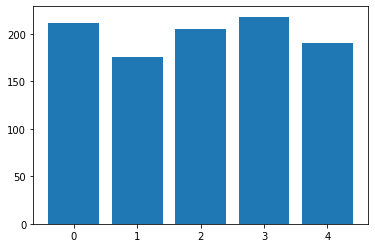

In [179]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


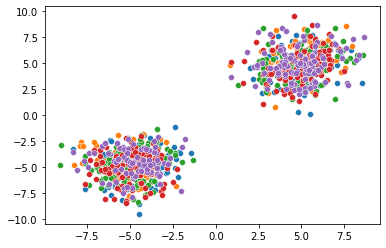

In [180]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

ValueError: The palette list has the wrong number of colors.

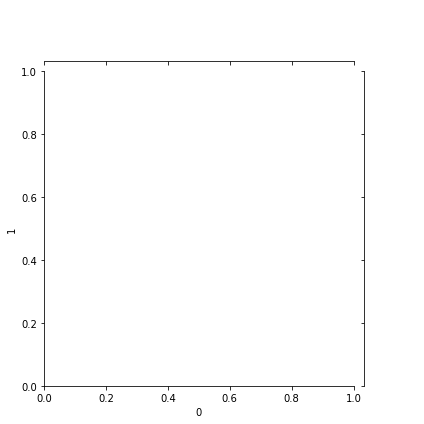

In [15]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [16]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

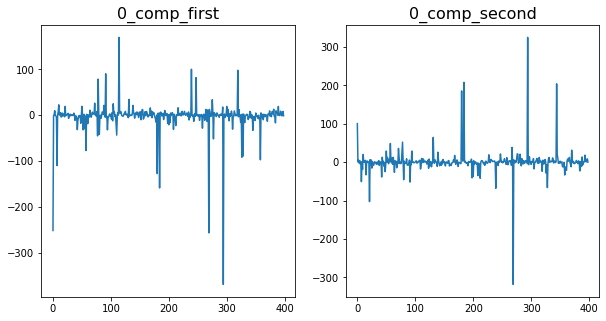

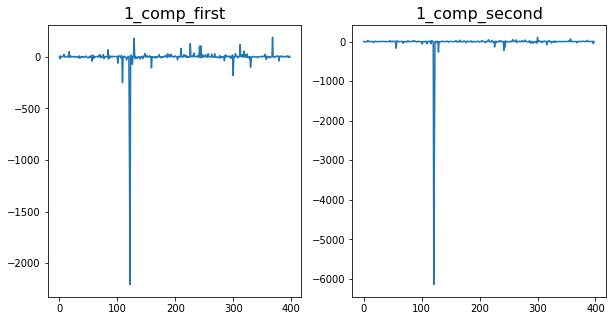

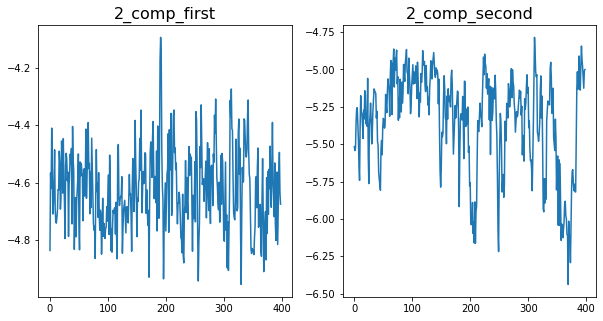

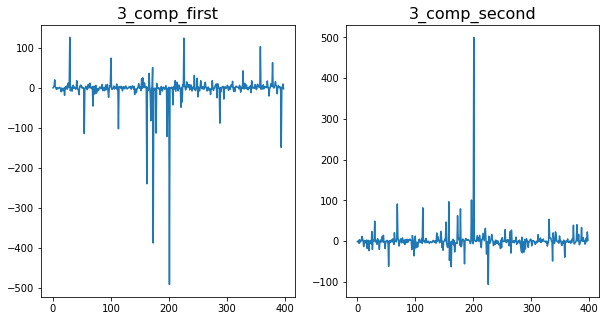

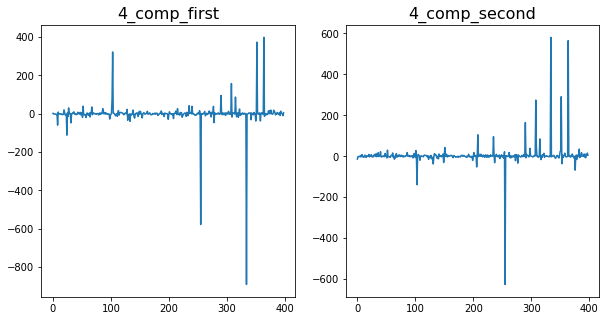

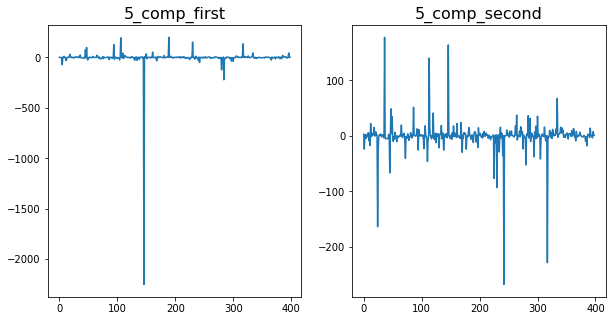

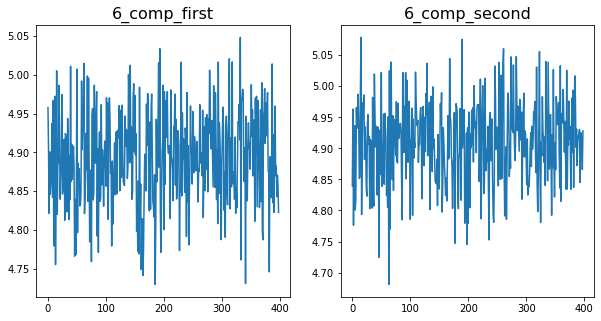

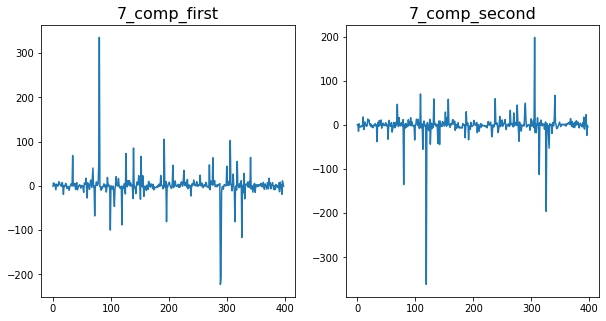

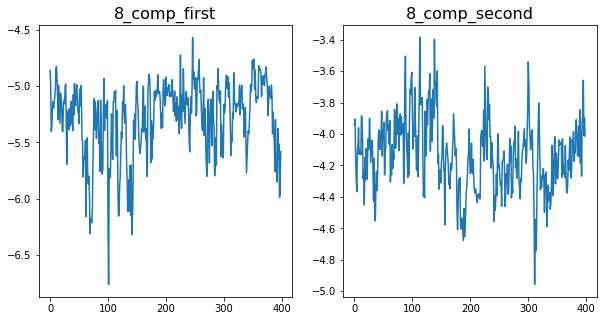

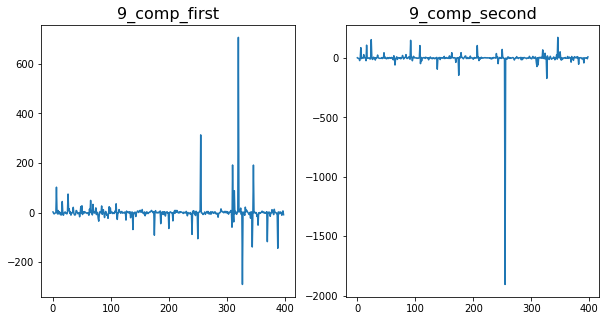

In [16]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

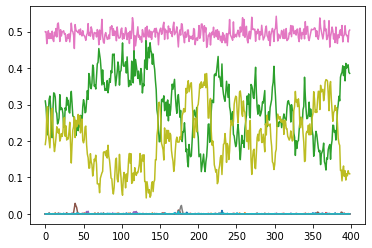

In [17]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [18]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


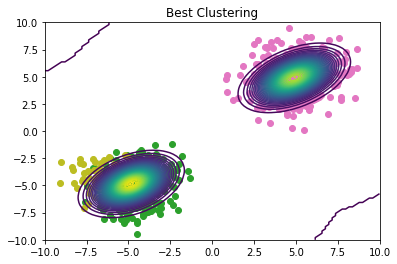

In [19]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)